# Demo: NEU - PERSONAL EXP

### Summary

This notebook demonstrates an Object Oriented Programming (OOP) implementation of a benchmarking system to compare a FEDS fire perimeter against other fire perimeter data sources, and then store in an output object. 

*This particularly demonstrates ability to iterate over all available FEDS and create mass analysis results*

NOTE: This notebook was run in 1-2 month intervals due to the FEDS API item limit. For your range, if you recieve an error on the limit, try to reduce your time window. A year will need to be broken into ~8-10 intervals 

Sources for demonstration:
- FEDS archived perimeters, labeled as `"public.eis_fire_lf_perimeter_archive"`
- NIFC historic perimeters, labeled as `"nifc_interagency_history_local"`

The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

#### Motivation 
FEDS-PEC eliminates the need for users to recreate/repeat solutions when conducting geospatial data evaluations. By leveraging this module, researchers and analysts can quickly and efficiently compare the FEDS fireperimeter dataset against a reference data set of their choosing. Users can focus their efforts on dataset selection and analysis, rather than spending time implementing and testing software for comparisons and calculations.

### User Inputs for Comparison: time, bbox, FEDS set, reference set

Note for inputs:

FEDS Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive) according to documentation. Please see **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

Reference Input: See **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

In [1]:
import sys
sys.path.append('../') # local path append

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2018
month_start = 1 # 6
day_start = 1 # 1
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2021
month_stop = 12
day_stop = 31
hour_stop = 23
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326 # 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]

search_bbox = ["-121.915744", "39.707459", "-119.951285", "38.752760"] 

day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api"
feds_limit = 9000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False
feds_apply_finalfire = True 

# REFERENCE INPUT SETTINGS 
ref_title = "nifc_interagency_history_local" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS - User discretion advised for path functionality
print_on = True
plot_on = True
name_for_output_file = "2020_0301_to_0430_analysis"
output_format = "csv"
user_path = "/projects/my-public-bucket/VEDA-PEC/results"
output_maap_url = f"{user_path}/{name_for_output_file}.{output_format}"

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [3]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of FEDS in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed
Running FEDS-Reference Match Algorithm:  11%|█         | 2/18 [00:33<04:27, 16.74s/polygon]

FAILED TIME WINDOW: No matching dates found even with provided day search range window: 7, critical benchmarking failure. 
Due to failing window, use first intersection as value 


Running FEDS-Reference Match Algorithm:  17%|█▋        | 3/18 [00:50<04:16, 17.08s/polygon]

FAILED TIME WINDOW: No matching dates found even with provided day search range window: 7, critical benchmarking failure. 
Due to failing window, use first intersection as value 


Running FEDS-Reference Match Algorithm:  39%|███▉      | 7/18 [01:58<03:06, 16.96s/polygon]

FAILED TIME WINDOW: No matching dates found even with provided day search range window: 7, critical benchmarking failure. 
Due to failing window, use first intersection as value 


Running FEDS-Reference Match Algorithm:  44%|████▍     | 8/18 [02:15<02:49, 16.93s/polygon]

FAILED TIME WINDOW: No matching dates found even with provided day search range window: 7, critical benchmarking failure. 
Due to failing window, use first intersection as value 


Running FEDS-Reference Match Algorithm: 100%|██████████| 18/18 [05:06<00:00, 17.01s/polygon]


DATE MATCHING COMPLETE
CALCULATED A RESULT: POLYGON FEDS AT INDEX 252 AGAINST REFERENCE POLYGON AT INDEX 11501:
Ratio: 1.045787918624433, Accuracy: 1.026613710911676, Precision: 0.8206938189130133, Recall: 0.8582716807089775, IOU: 0.4915515404780689, F1 0.8390622242857615, Symmetric Ratio: 0.32924455720652196
All measurements in units metre
NO CALCULATION RESULTS, SKIP FEDS INDEX 912 & REFERENCE INDEX 912
CALCULATED A RESULT: POLYGON FEDS AT INDEX 102 AGAINST REFERENCE POLYGON AT INDEX 4915:
Ratio: 1330.9949037958277, Accuracy: 0.5338317275314428, Precision: 0.00075131767758699, Recall: 1.0000000000000004, IOU: 0.0007508952008717885, F1 0.0015015072462368573, Symmetric Ratio: 1329.9949037958256
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 102 AGAINST REFERENCE POLYGON AT INDEX 5583:
Ratio: 220.7825082789383, Accuracy: 0.5337784326490972, Precision: 0.0038524193203125093, Recall: 0.8505468004808384, IOU: 0.0038385342789738087, F1 0.007670098125241657, Symme

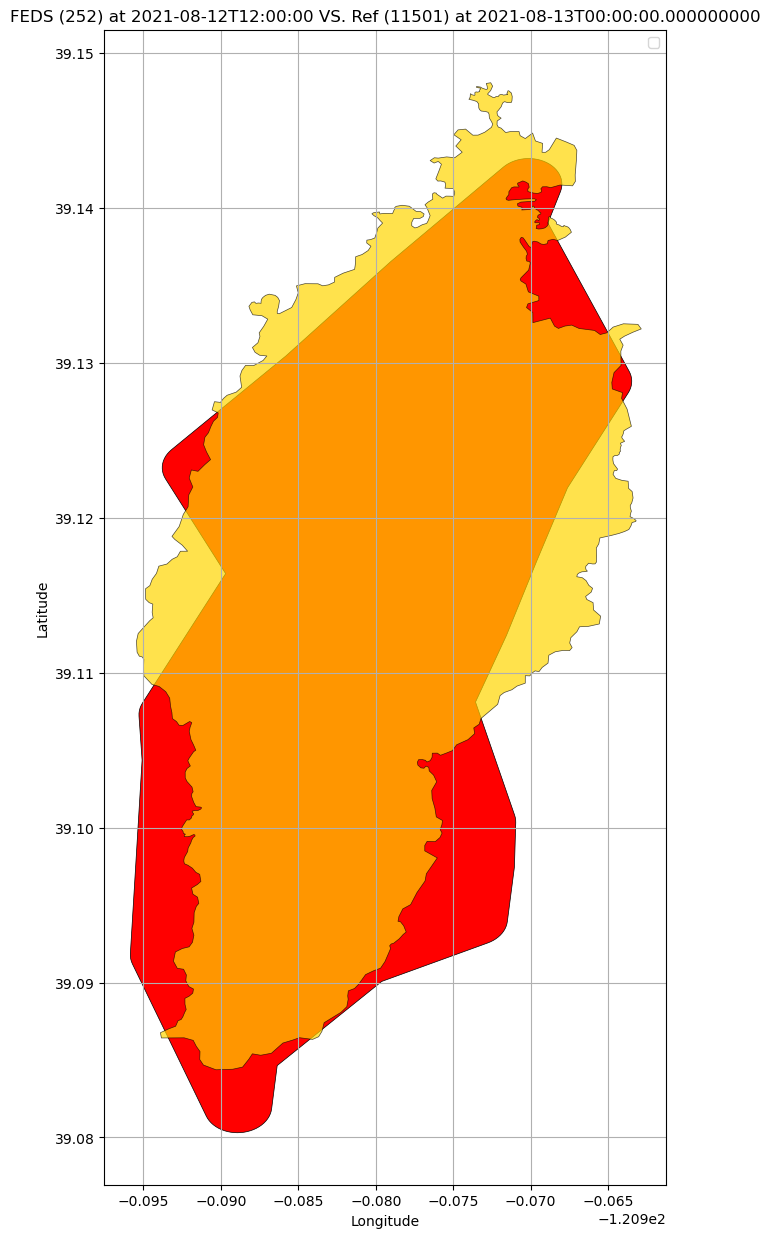

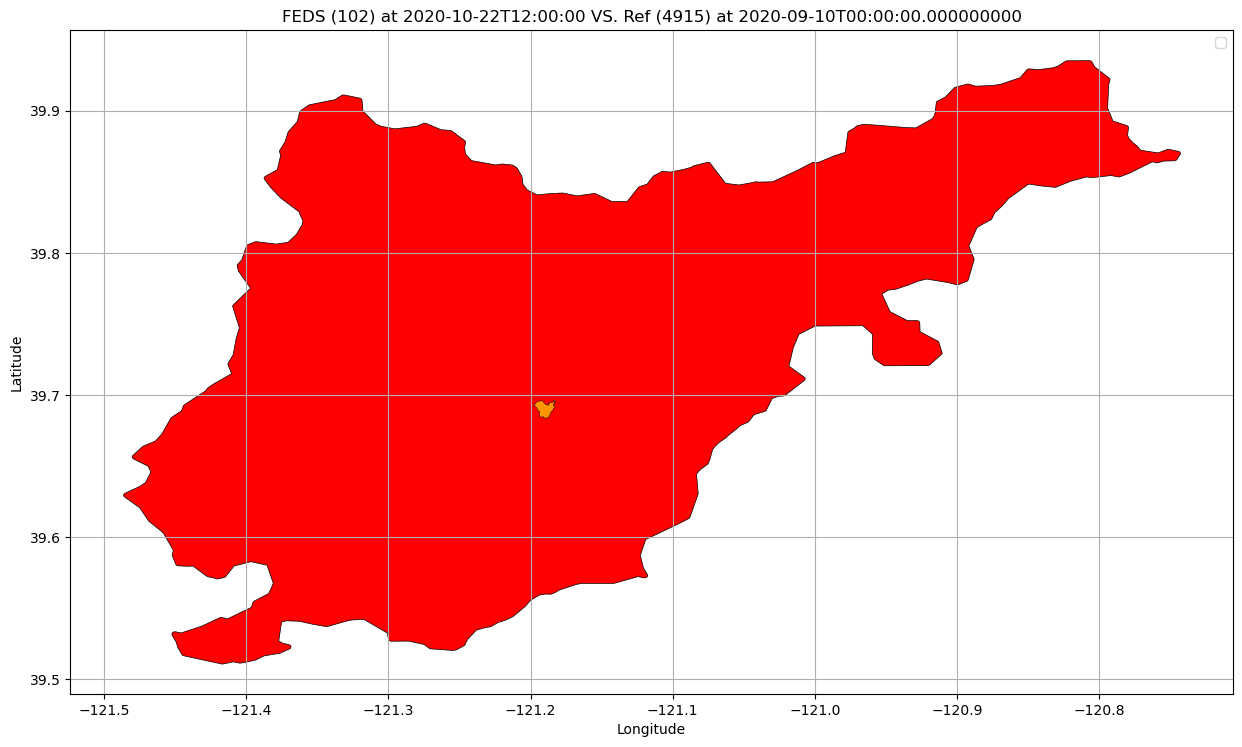

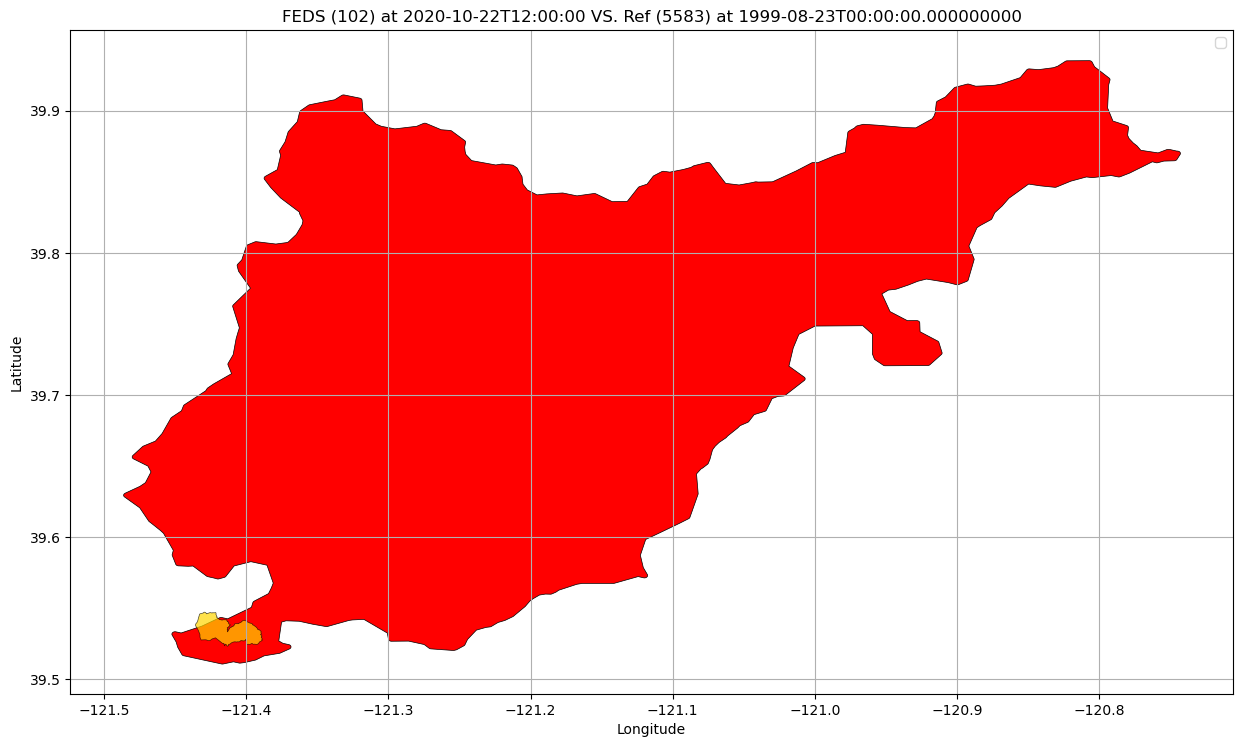

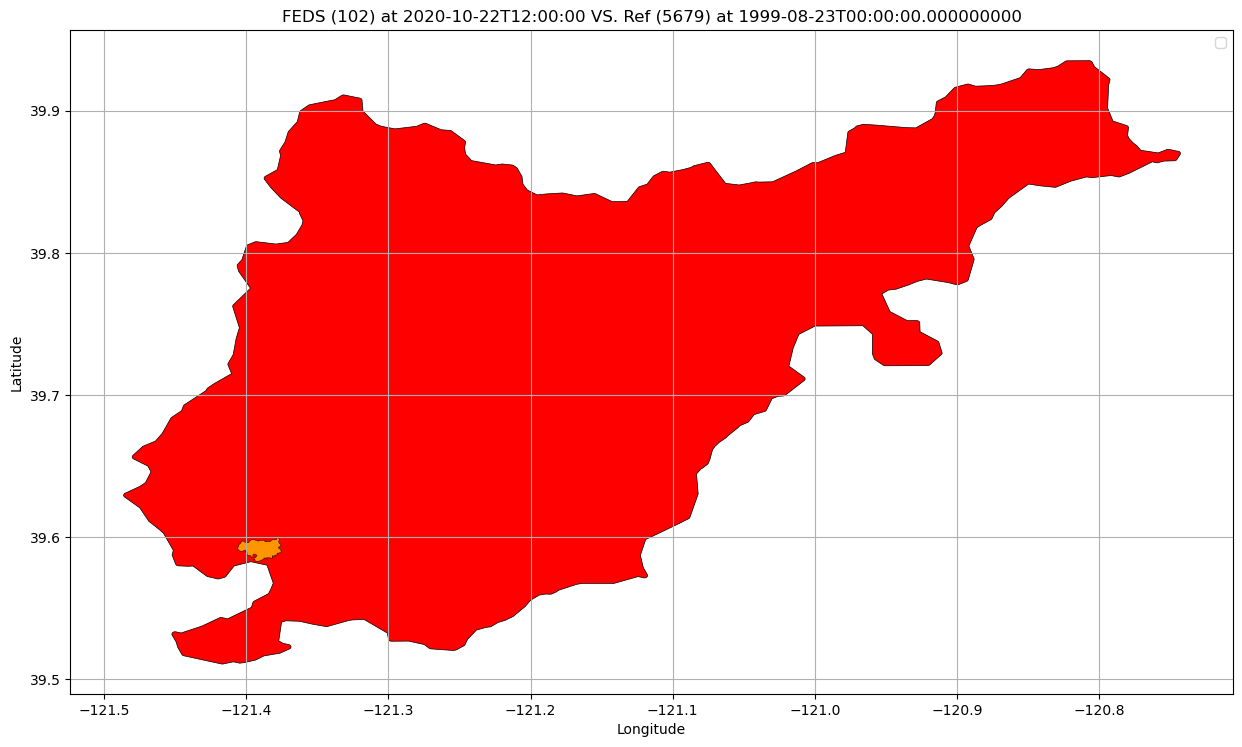

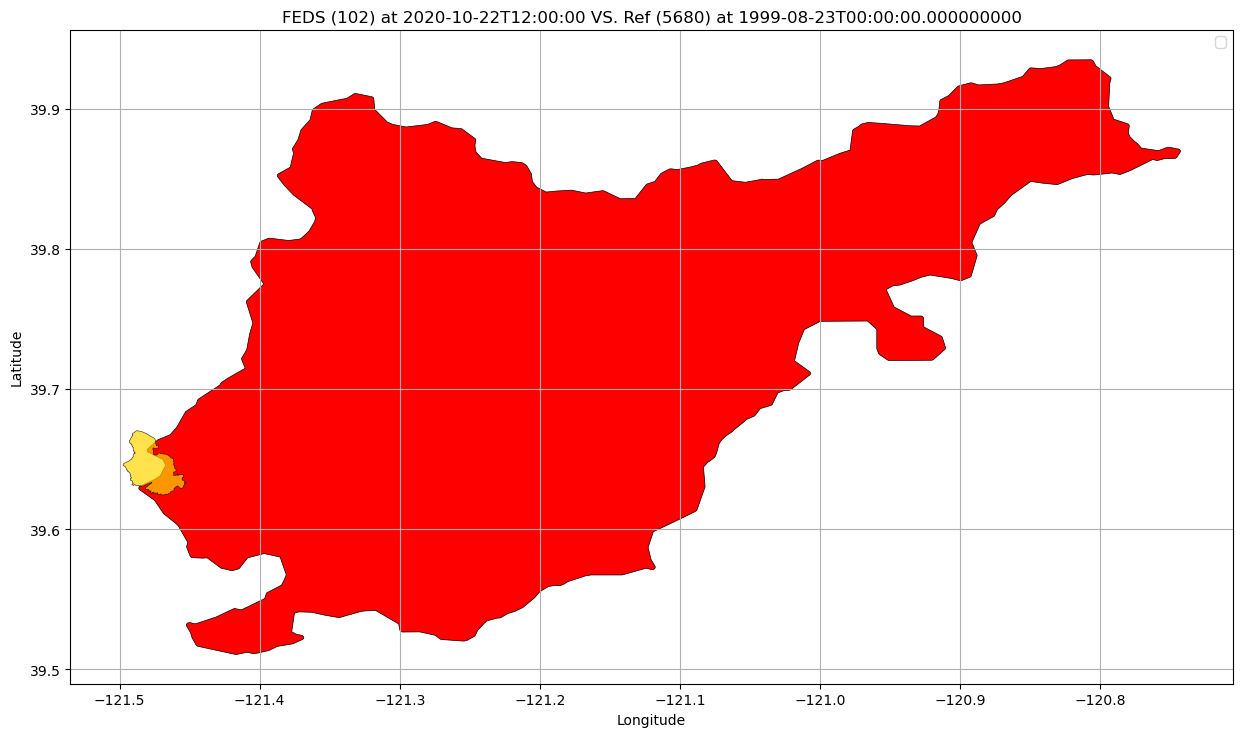

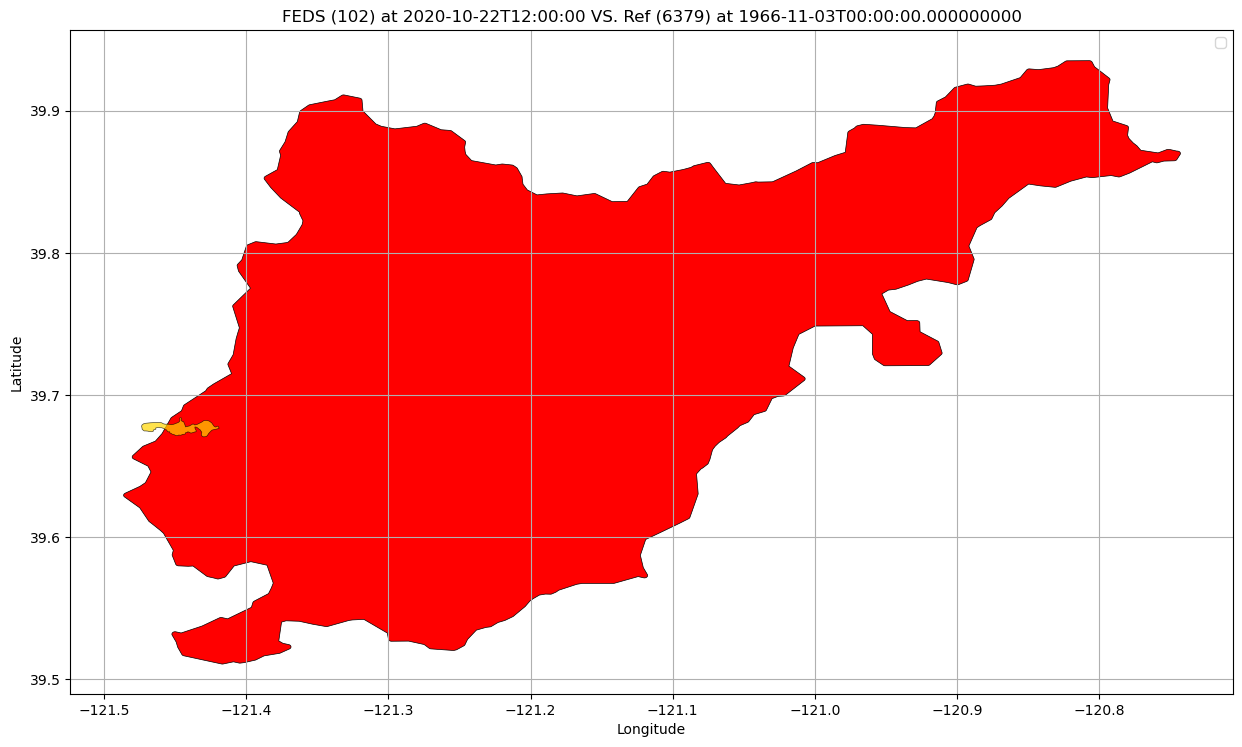

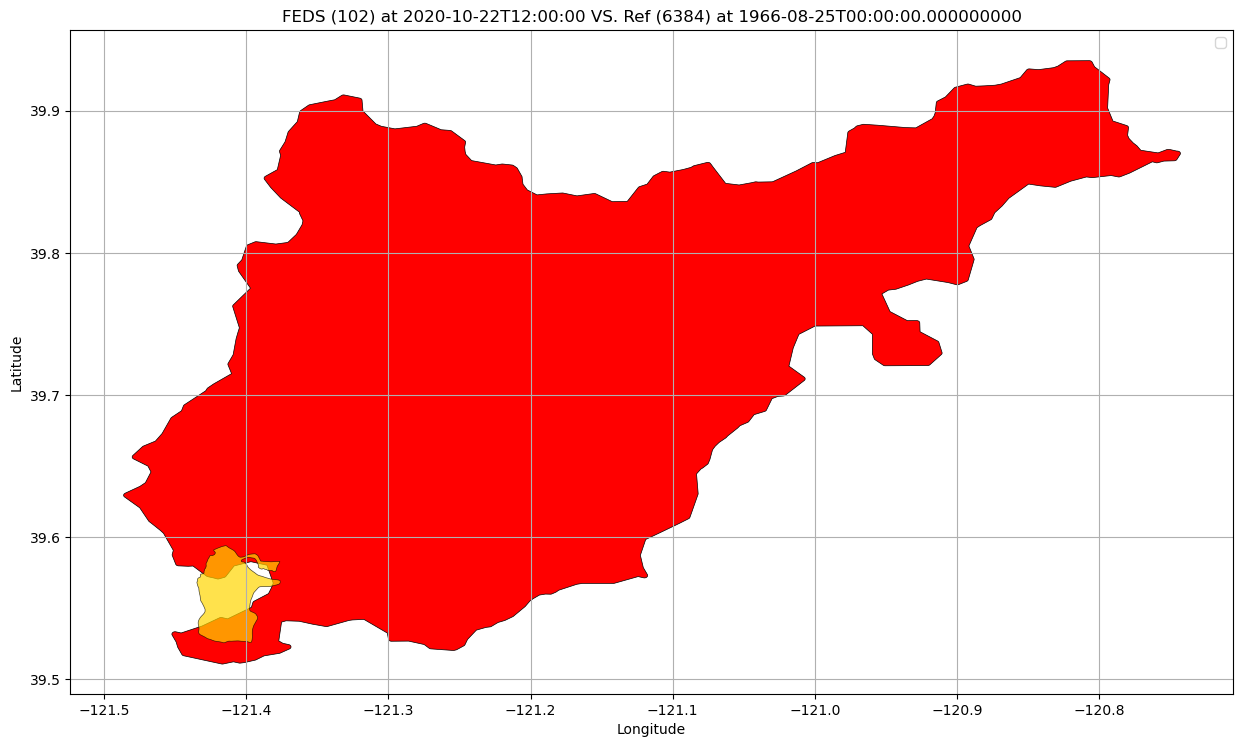

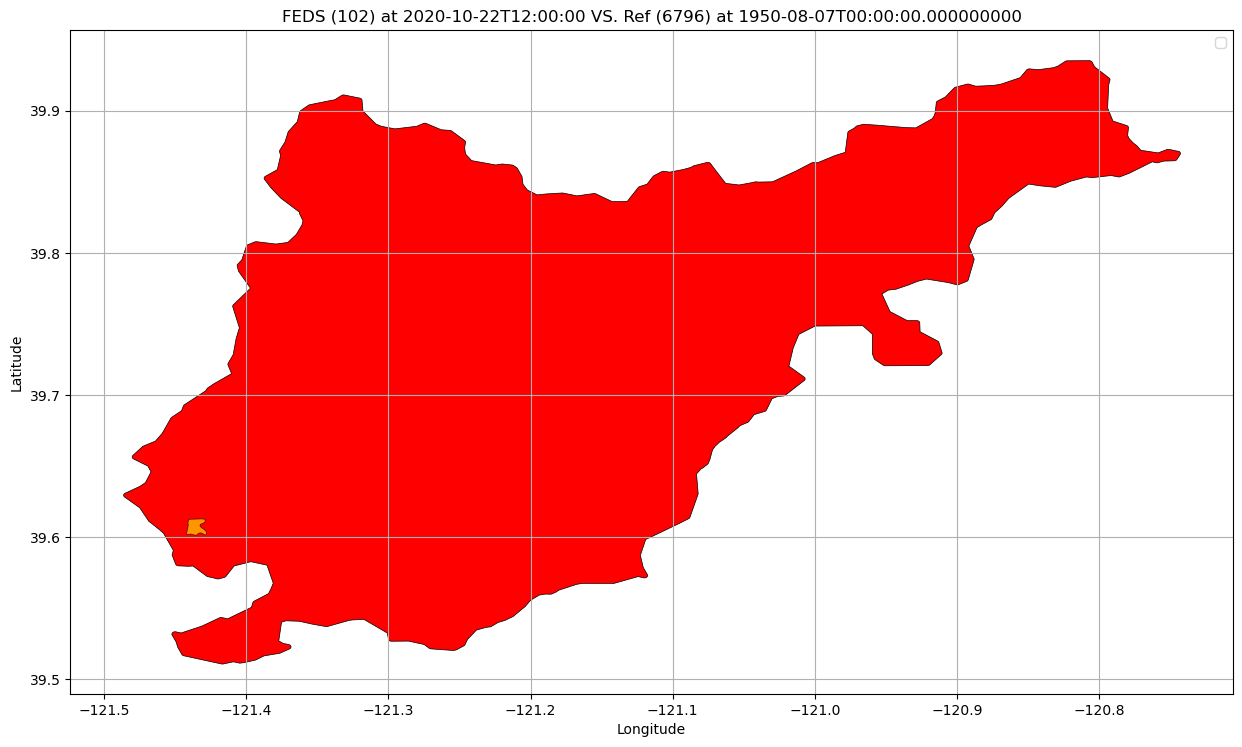

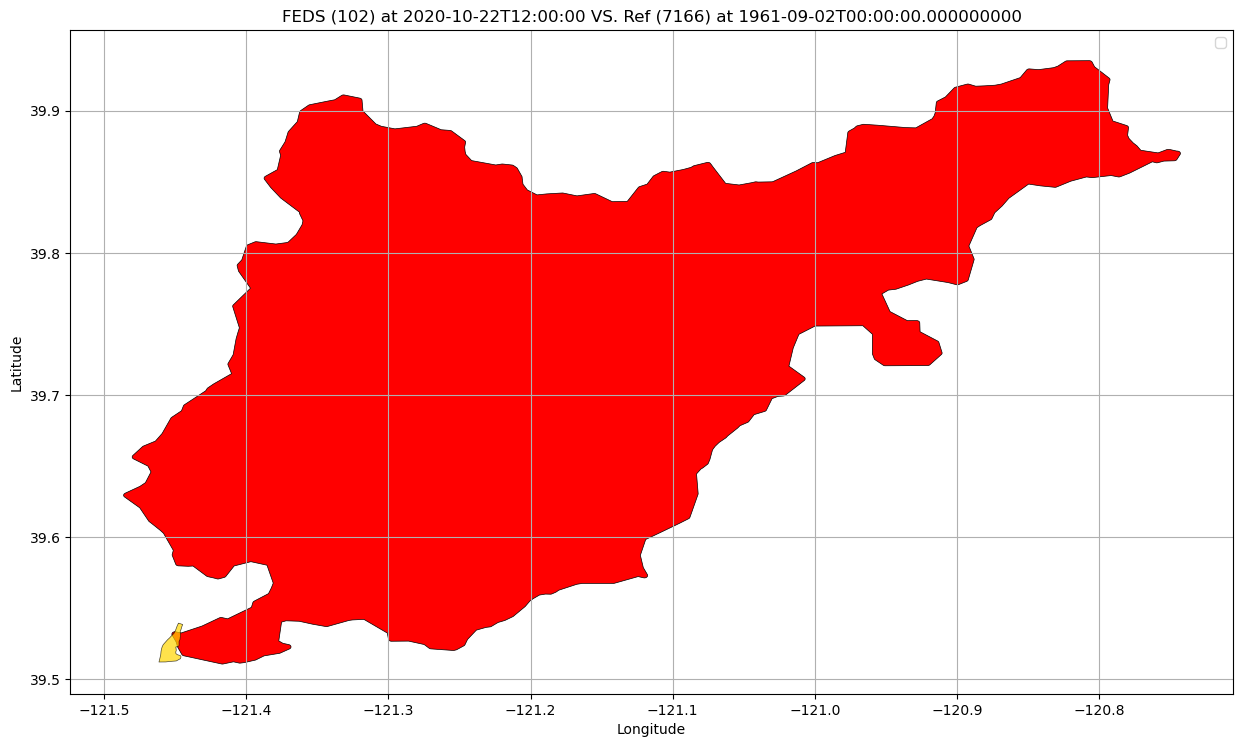

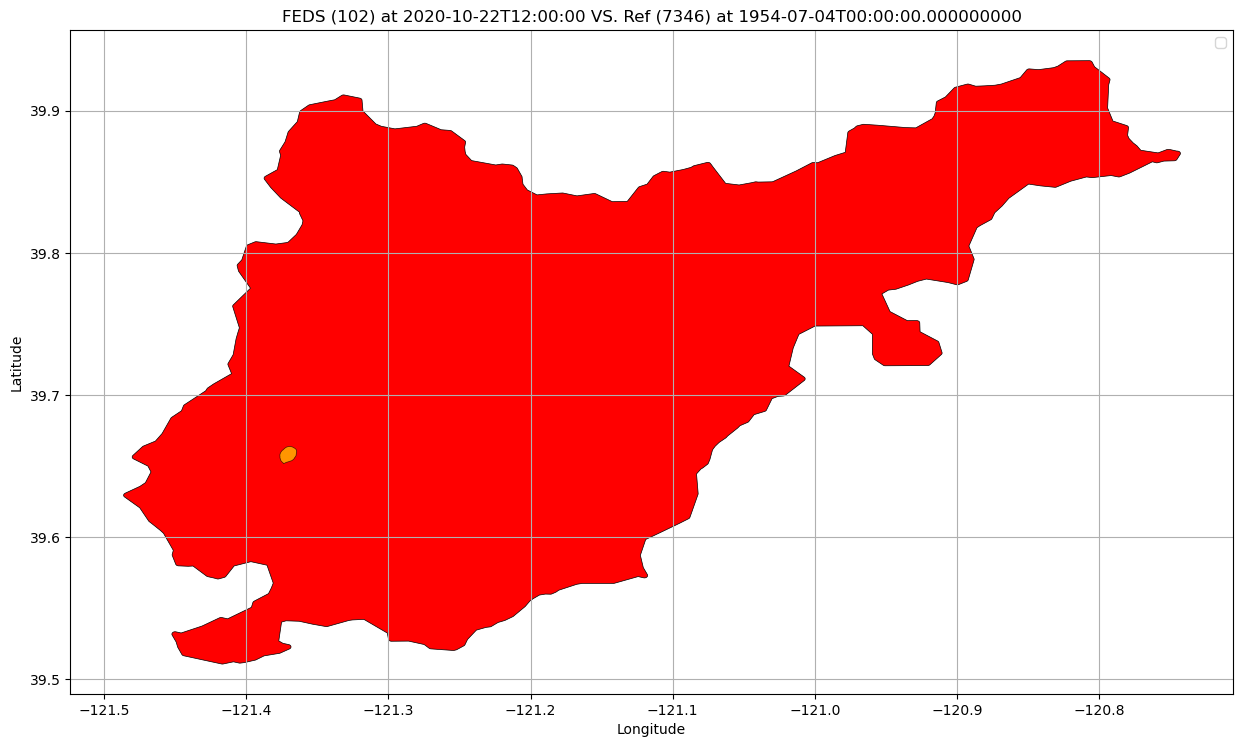

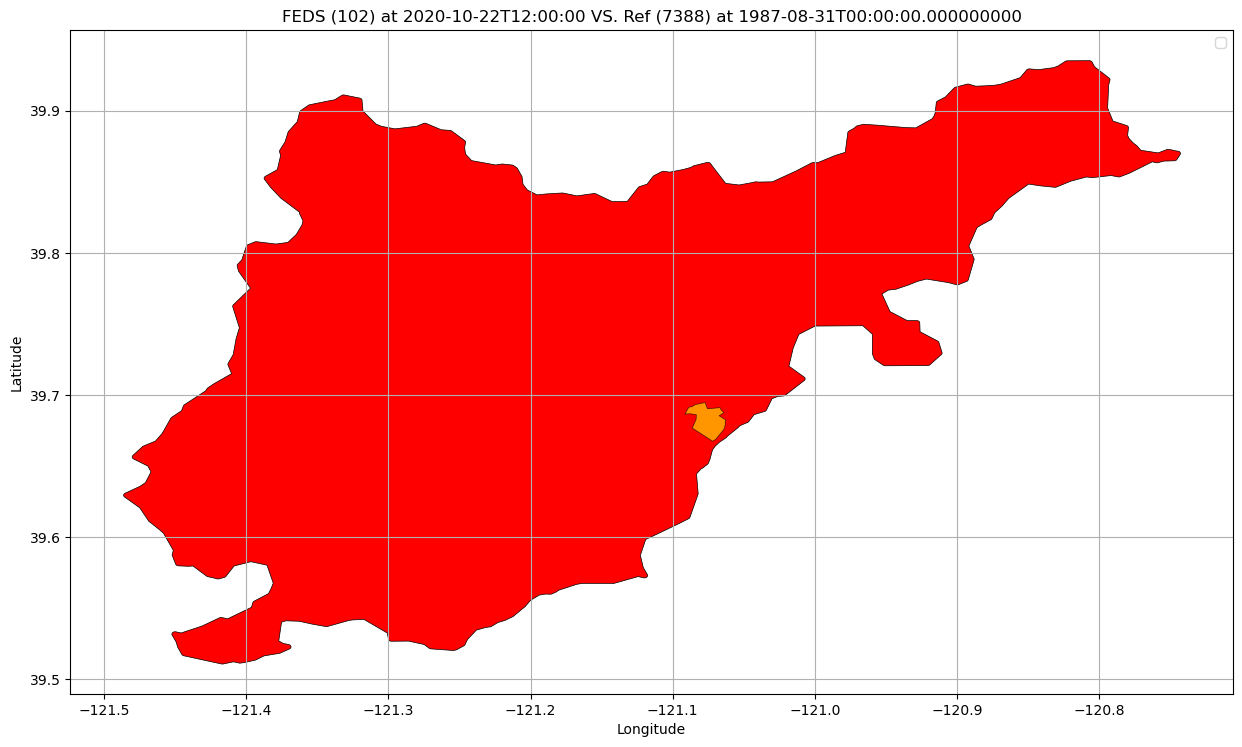

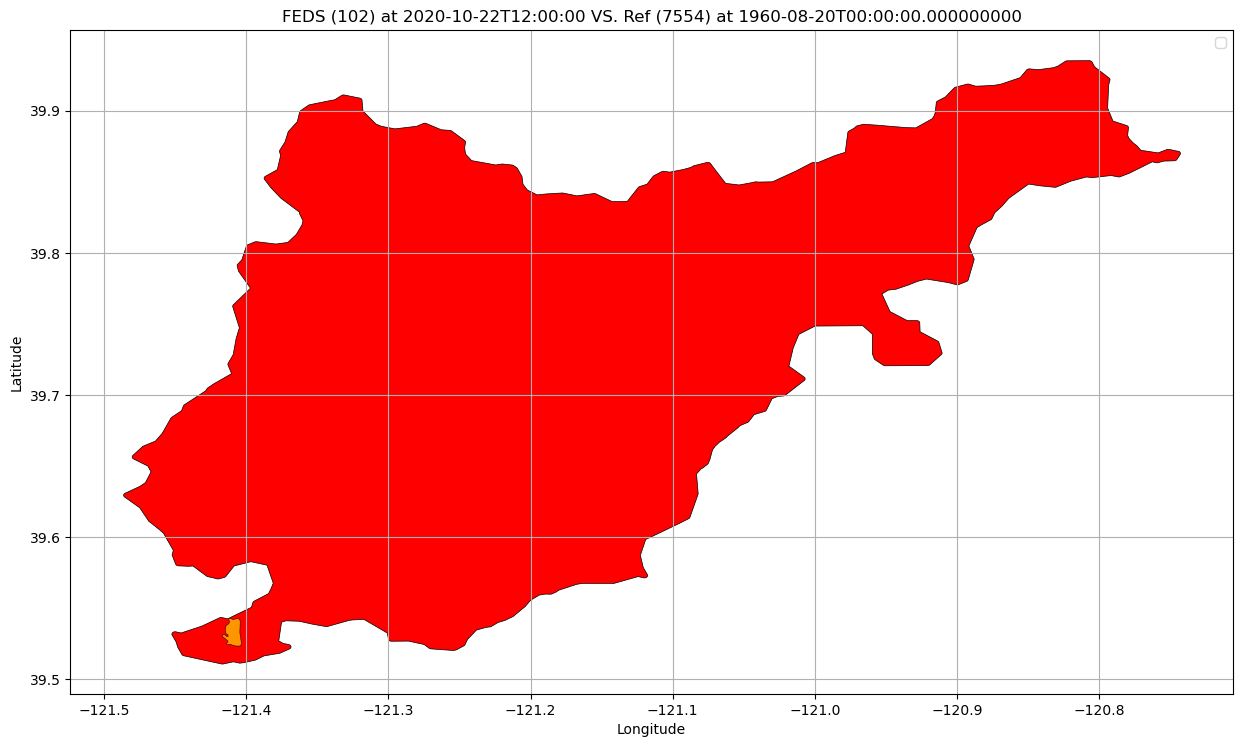

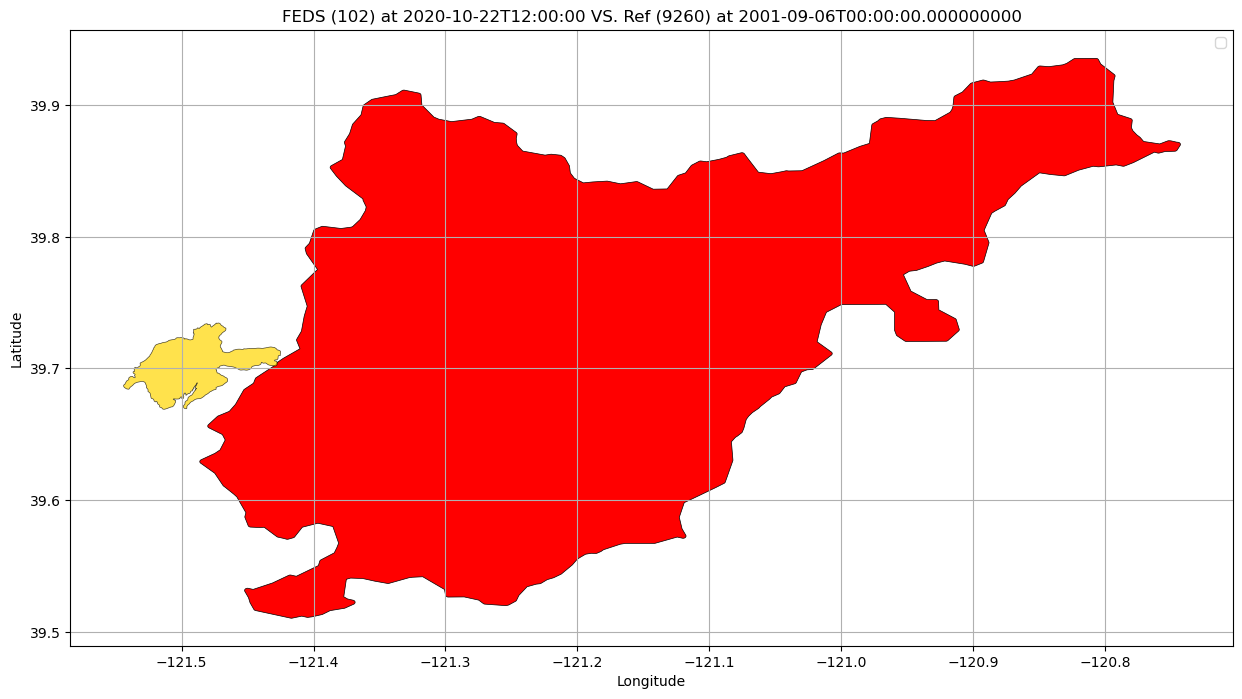

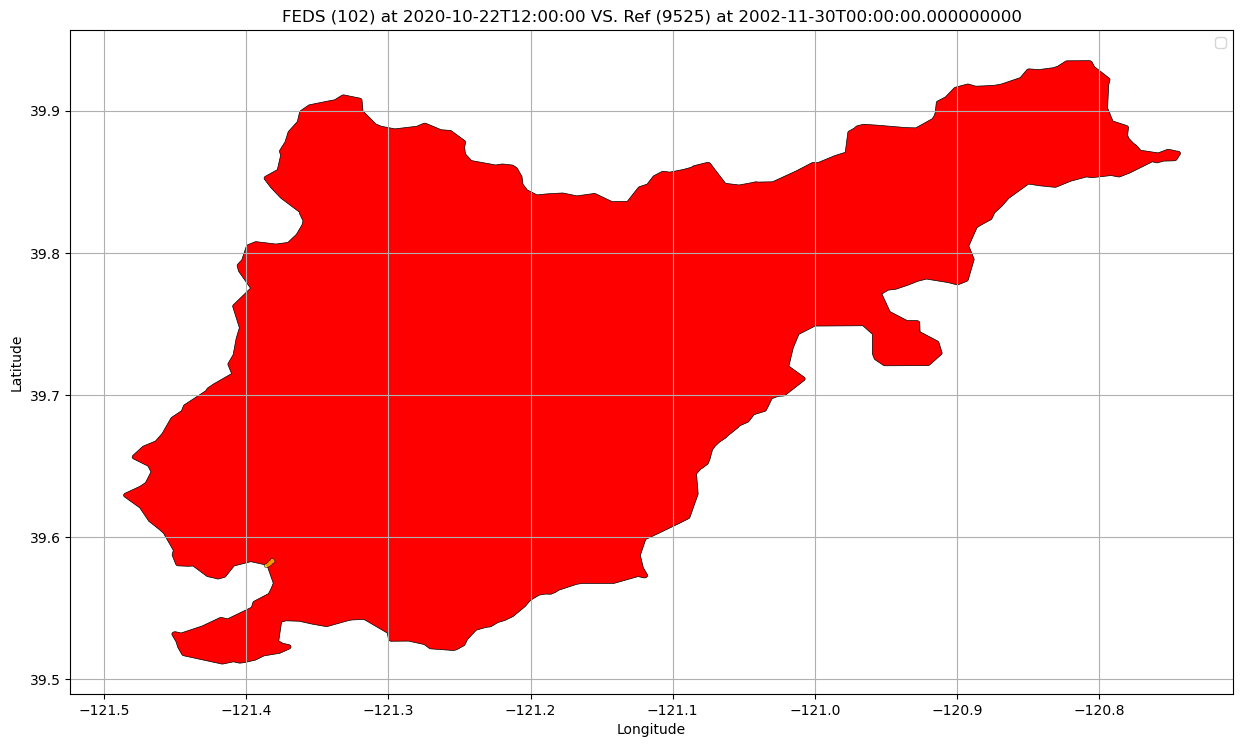

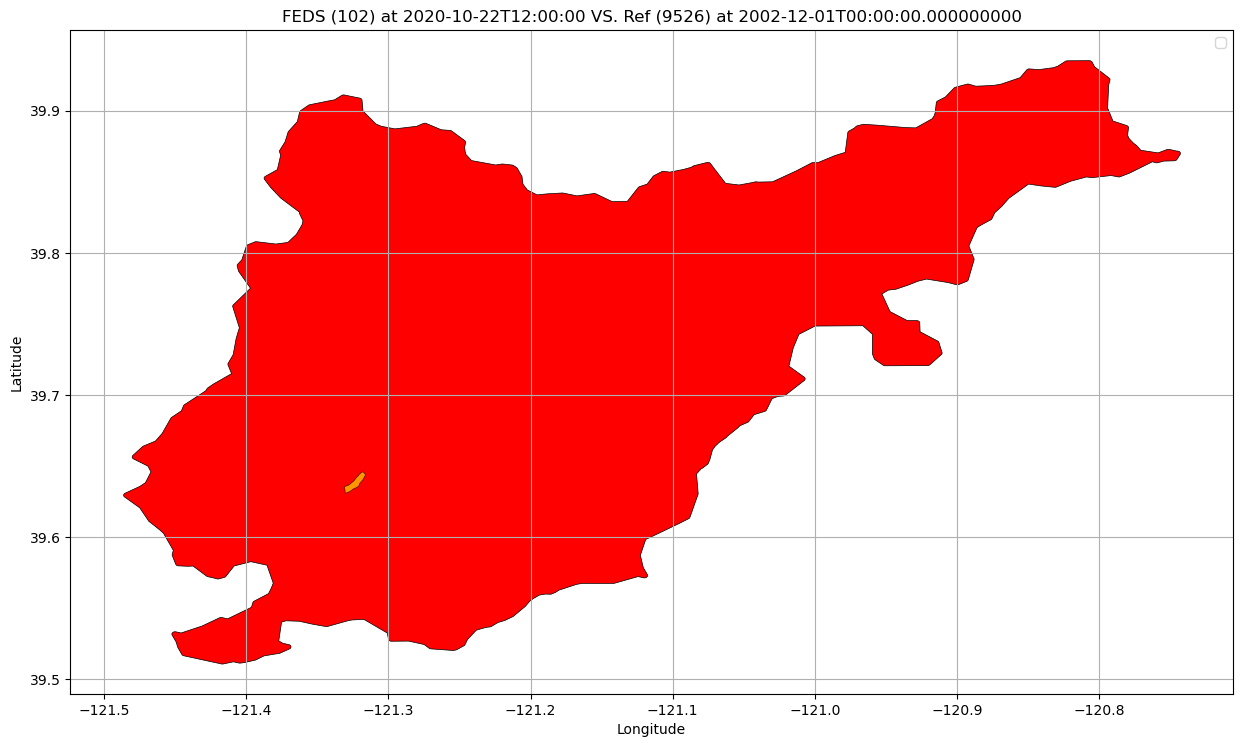

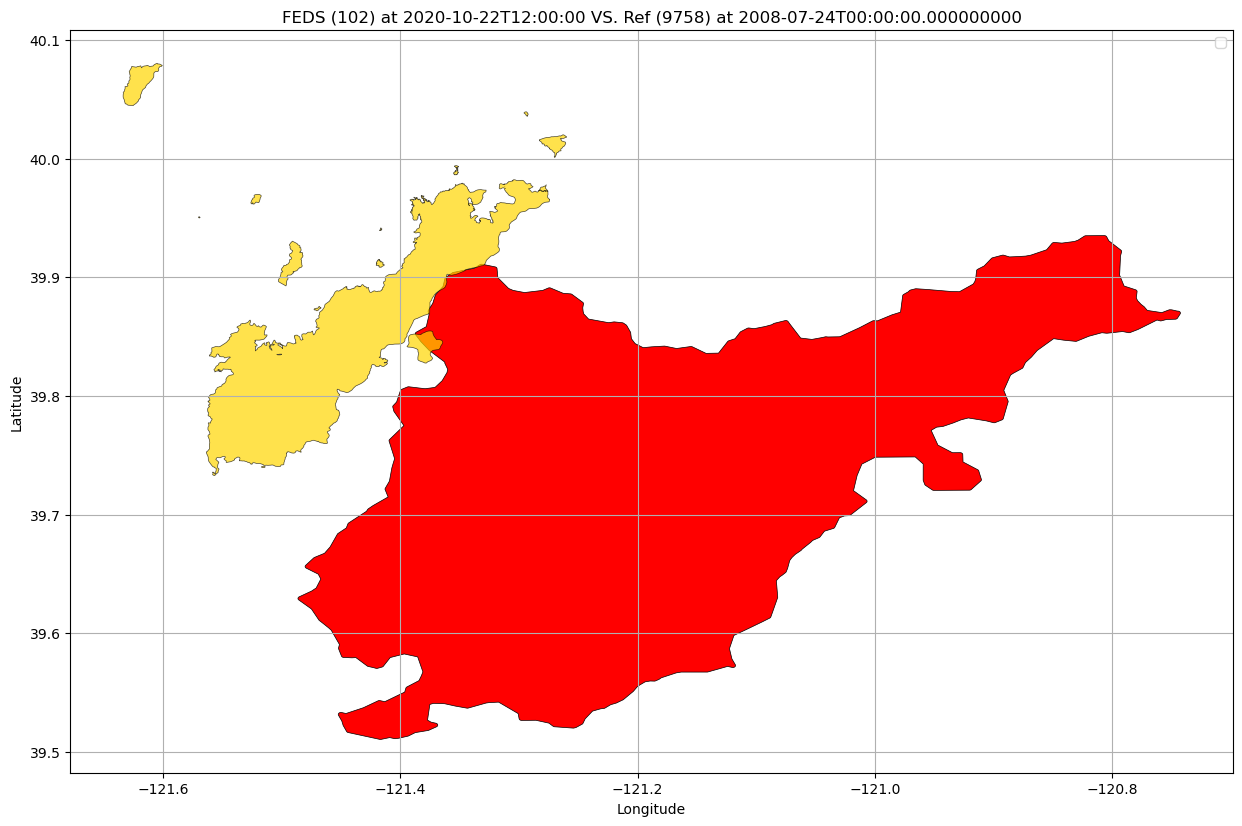

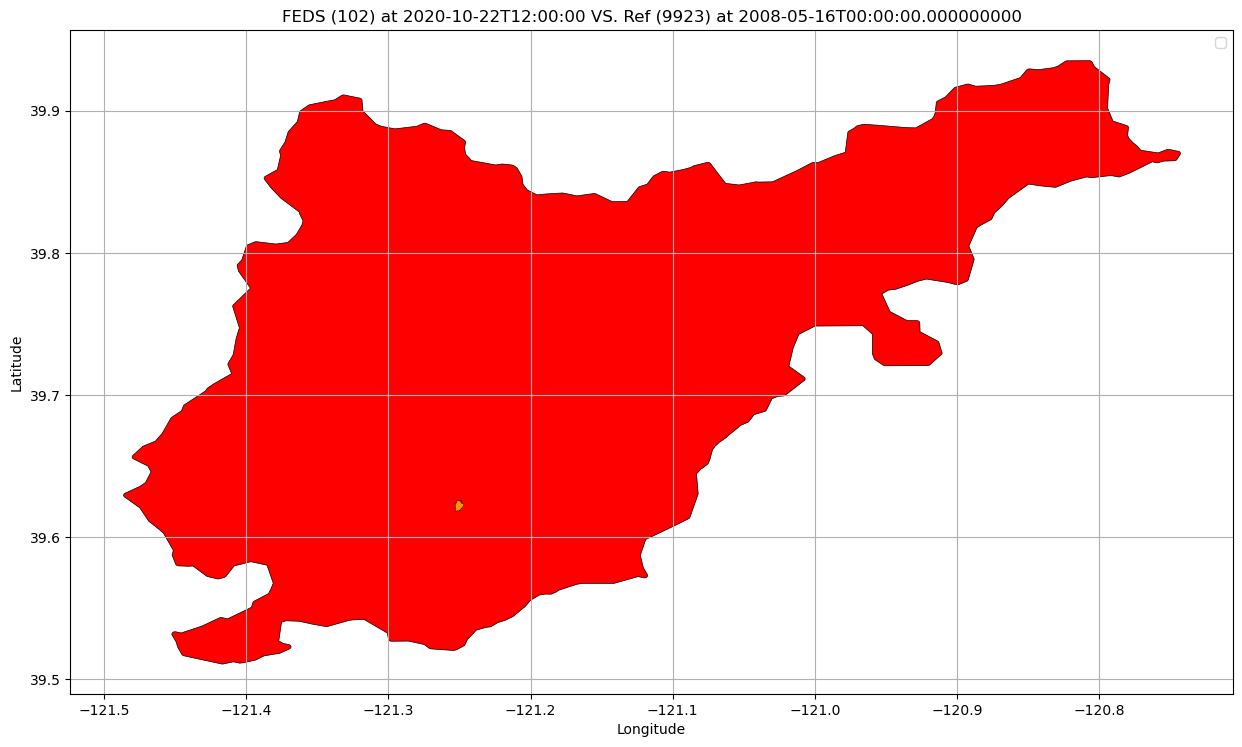

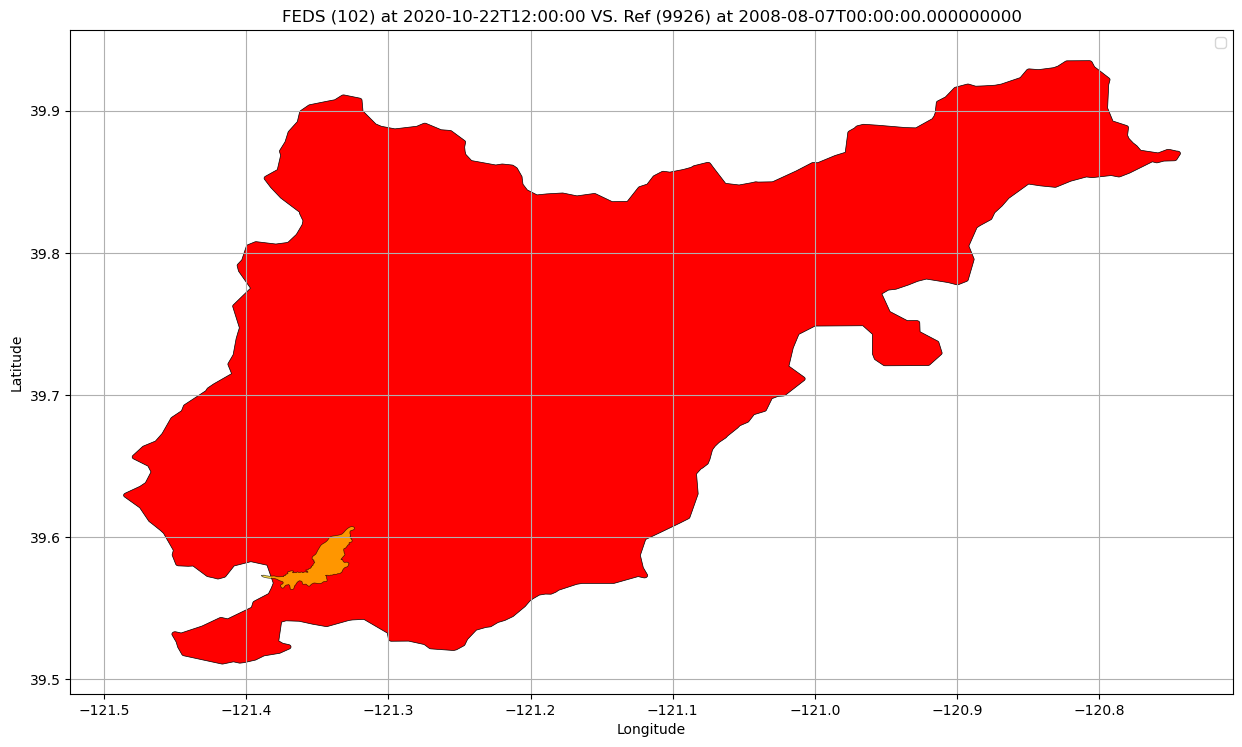

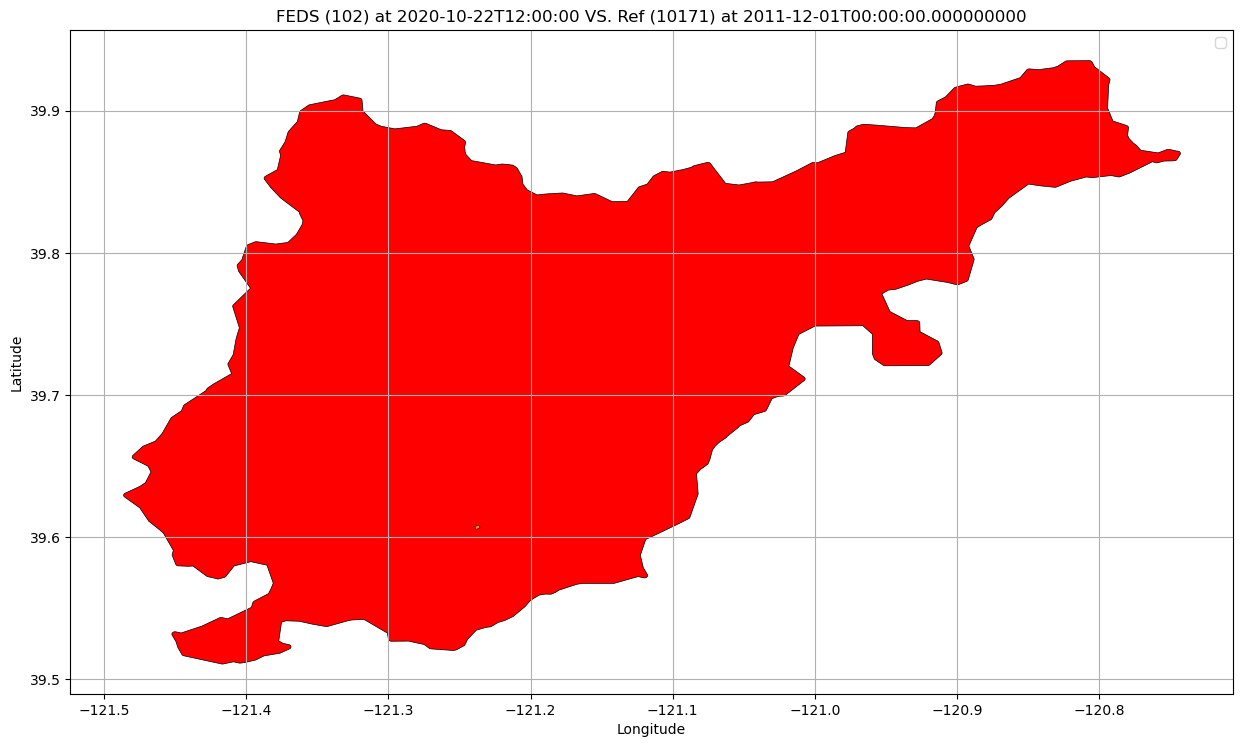

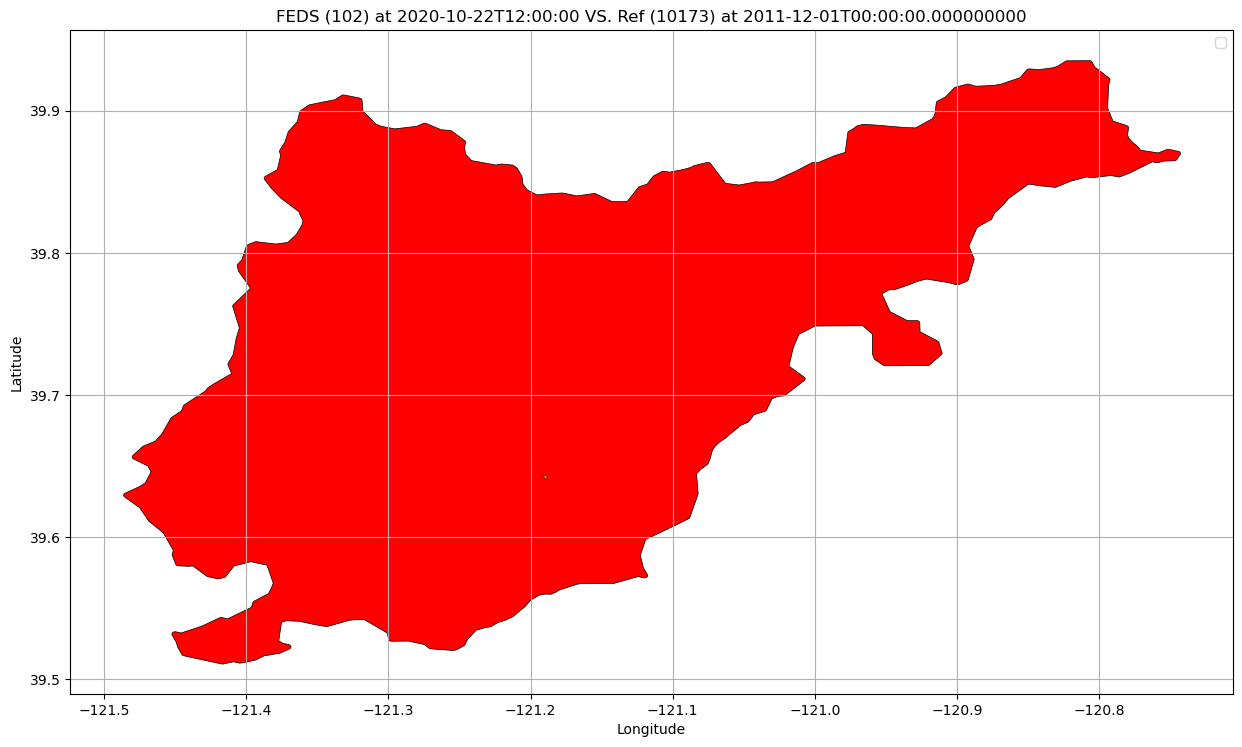

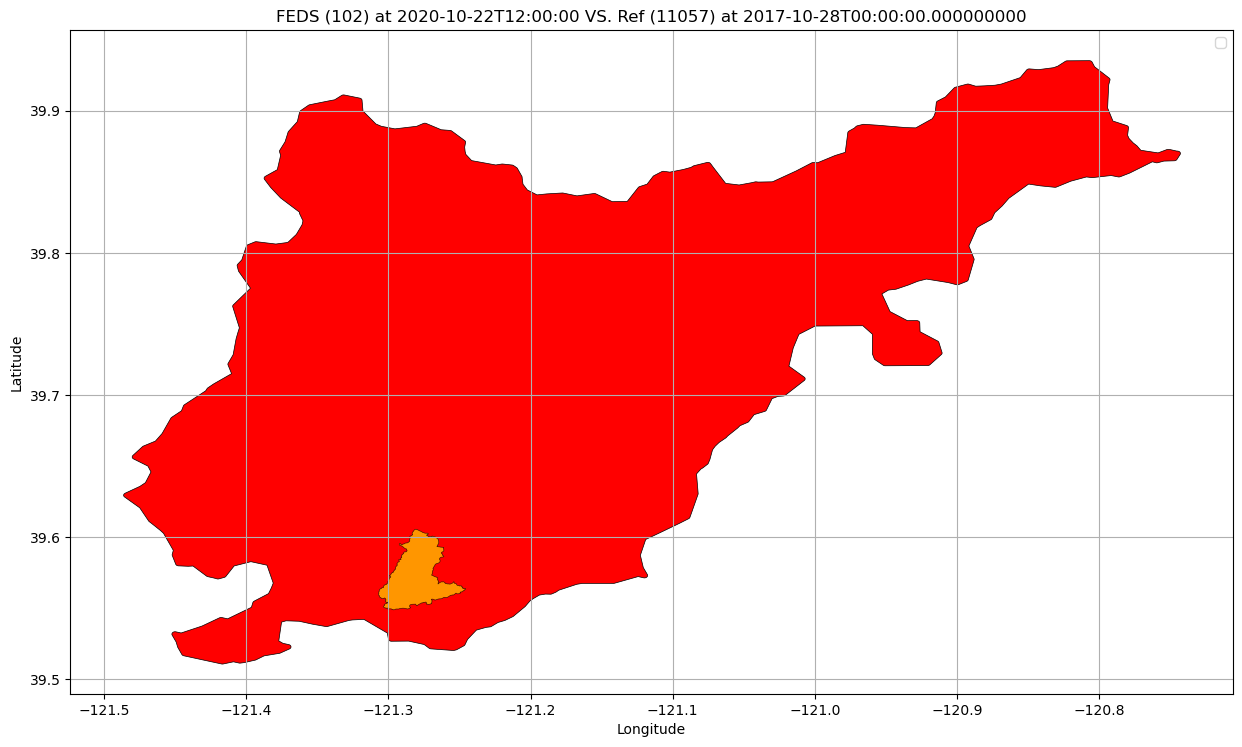

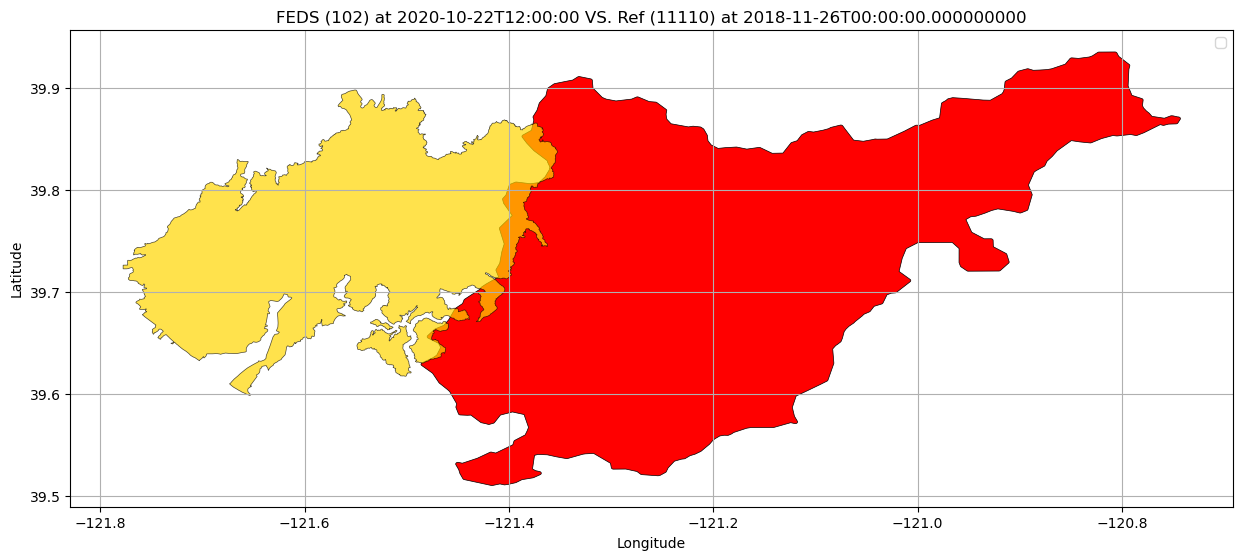

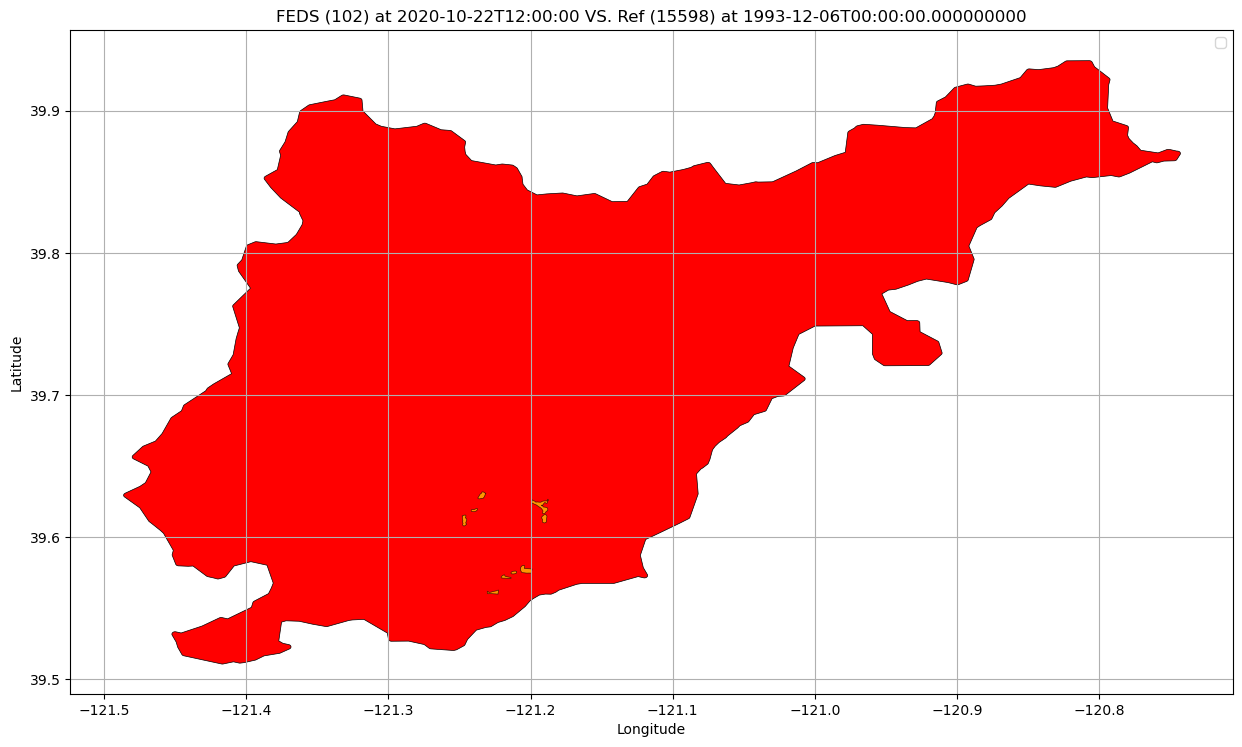

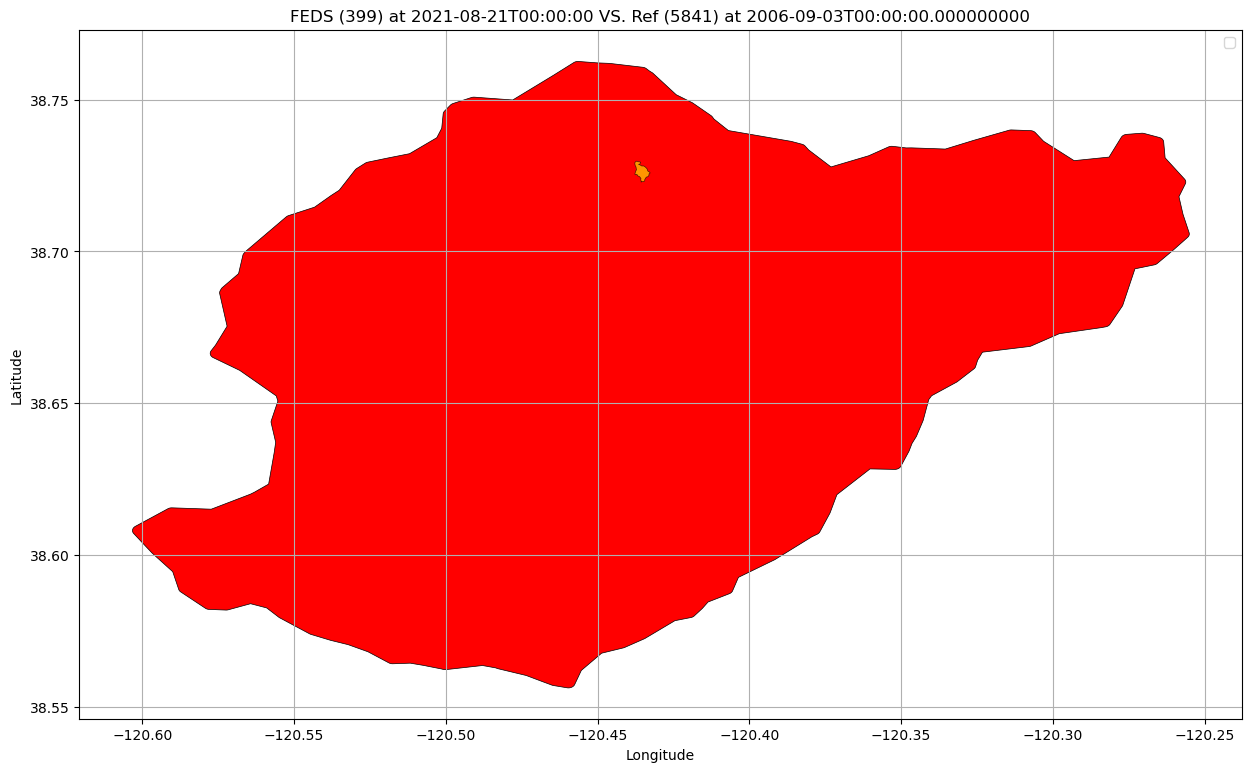

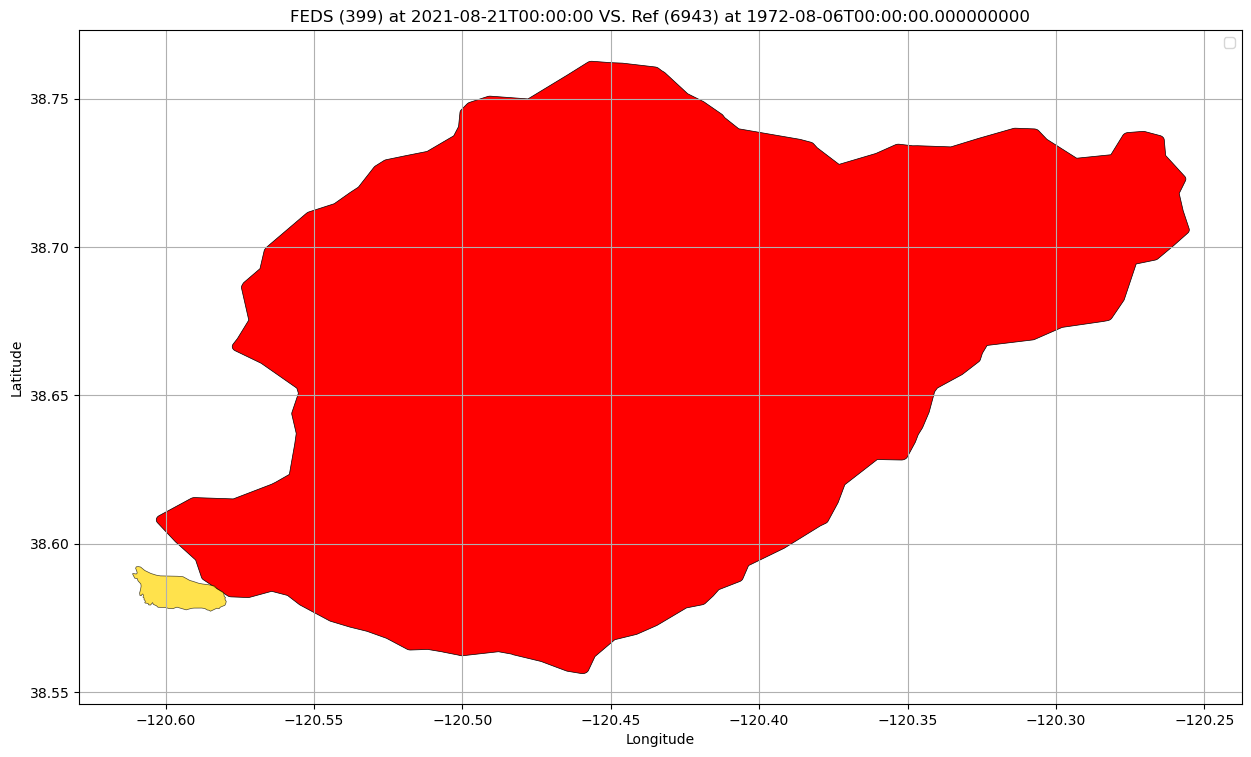

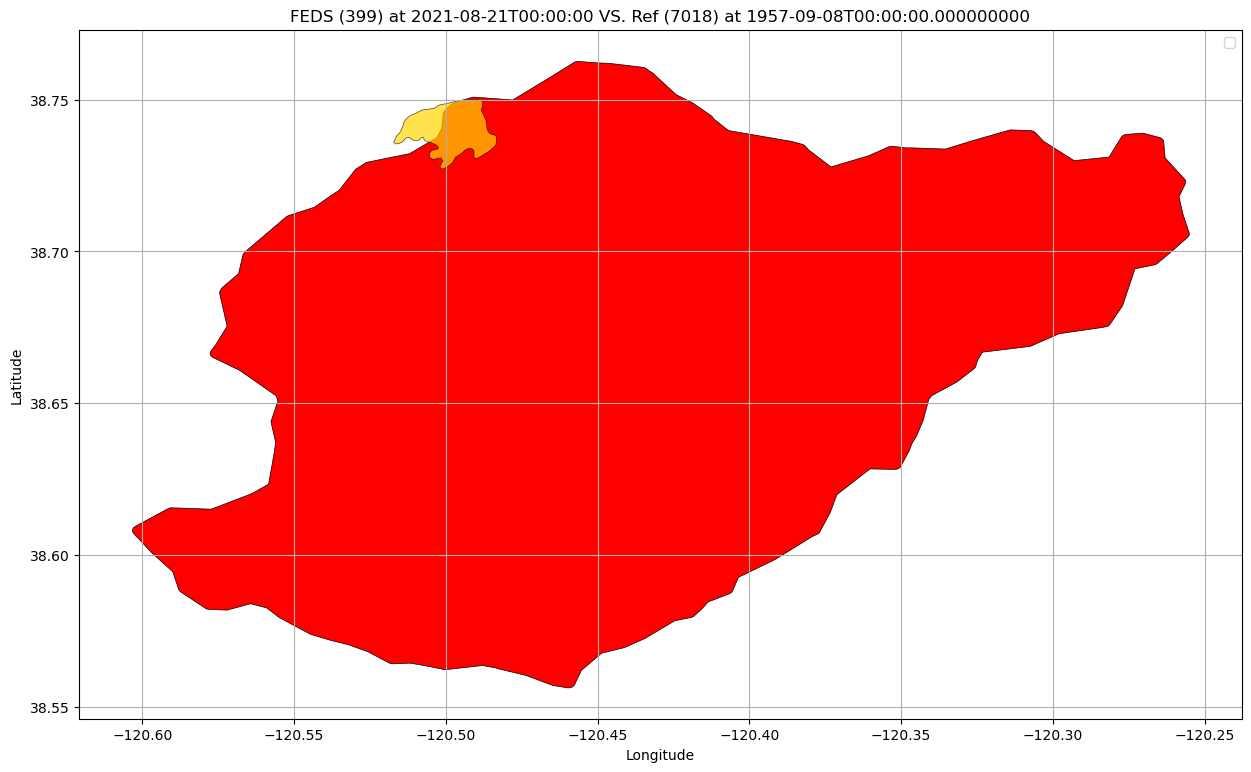

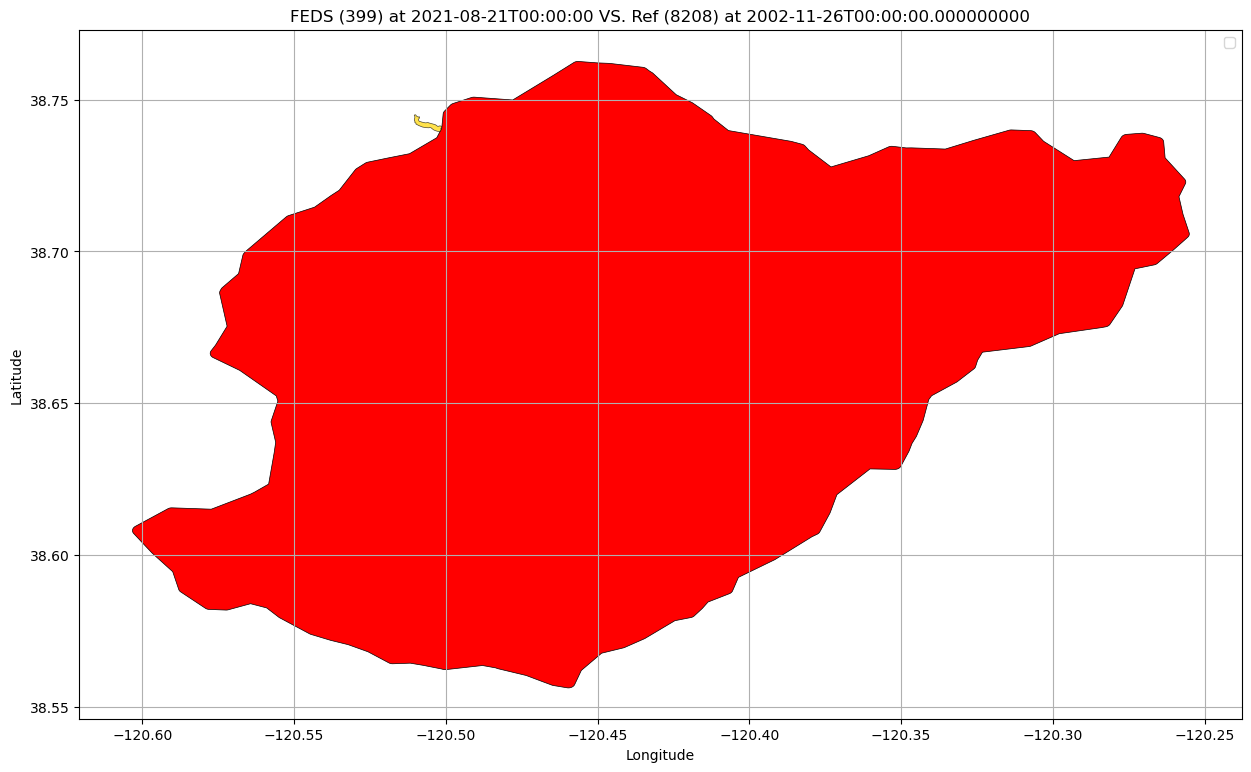

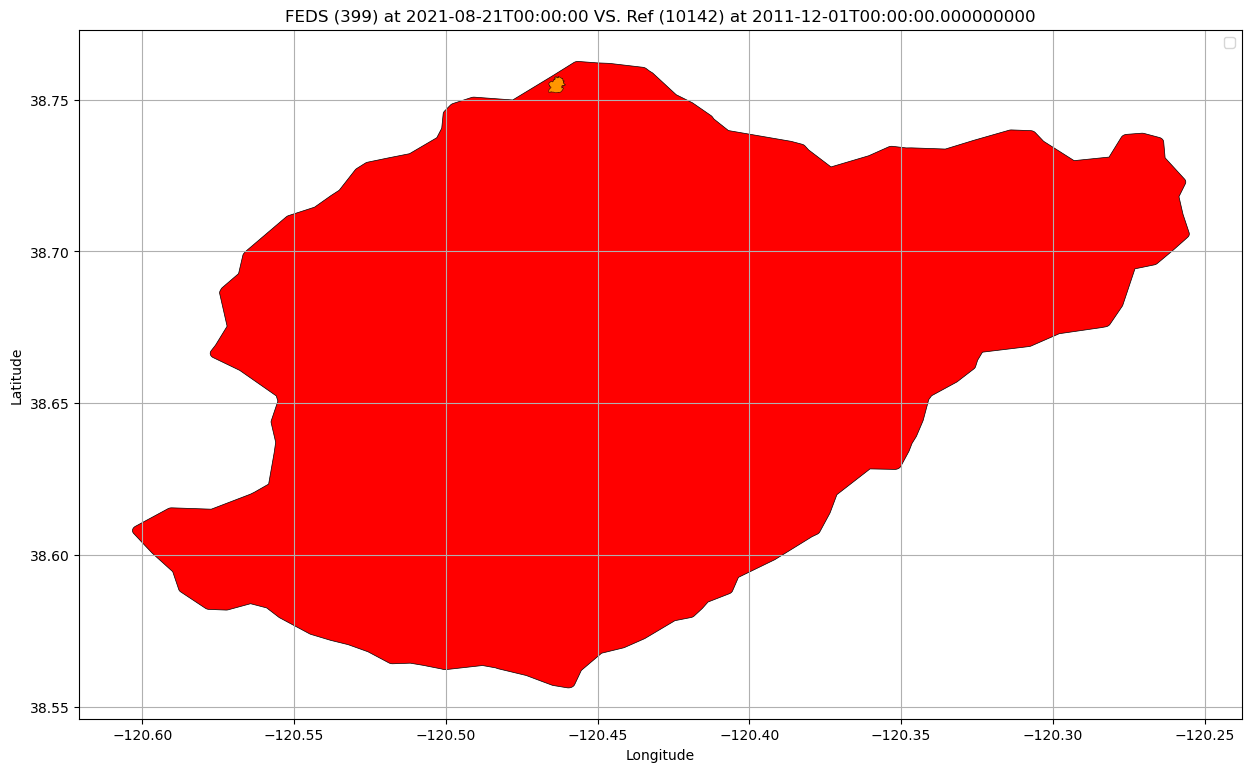

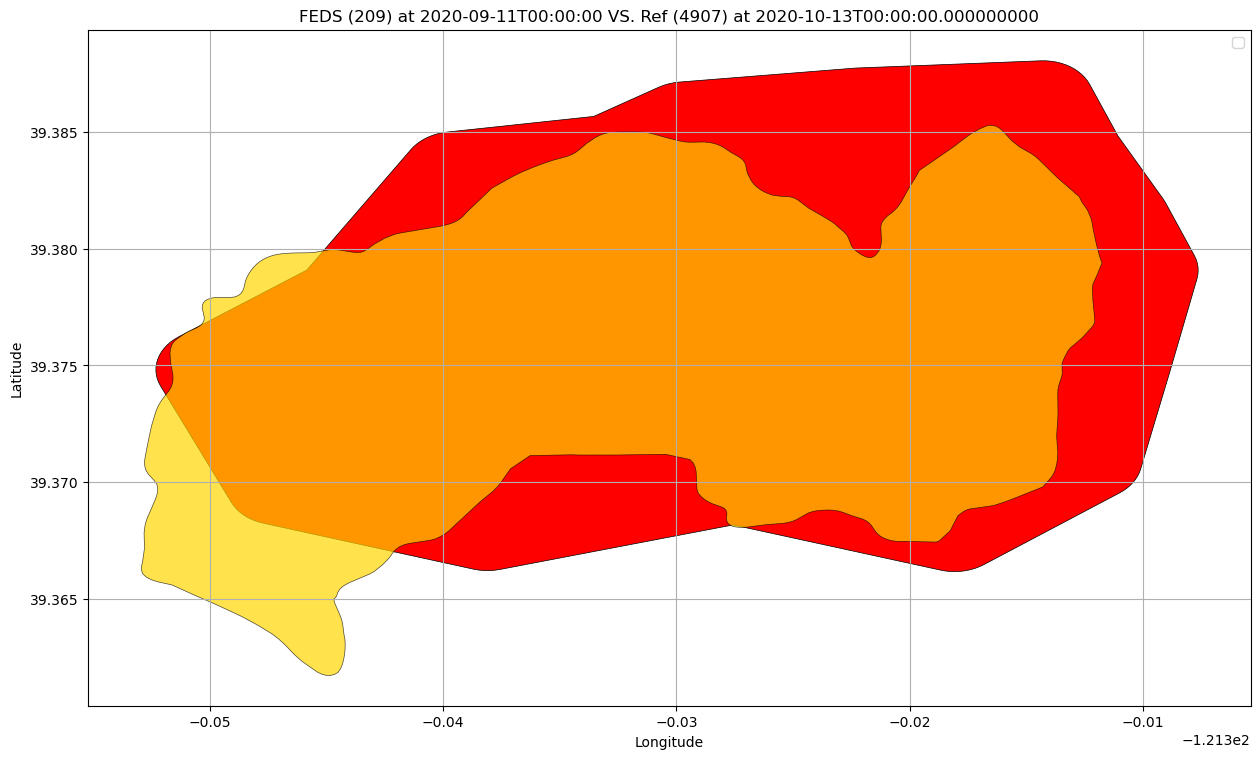

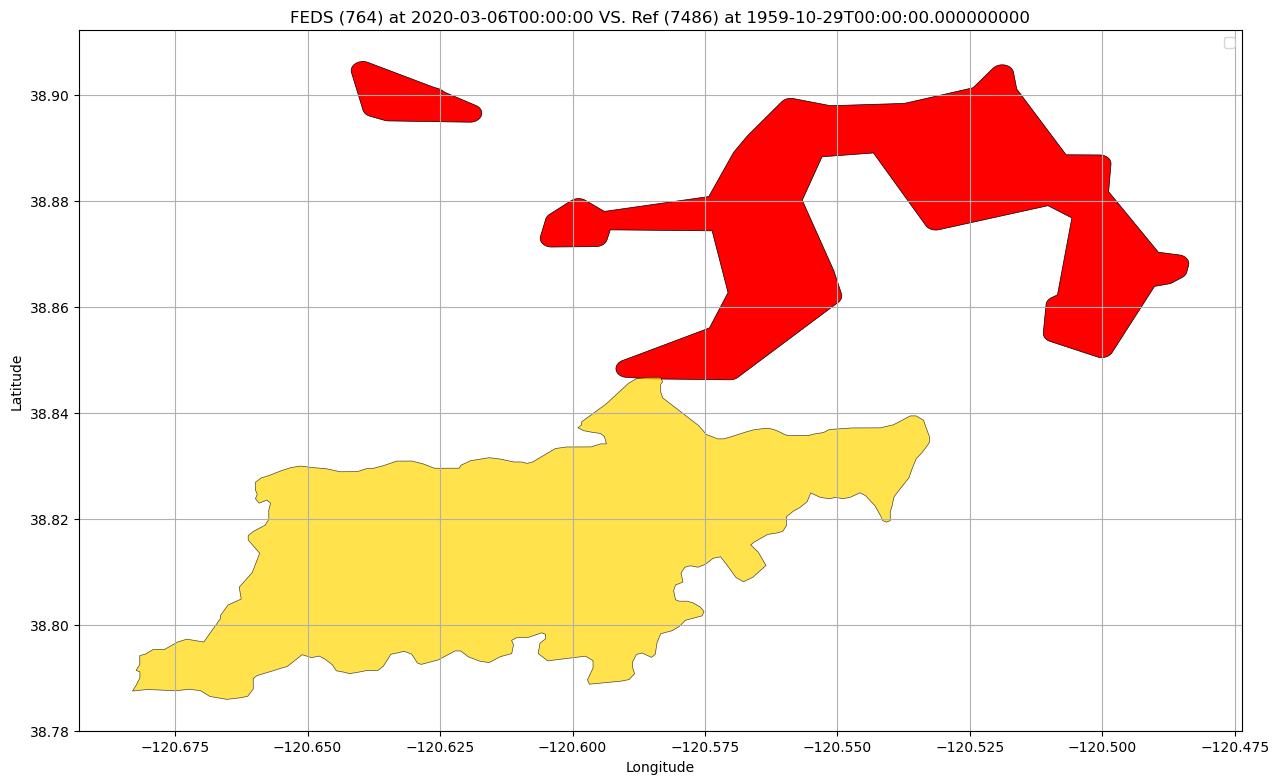

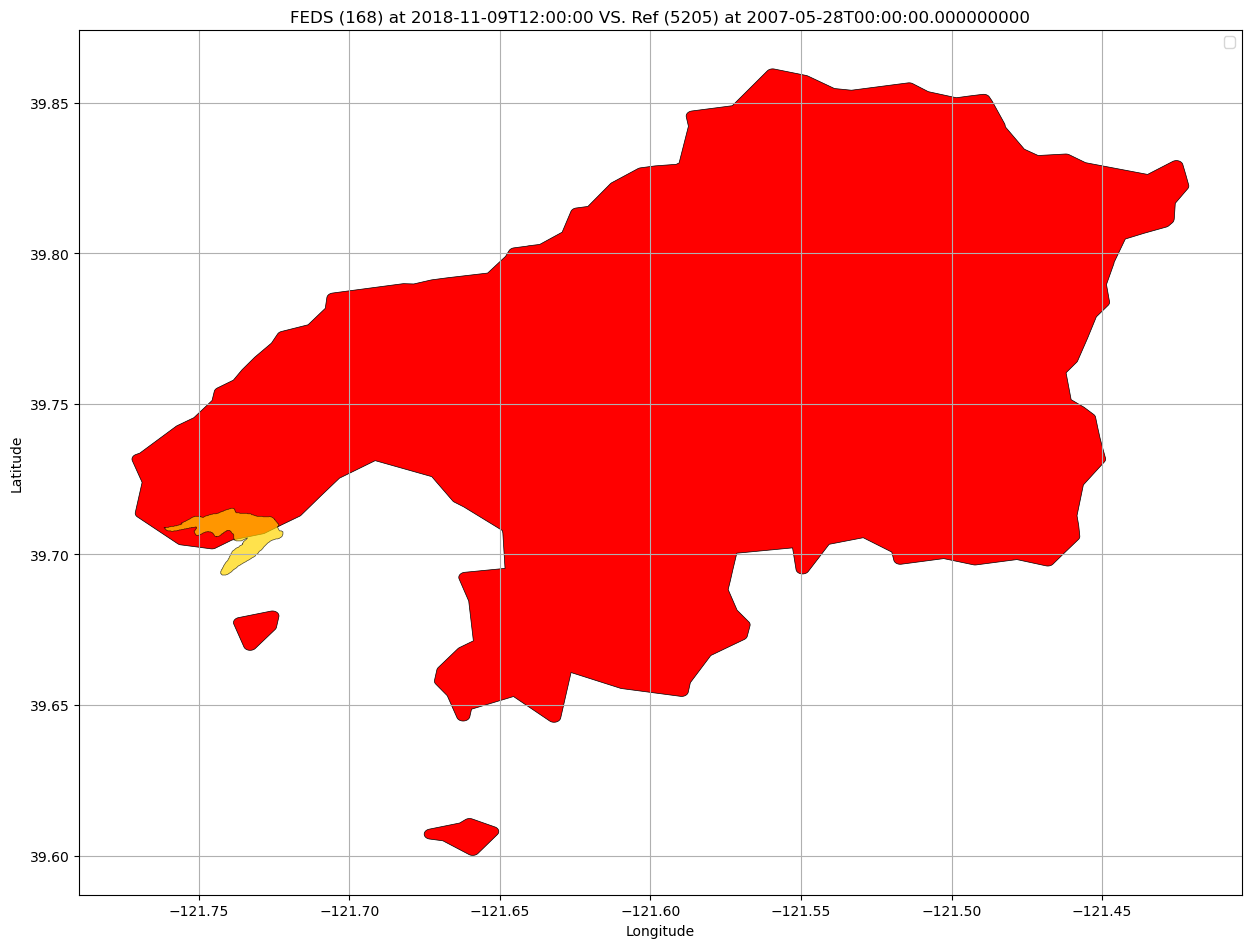

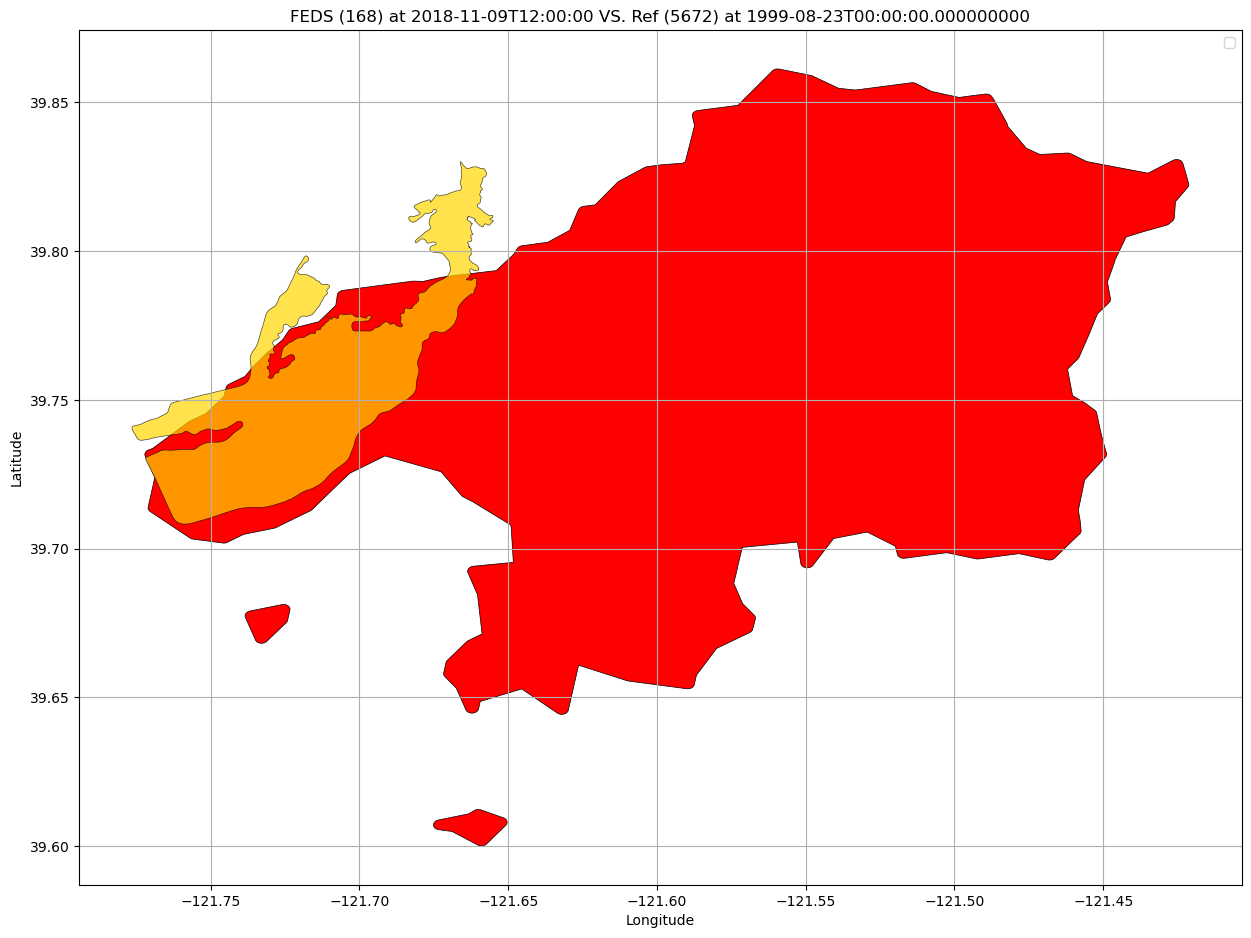

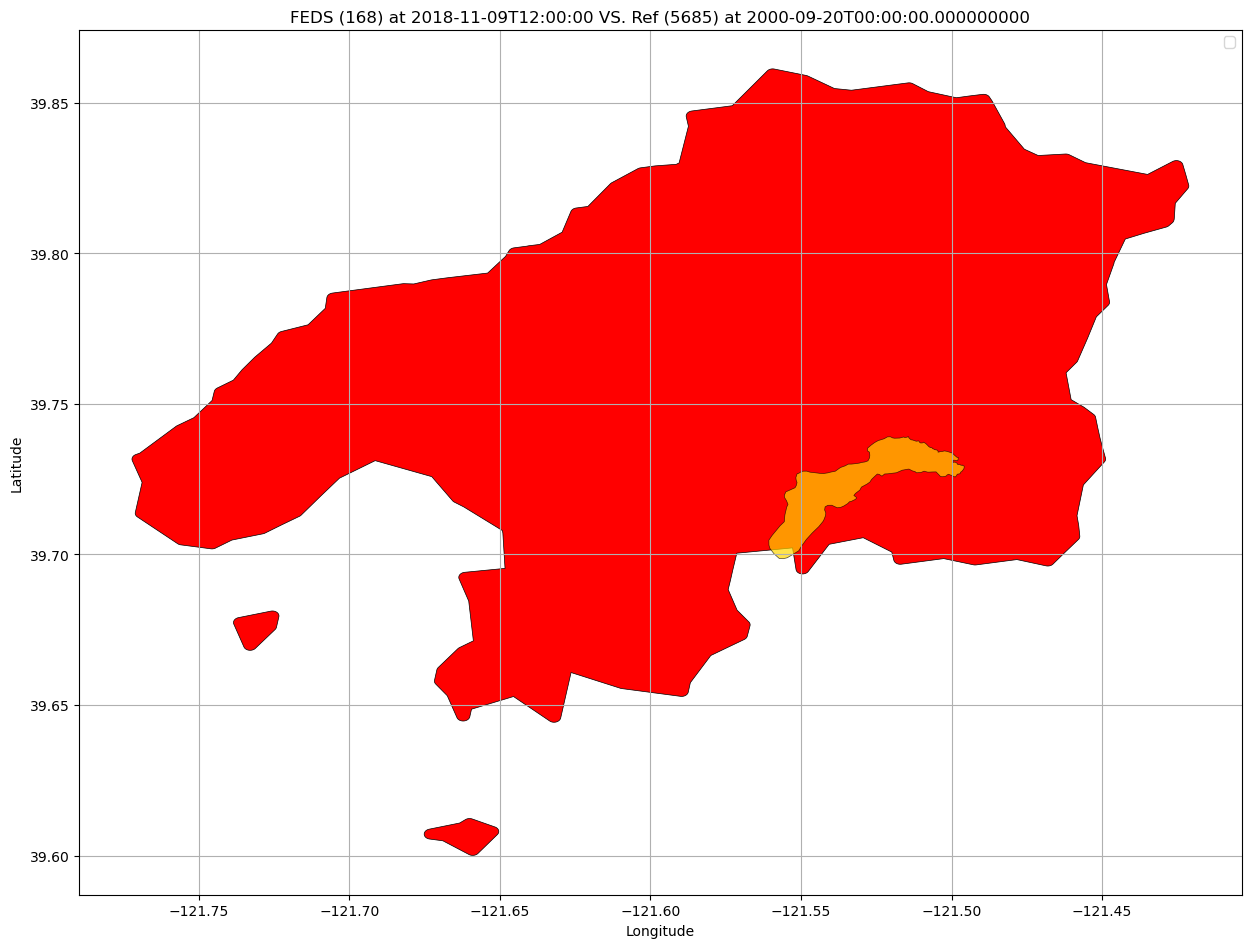

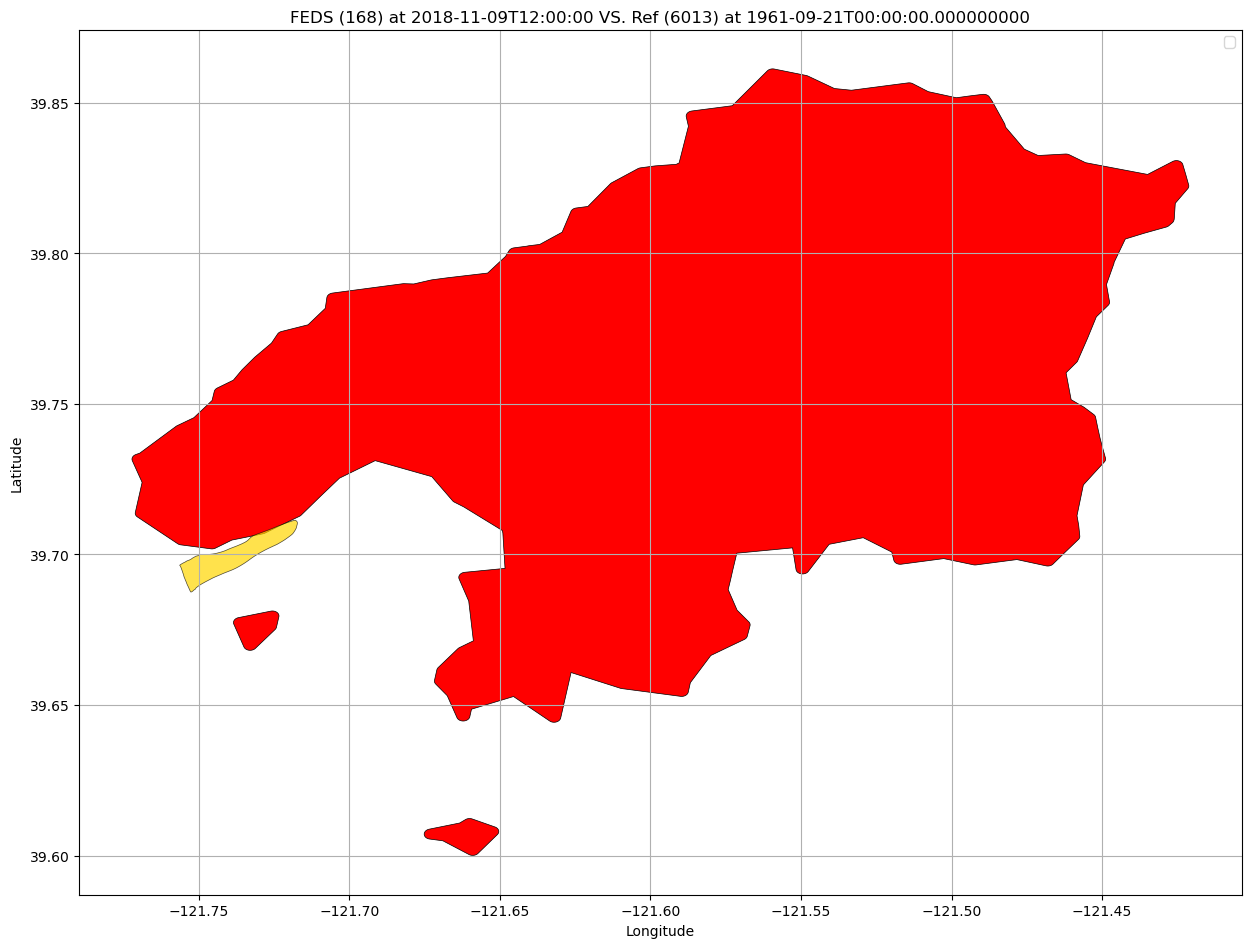

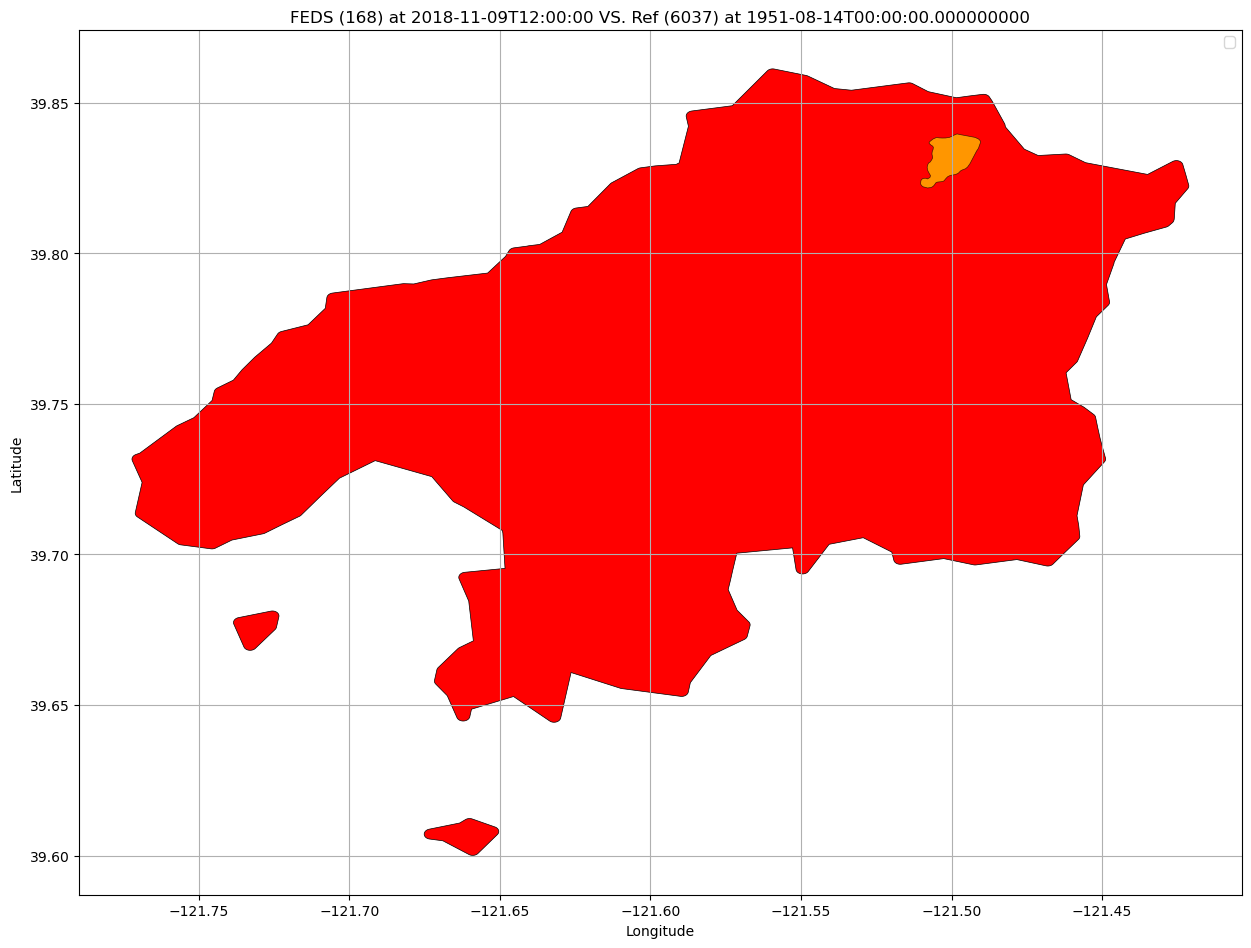

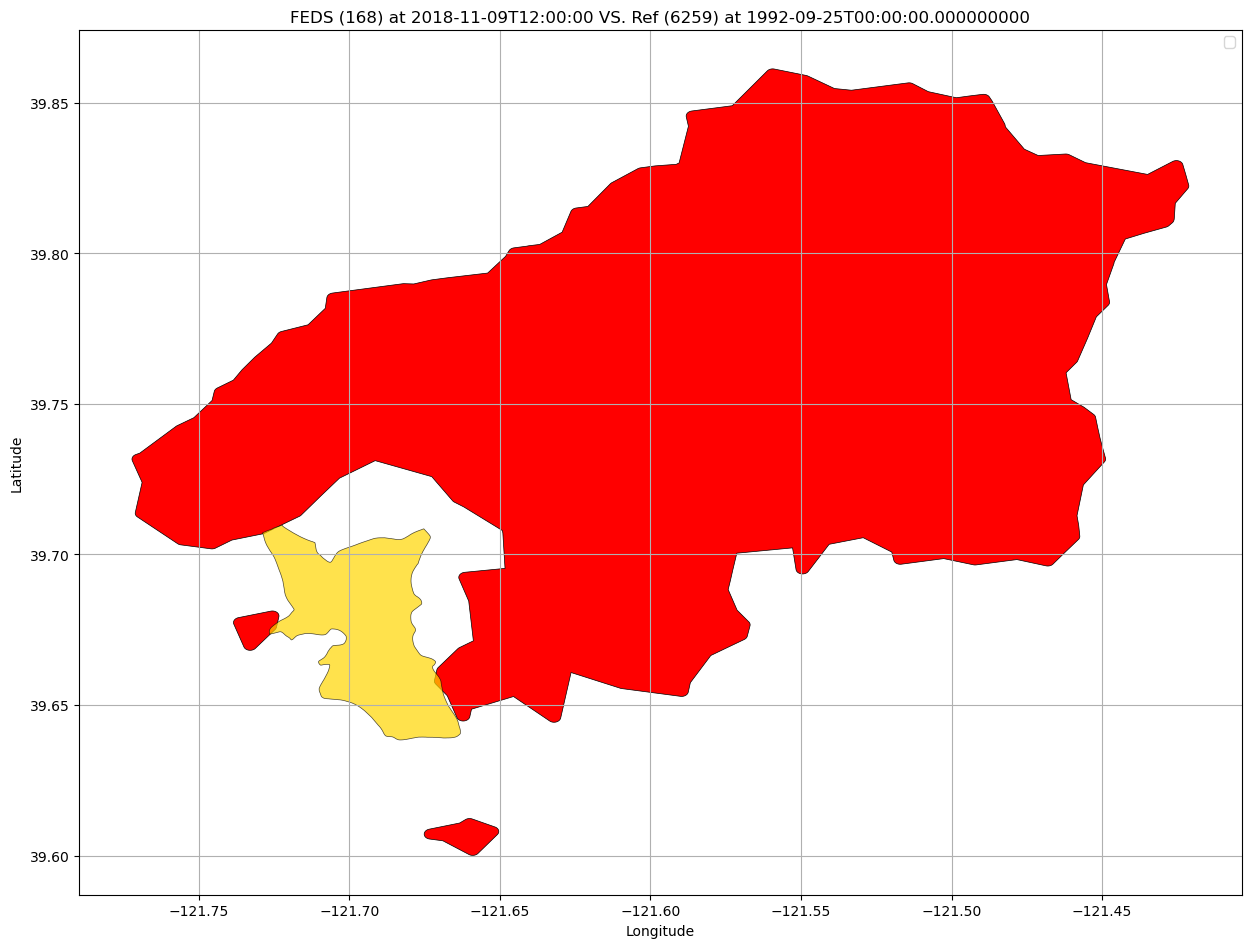

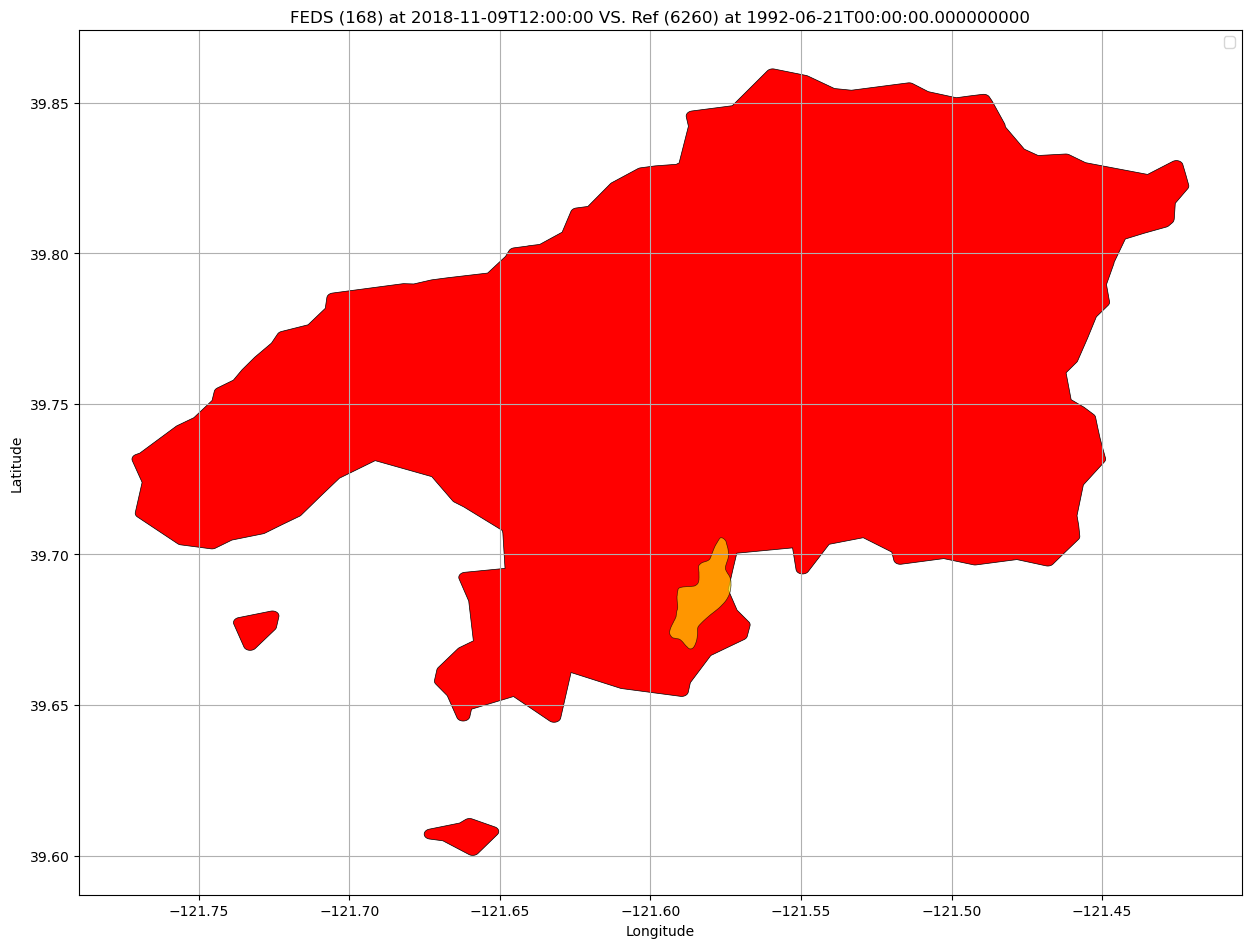

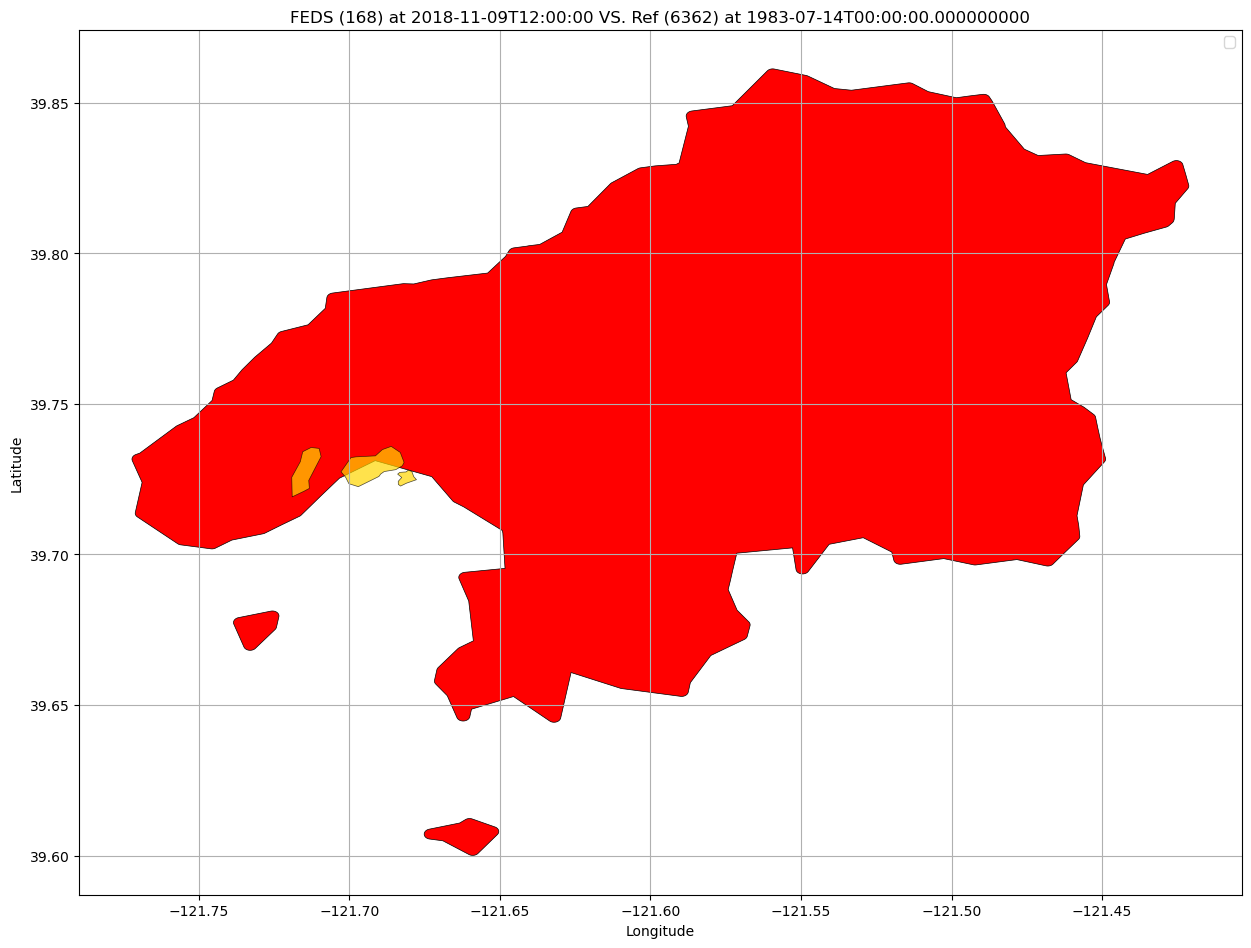

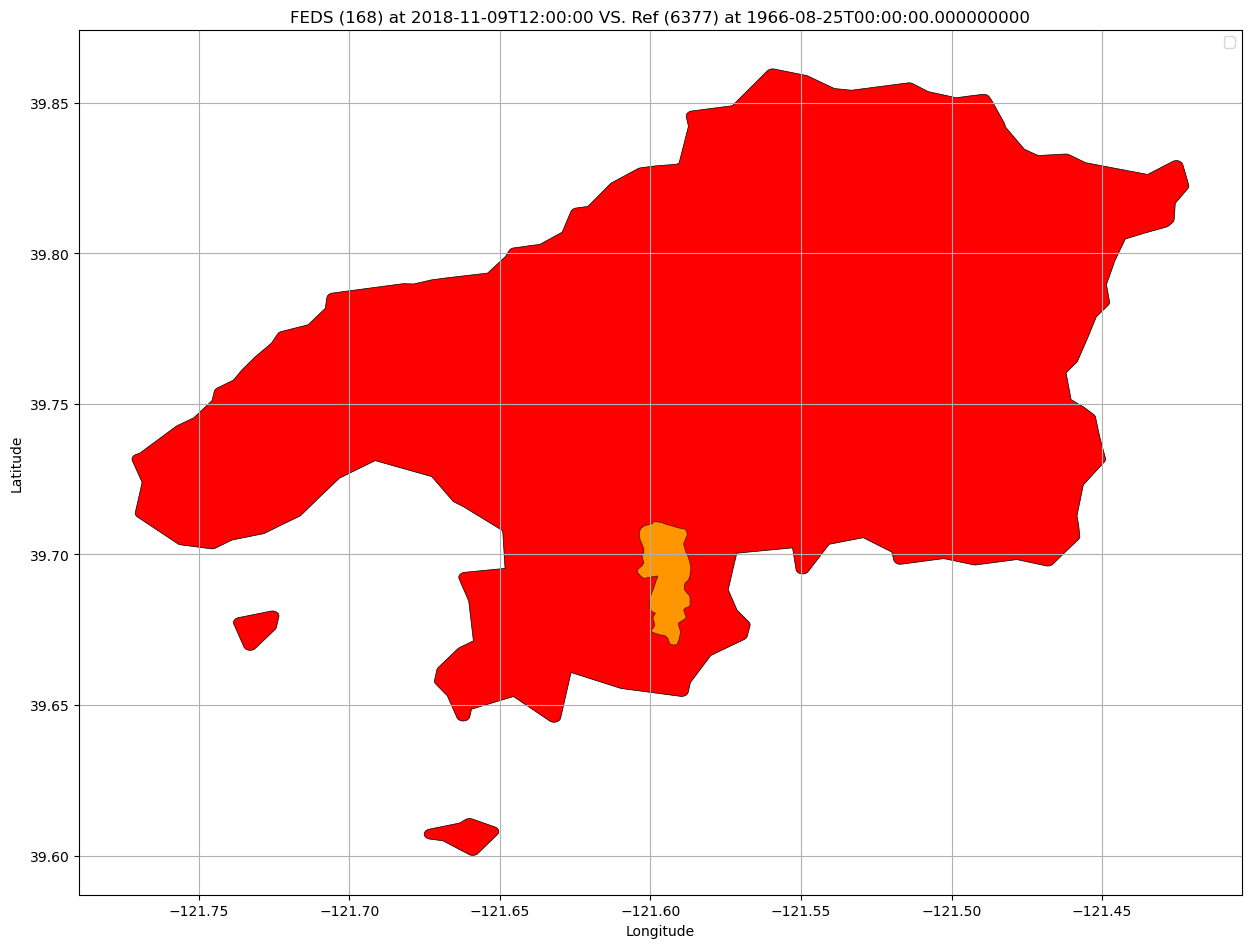

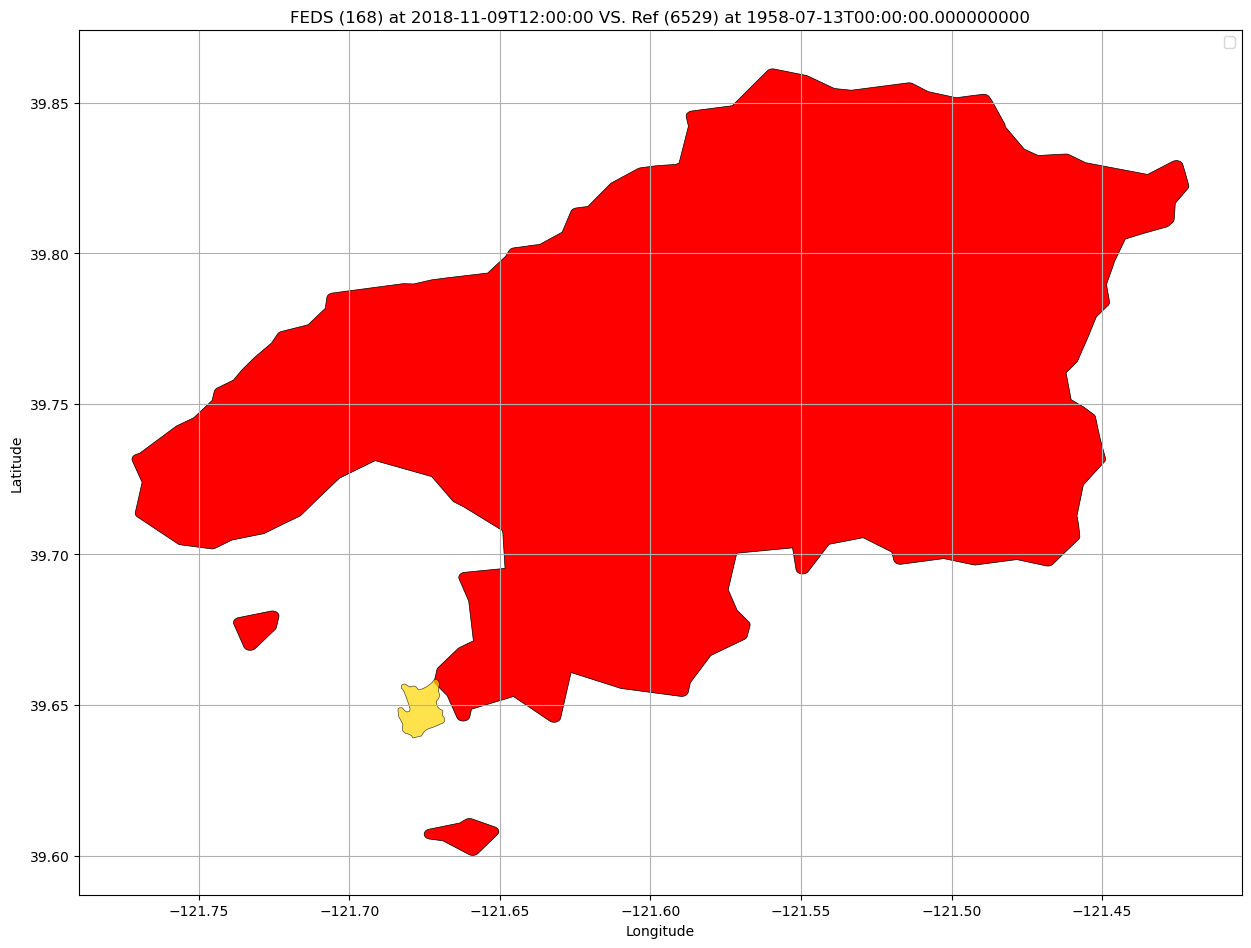

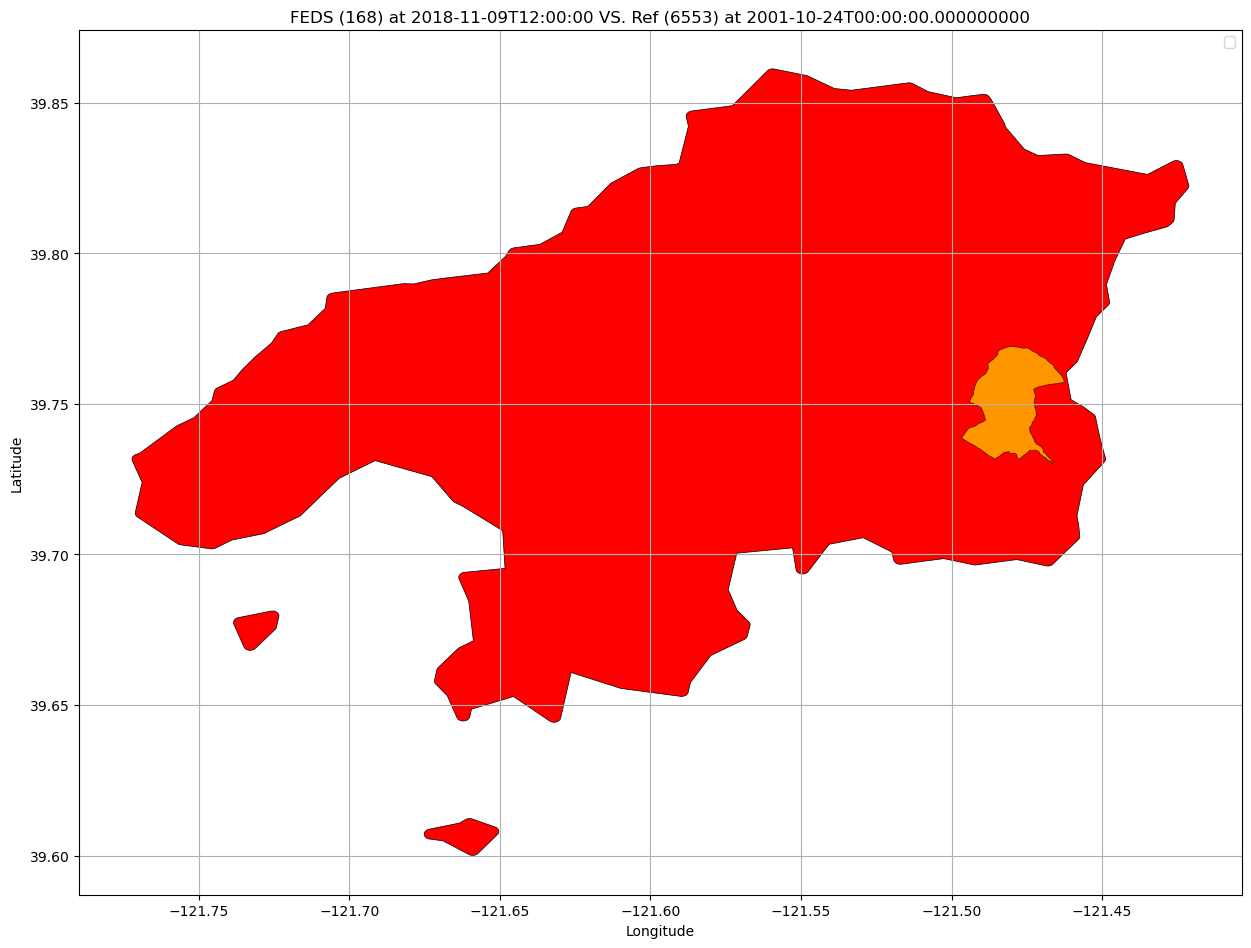

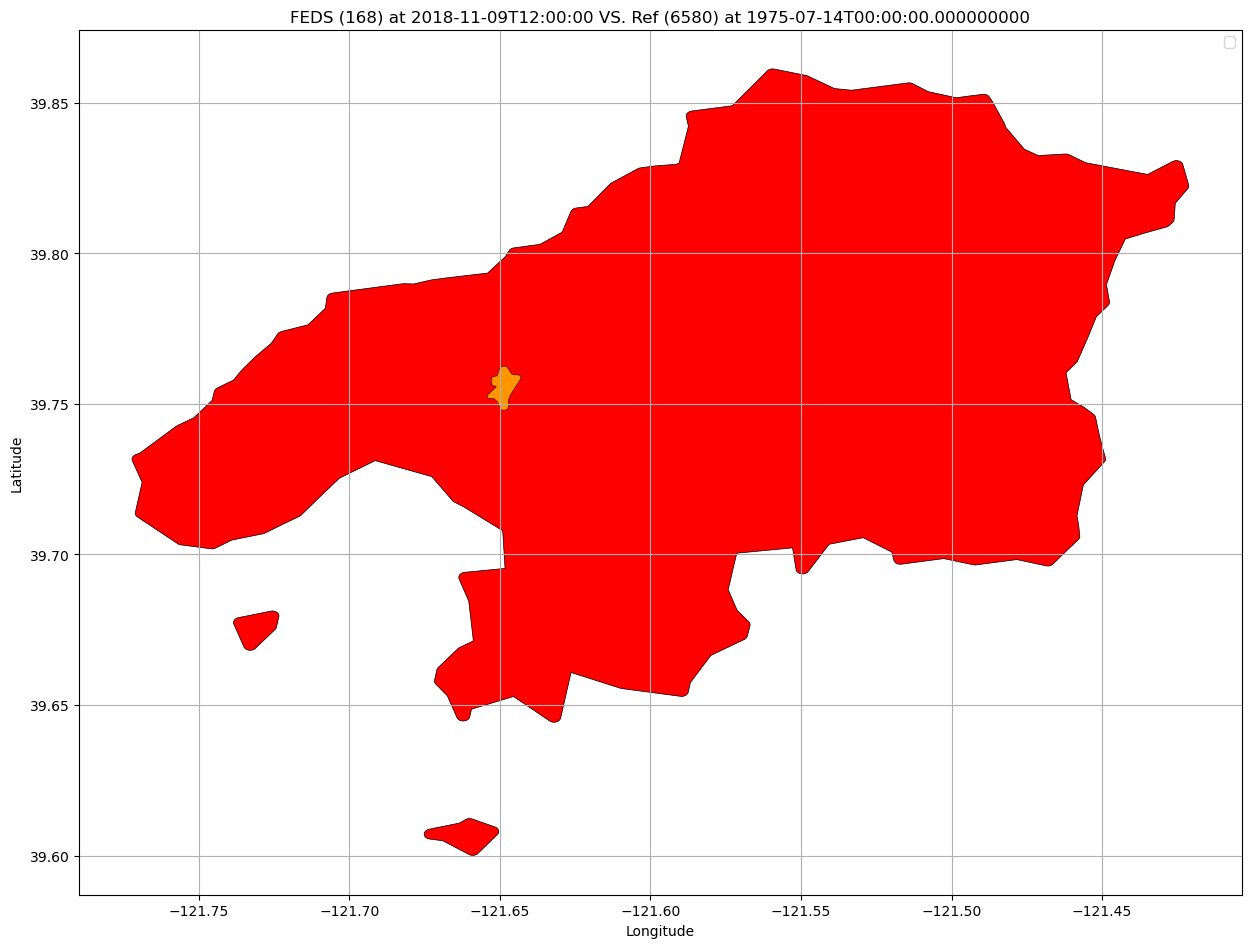

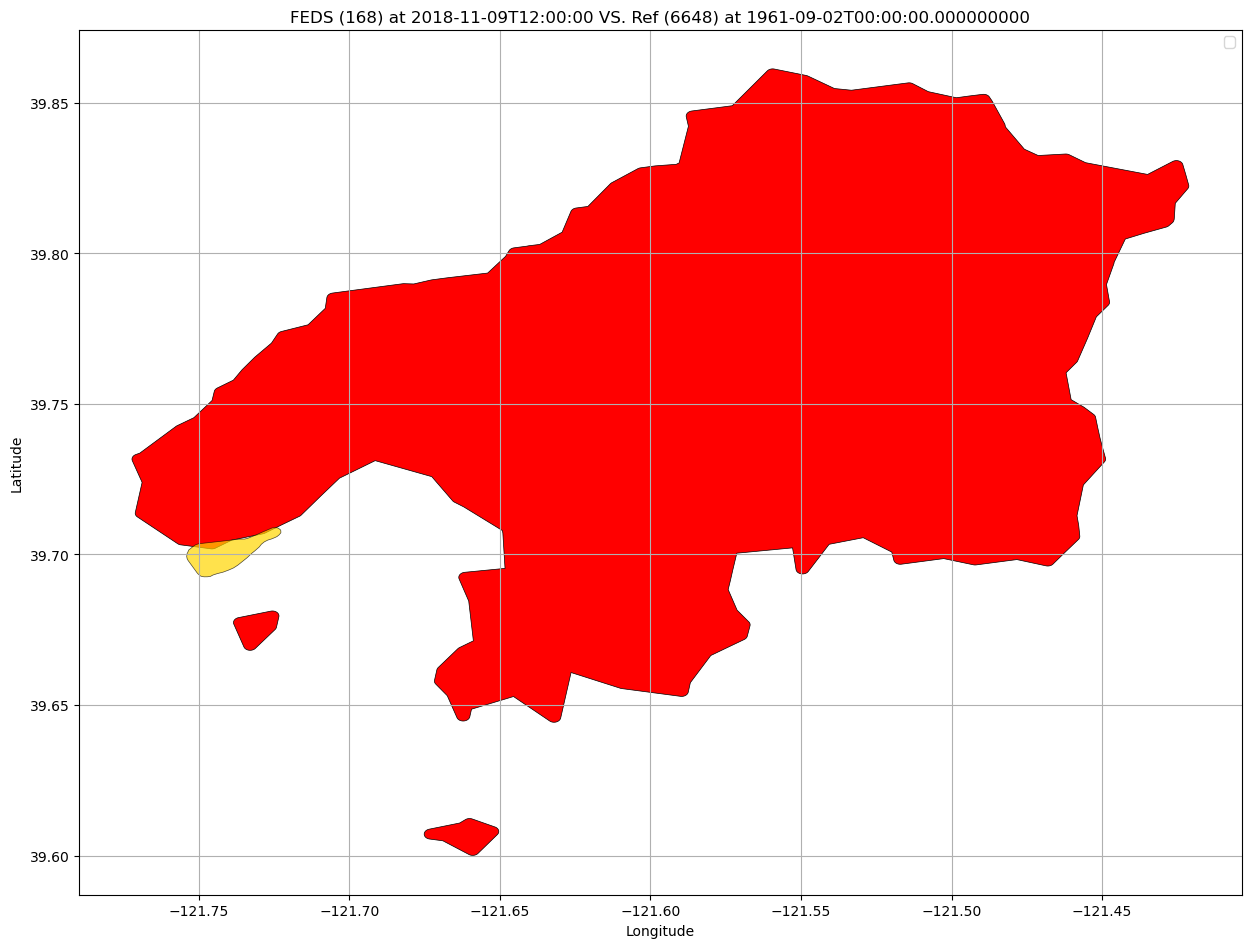

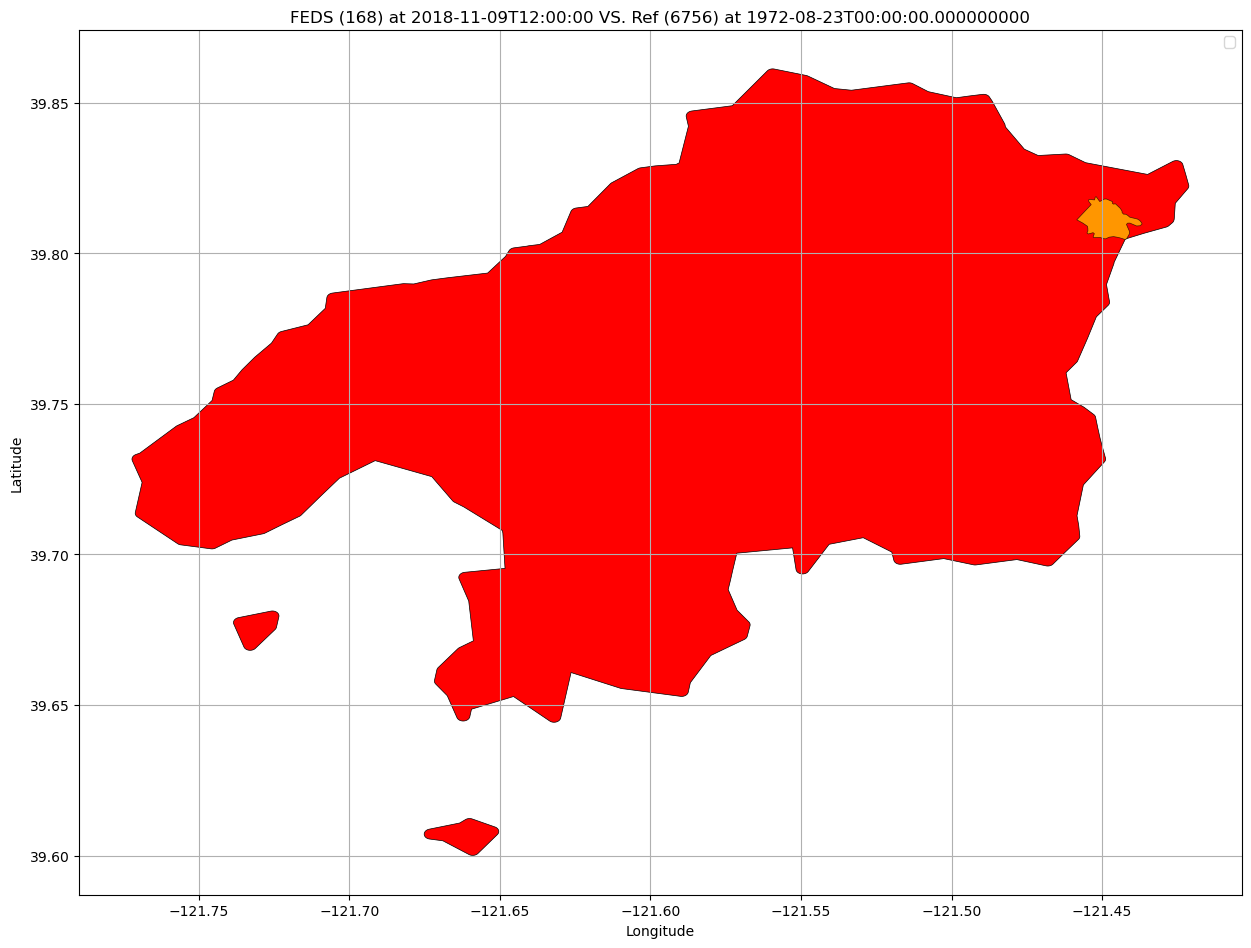

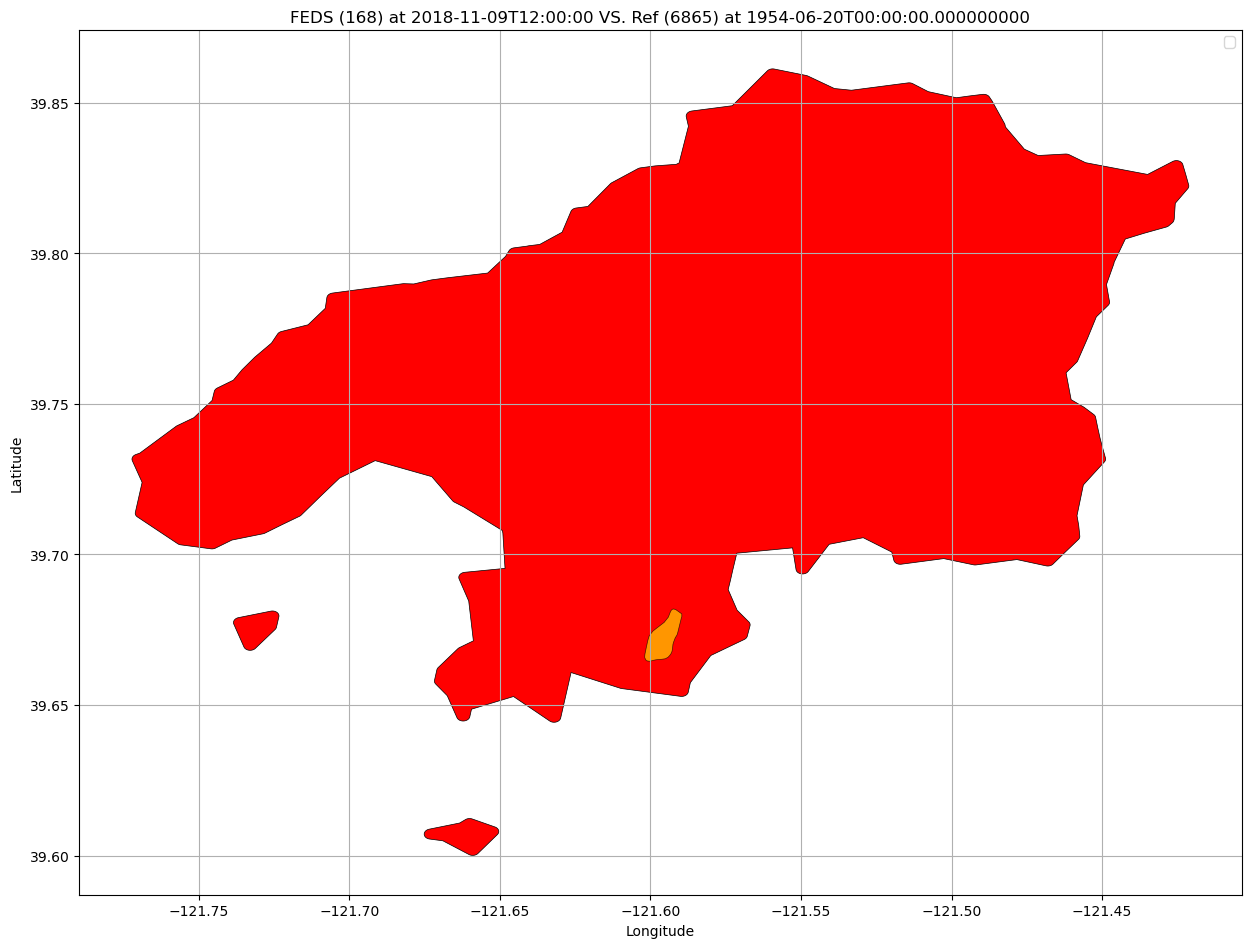

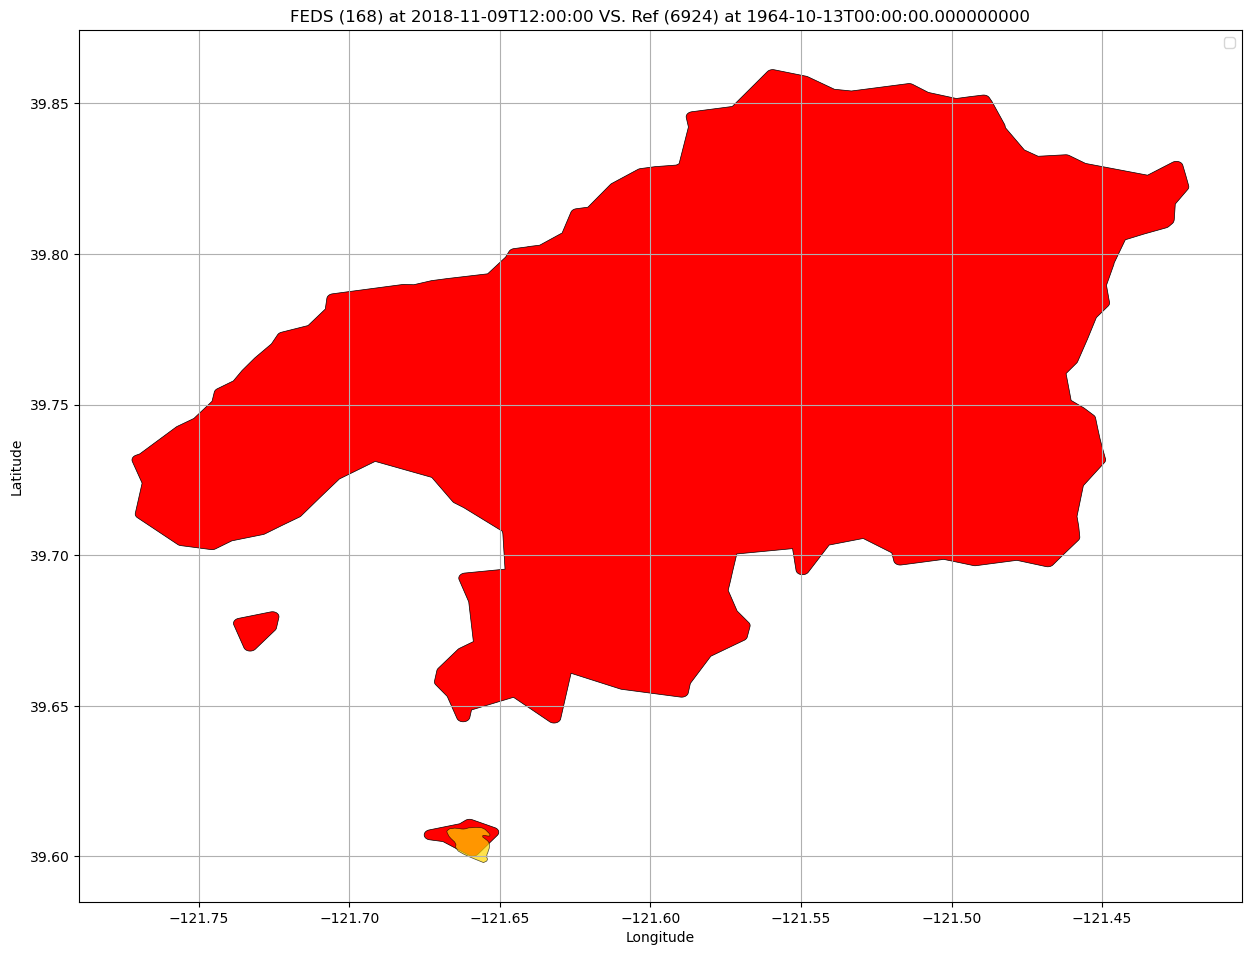

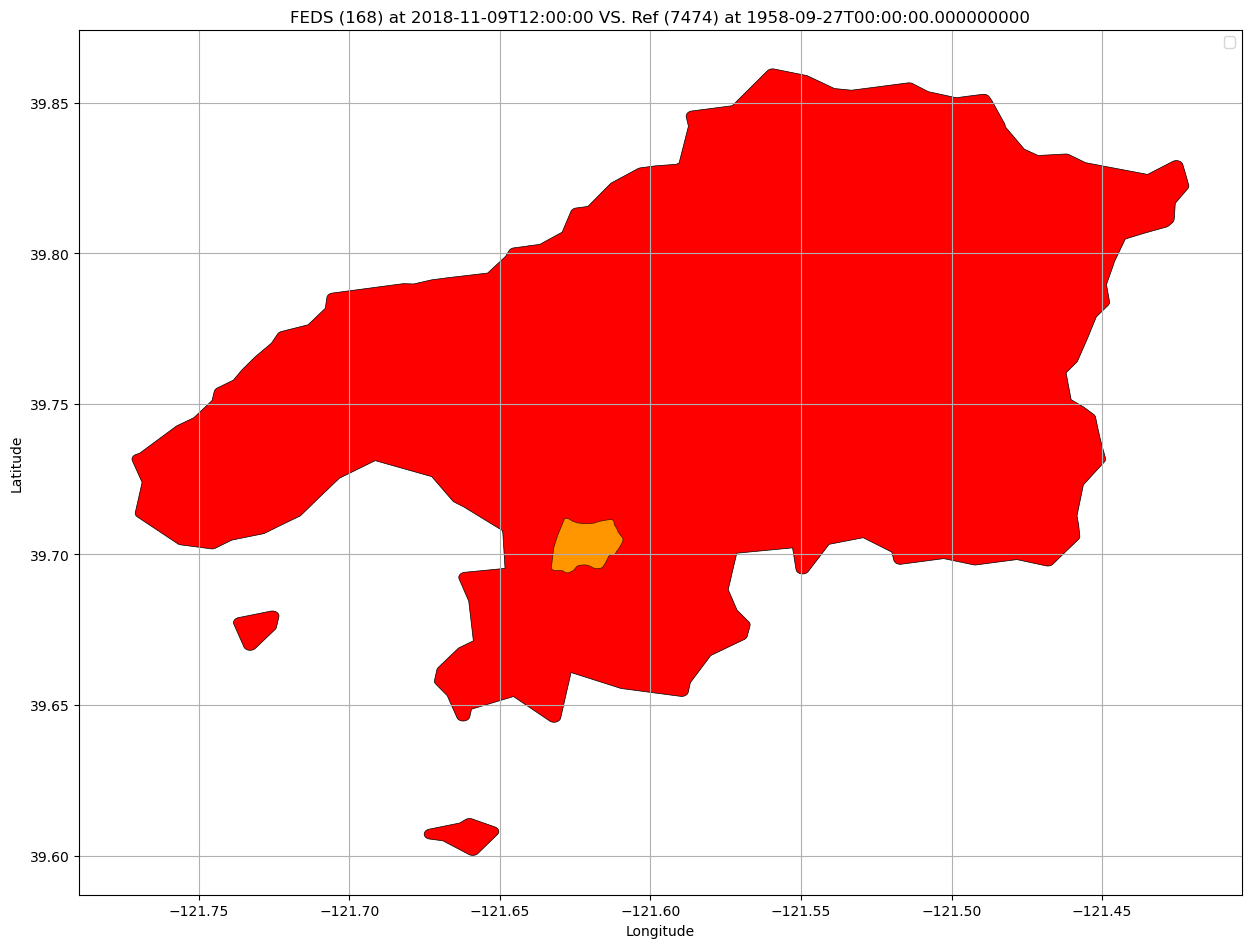

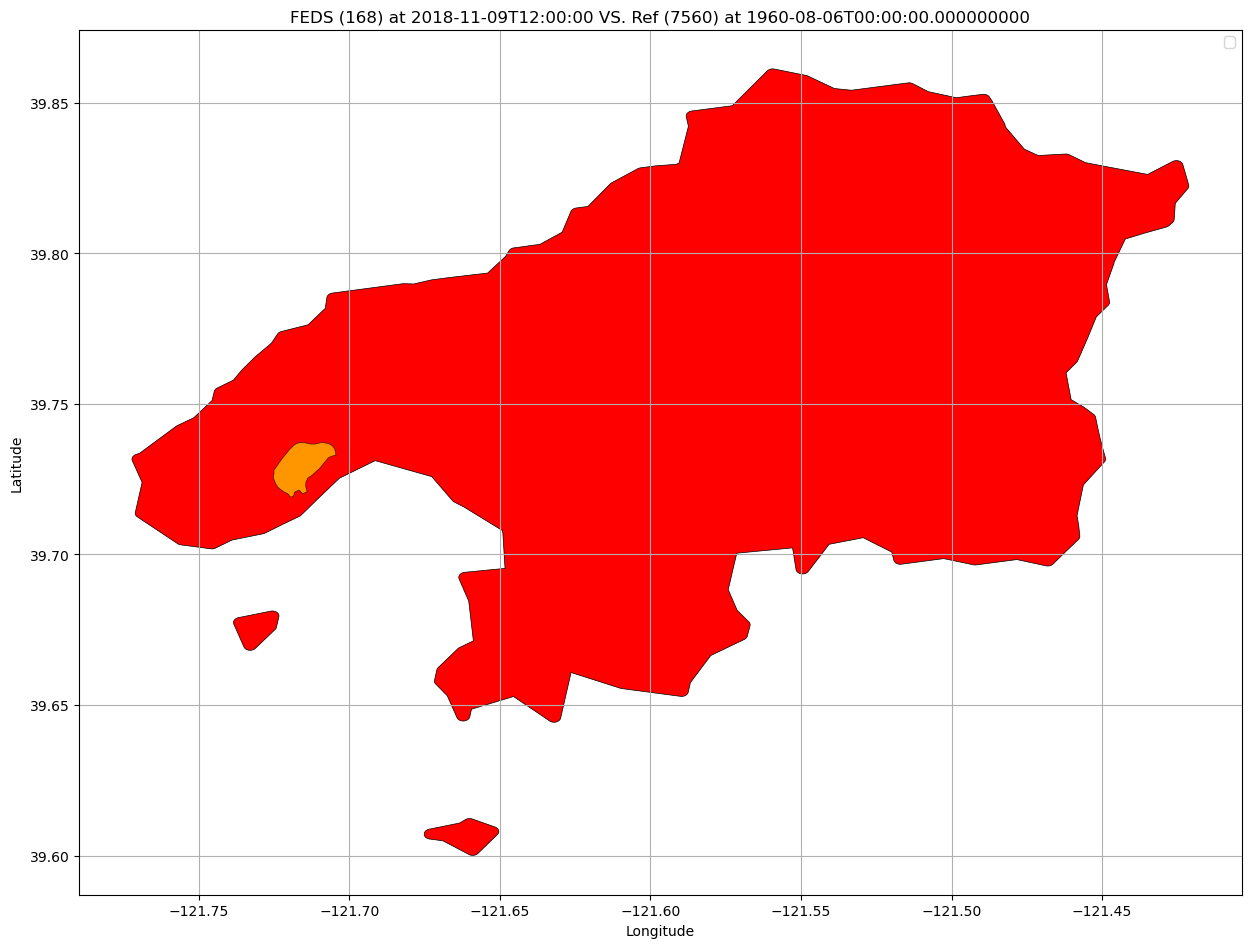

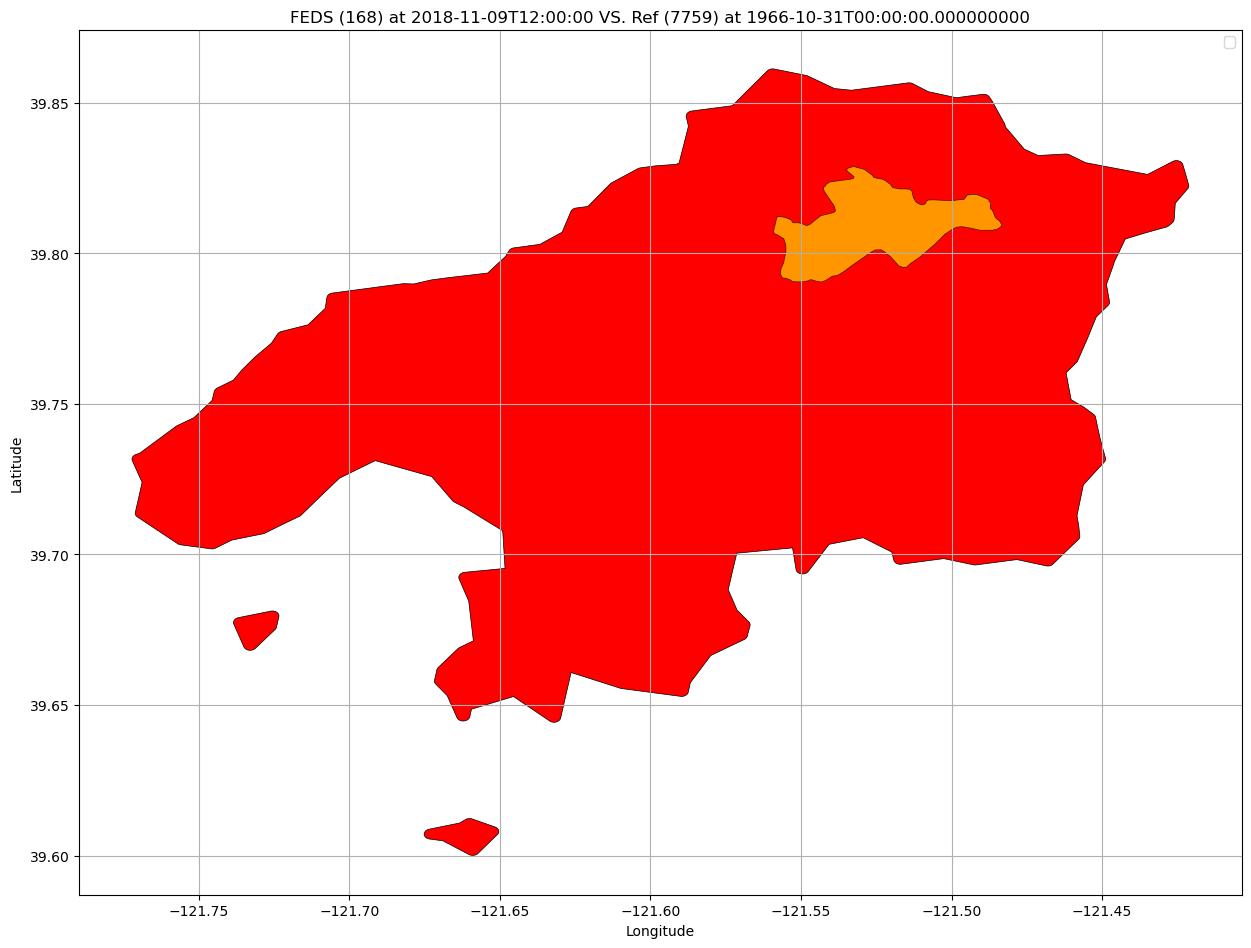

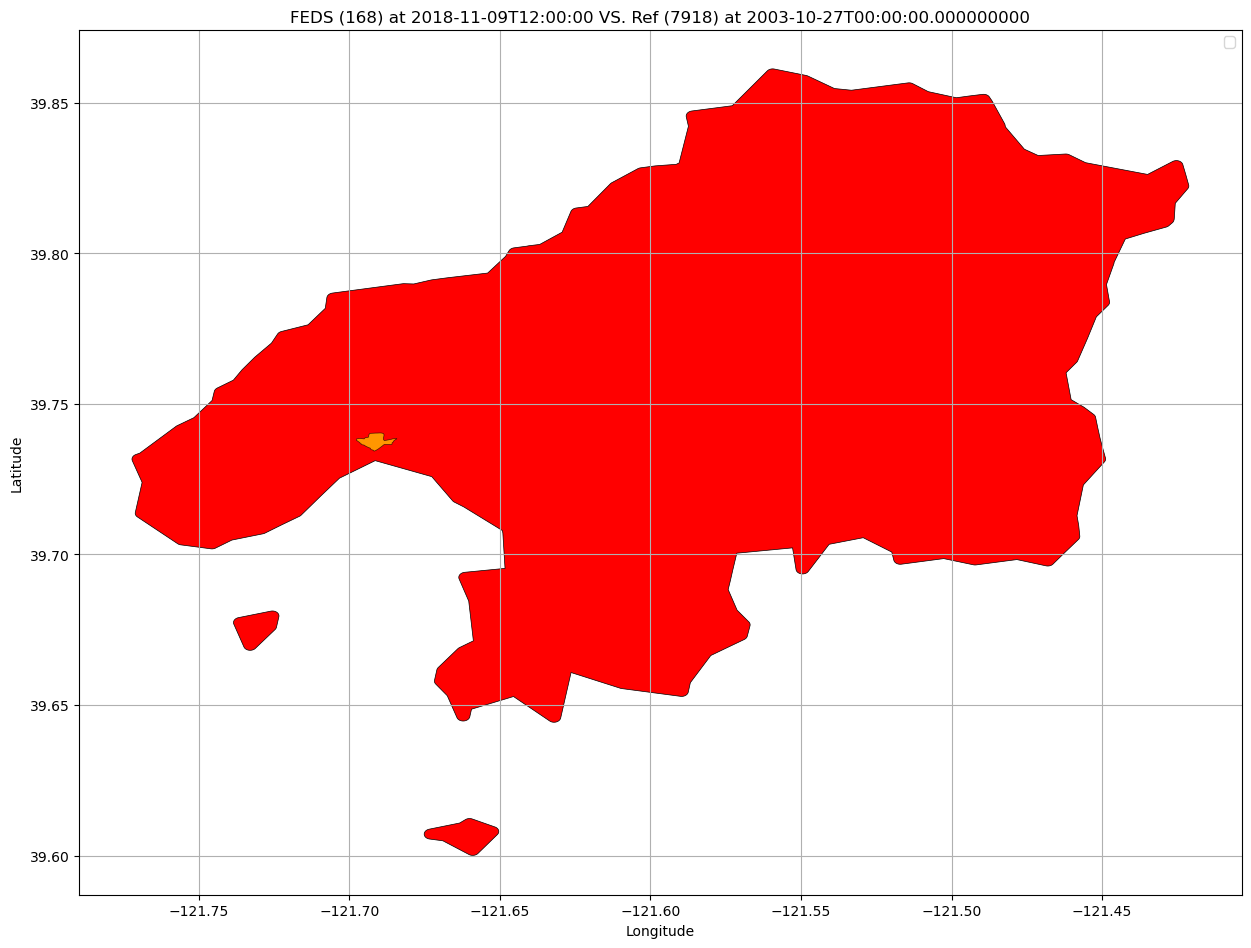

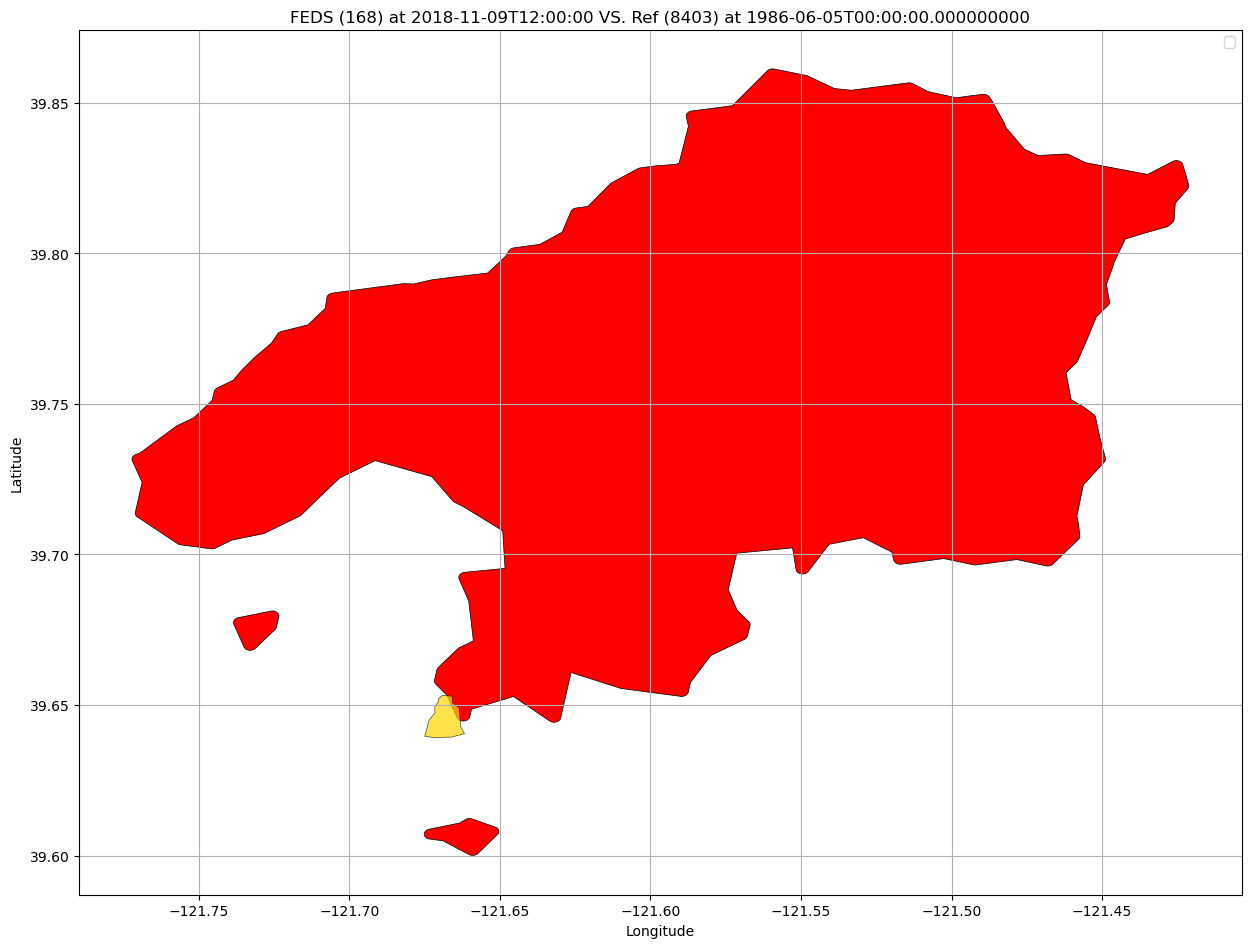

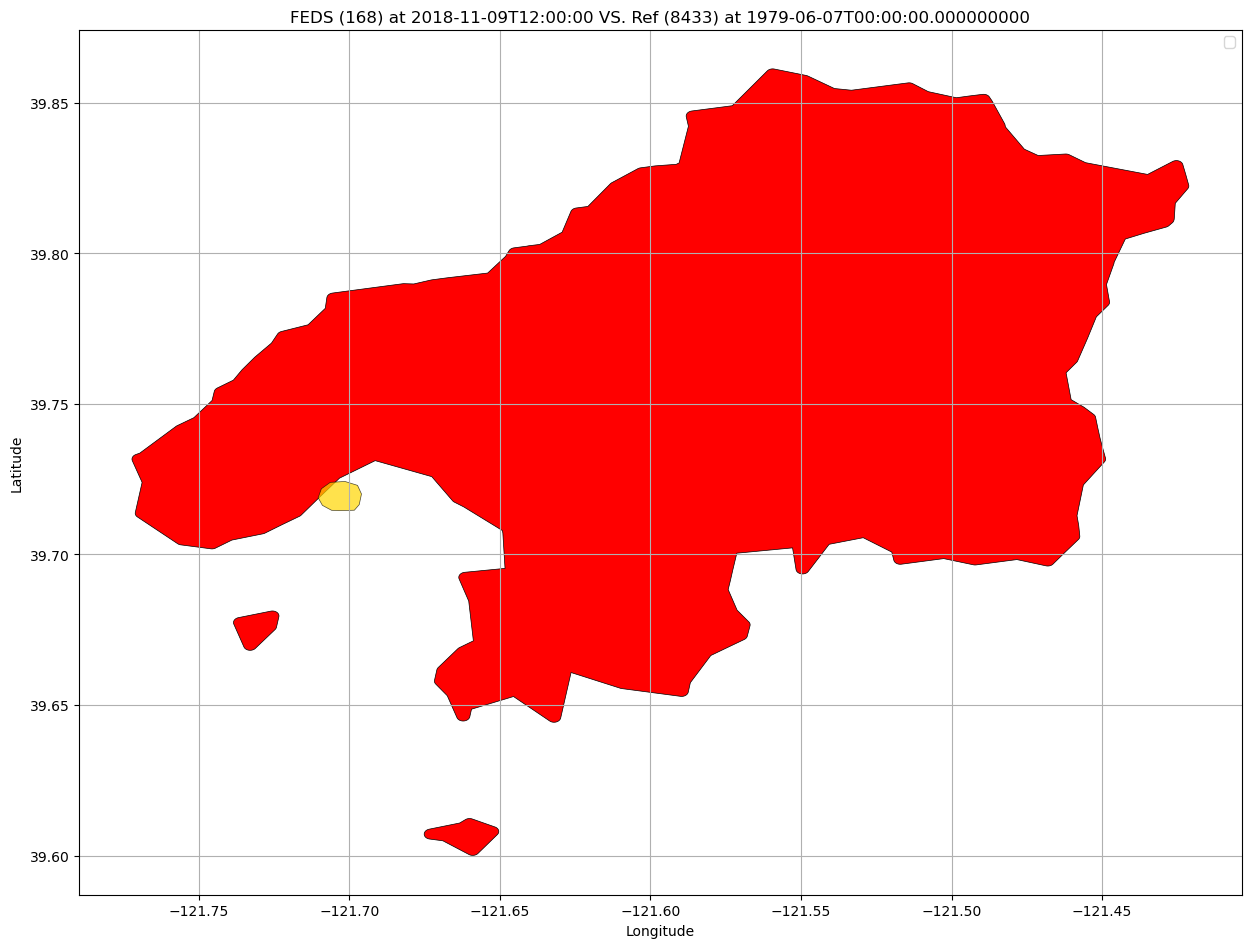

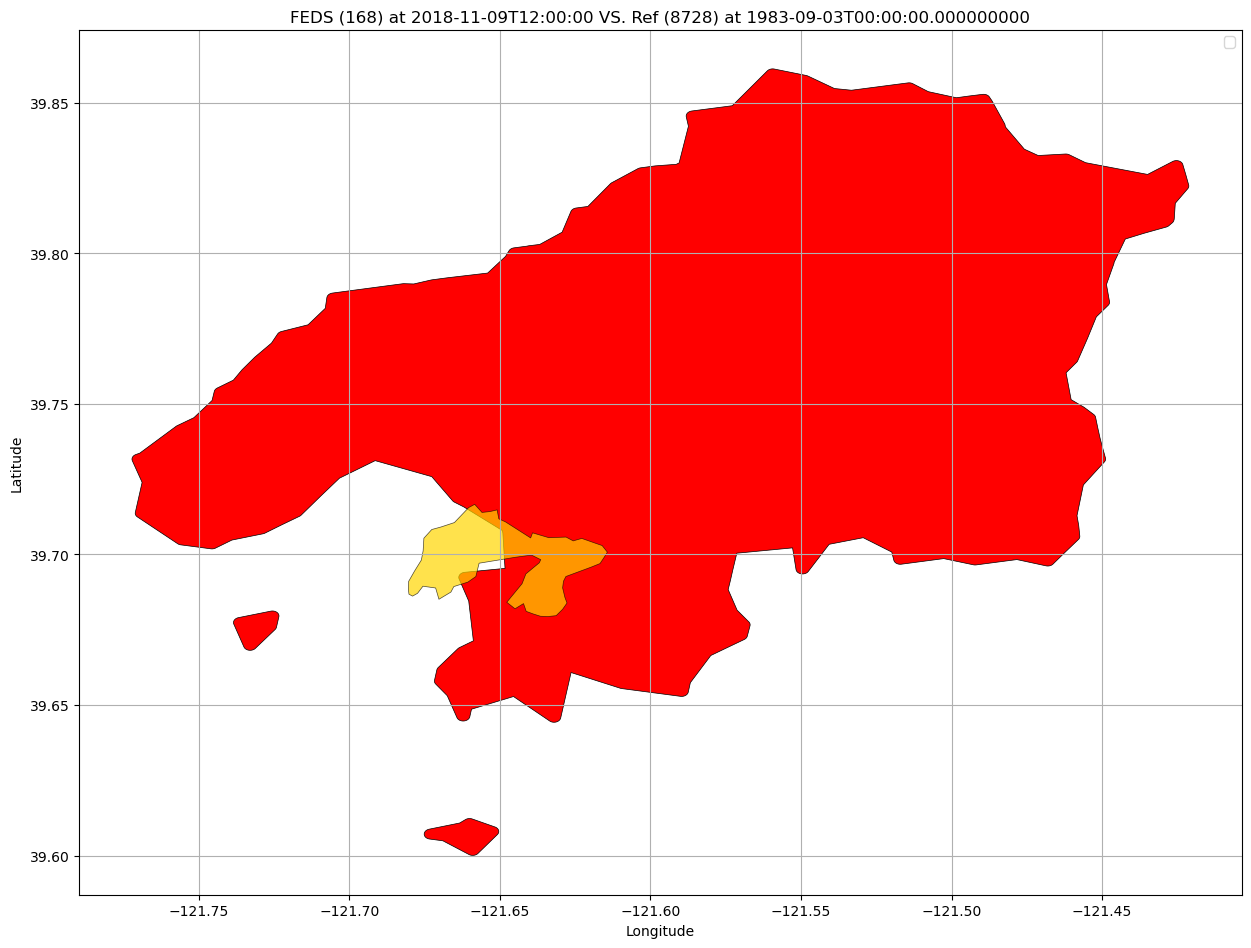

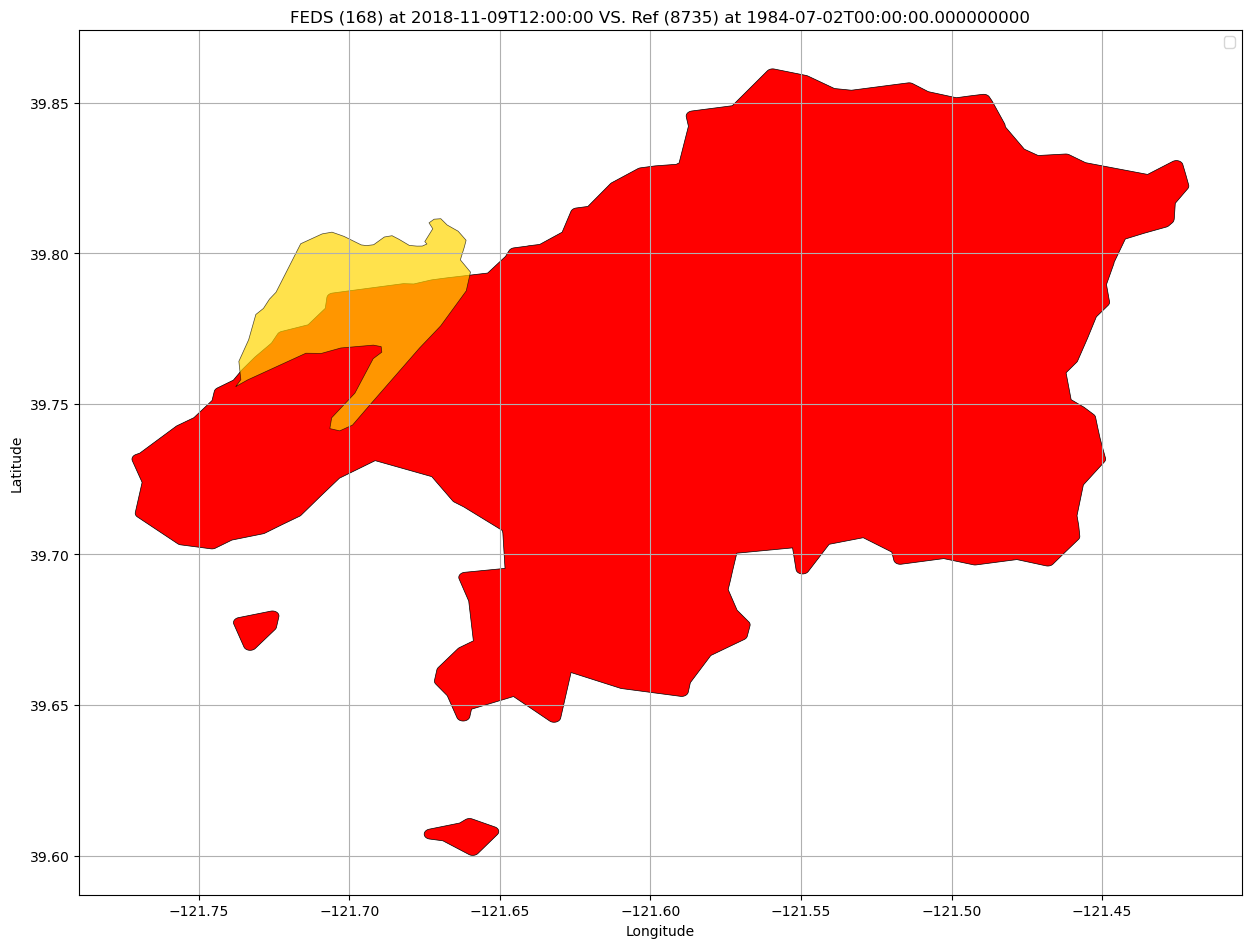

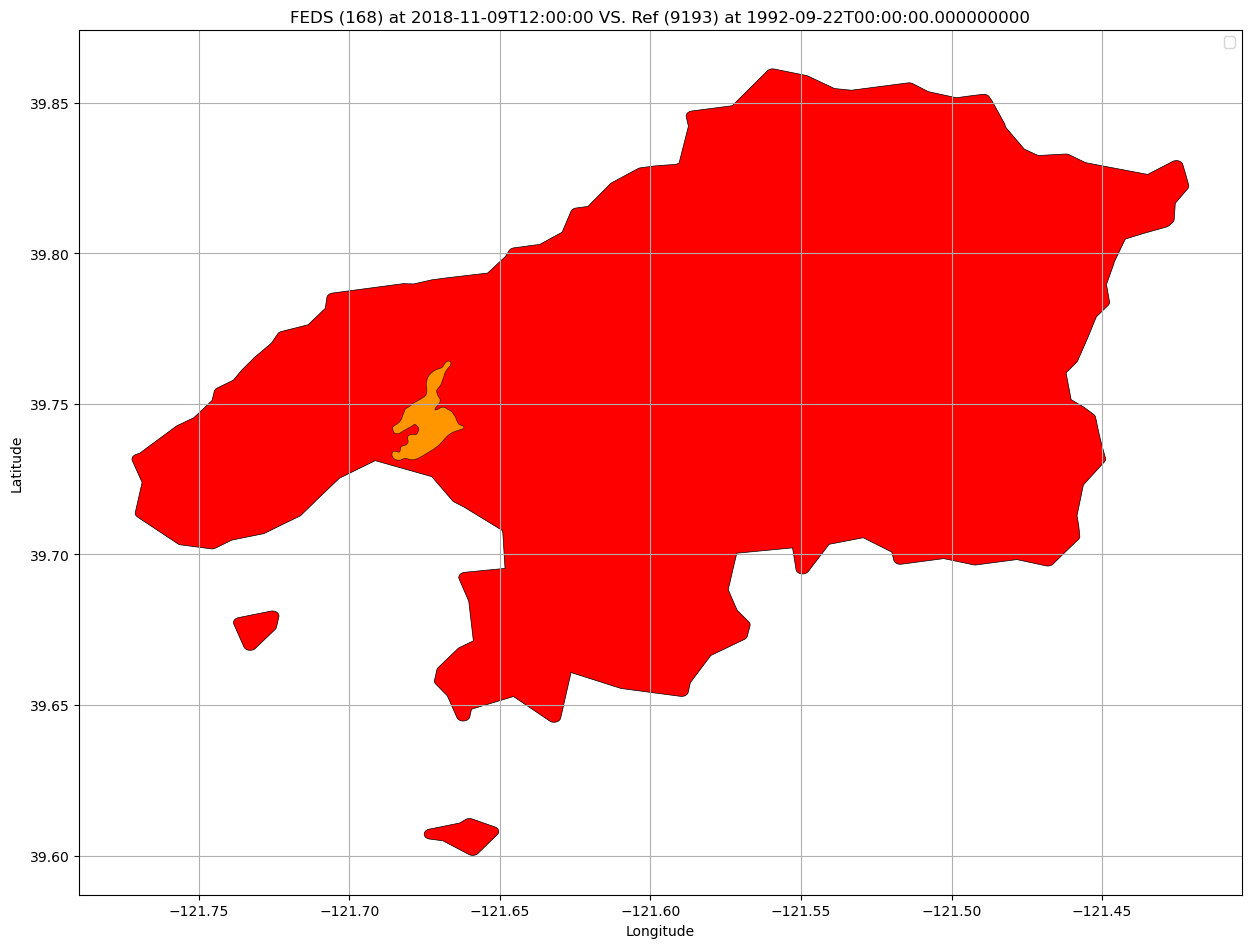

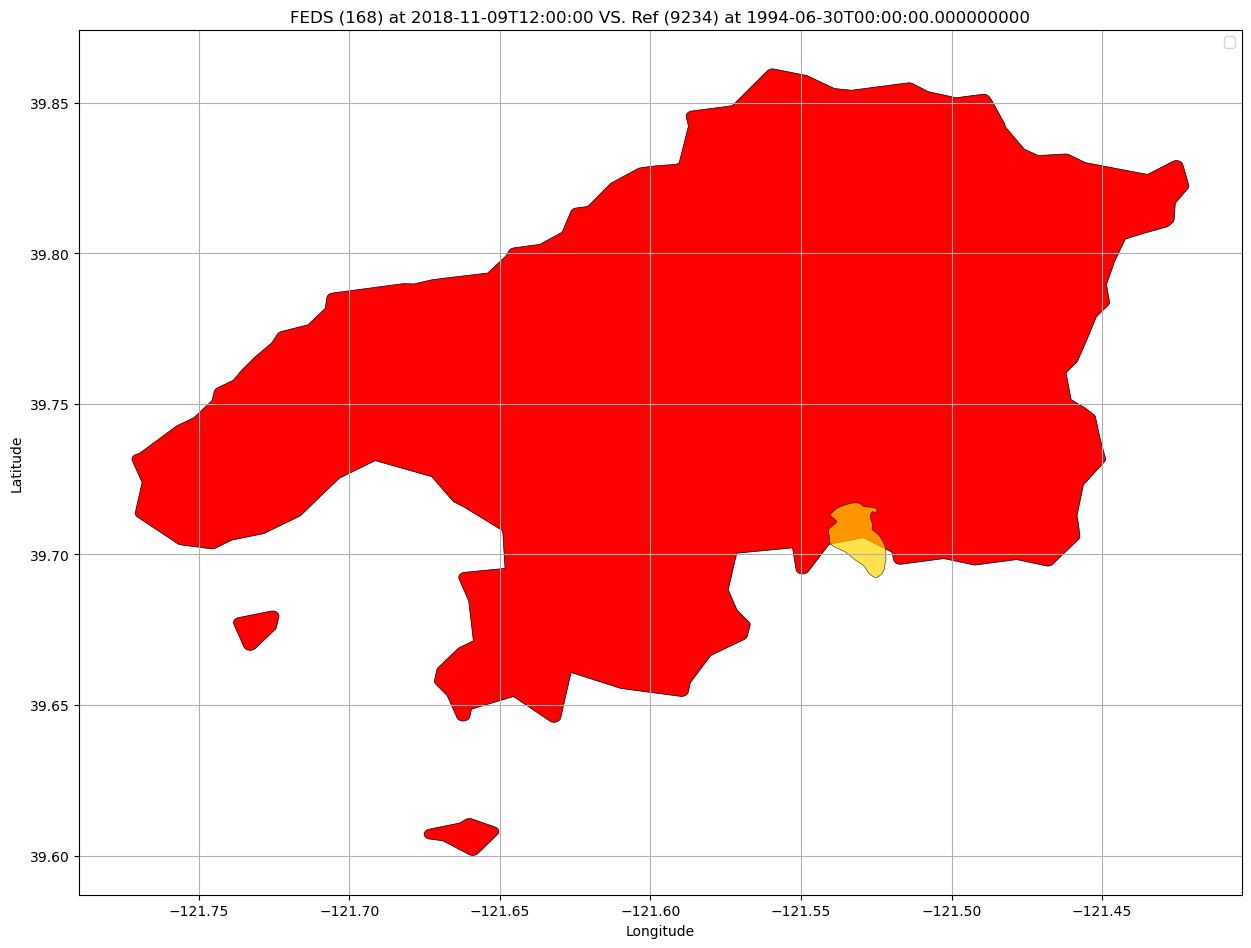

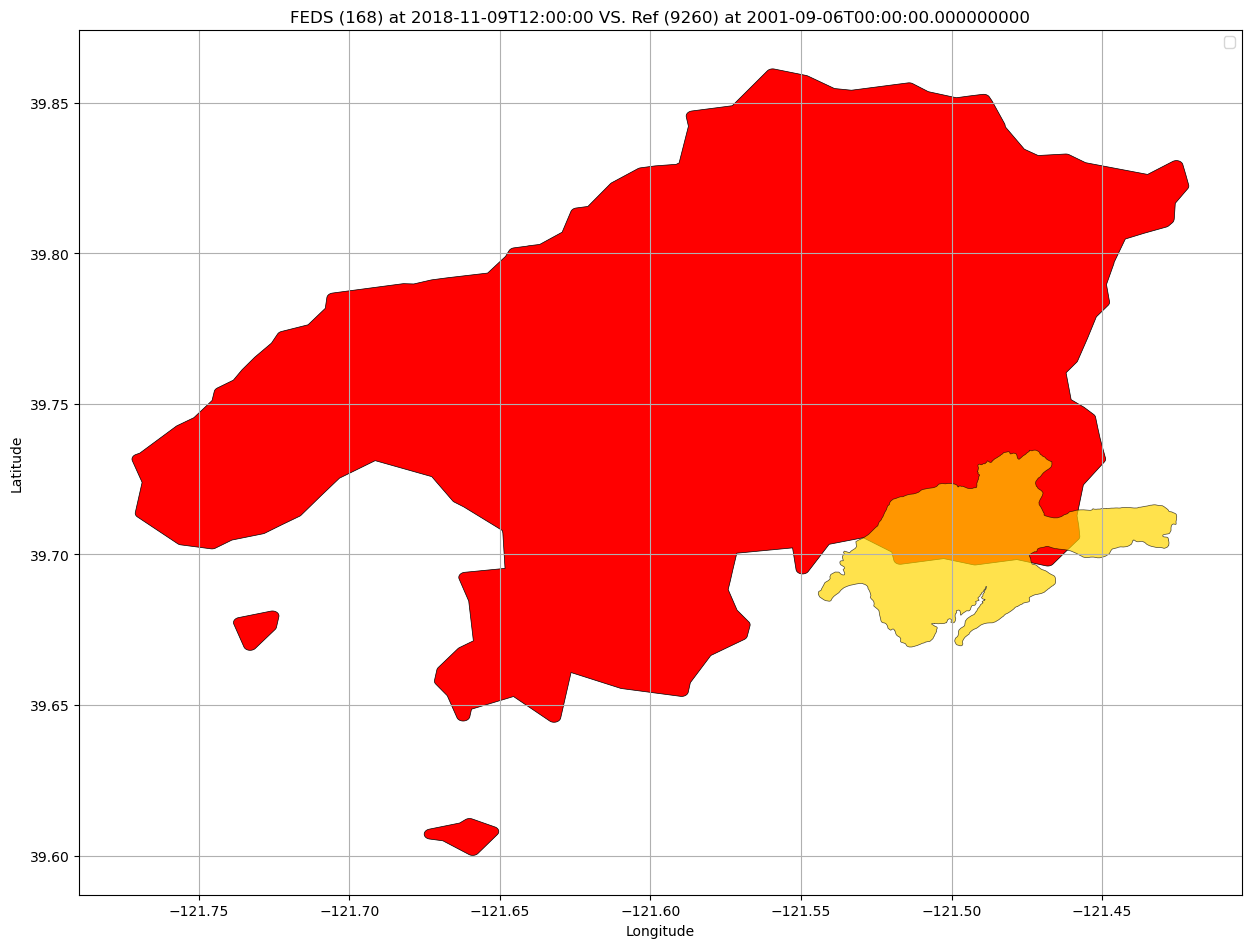

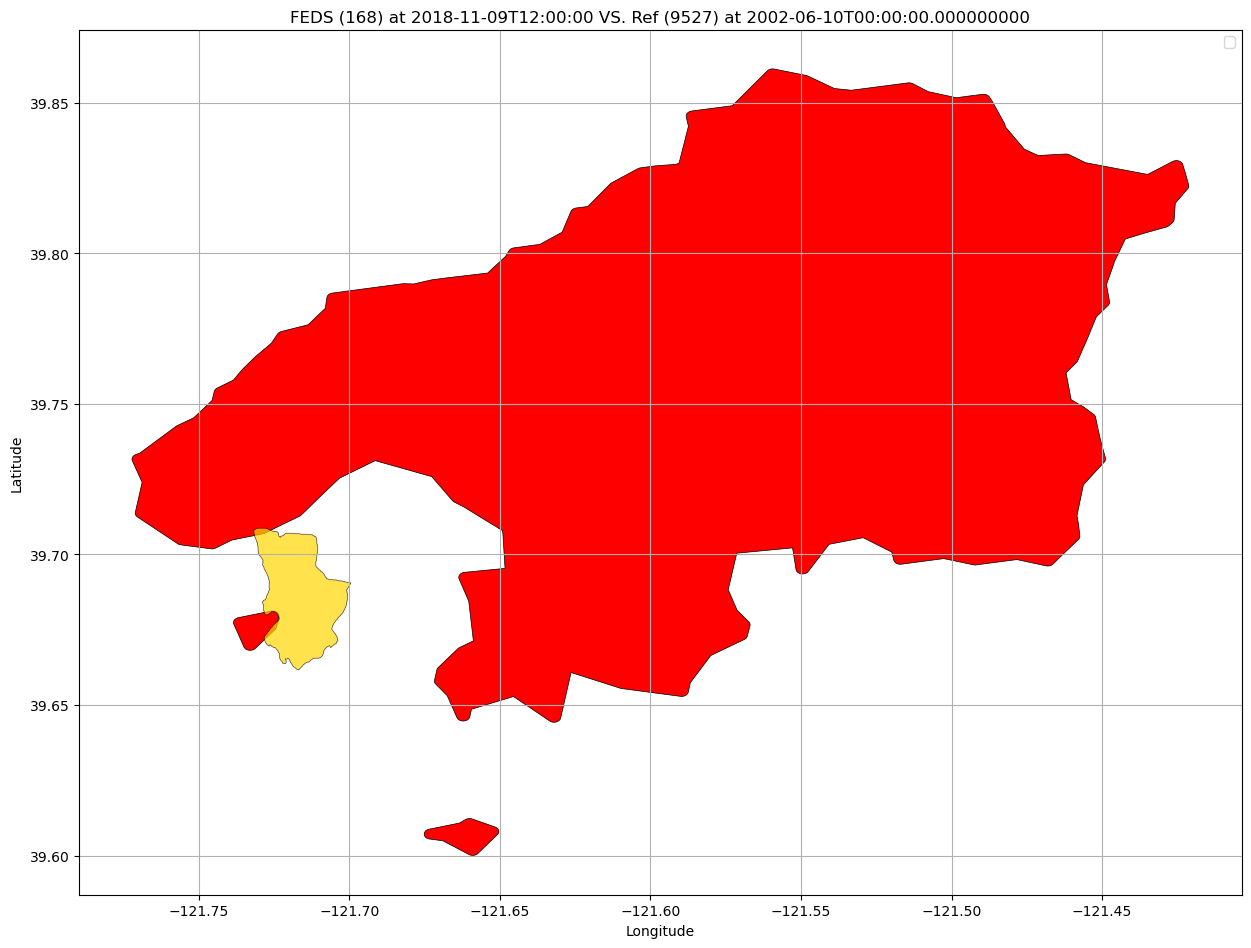

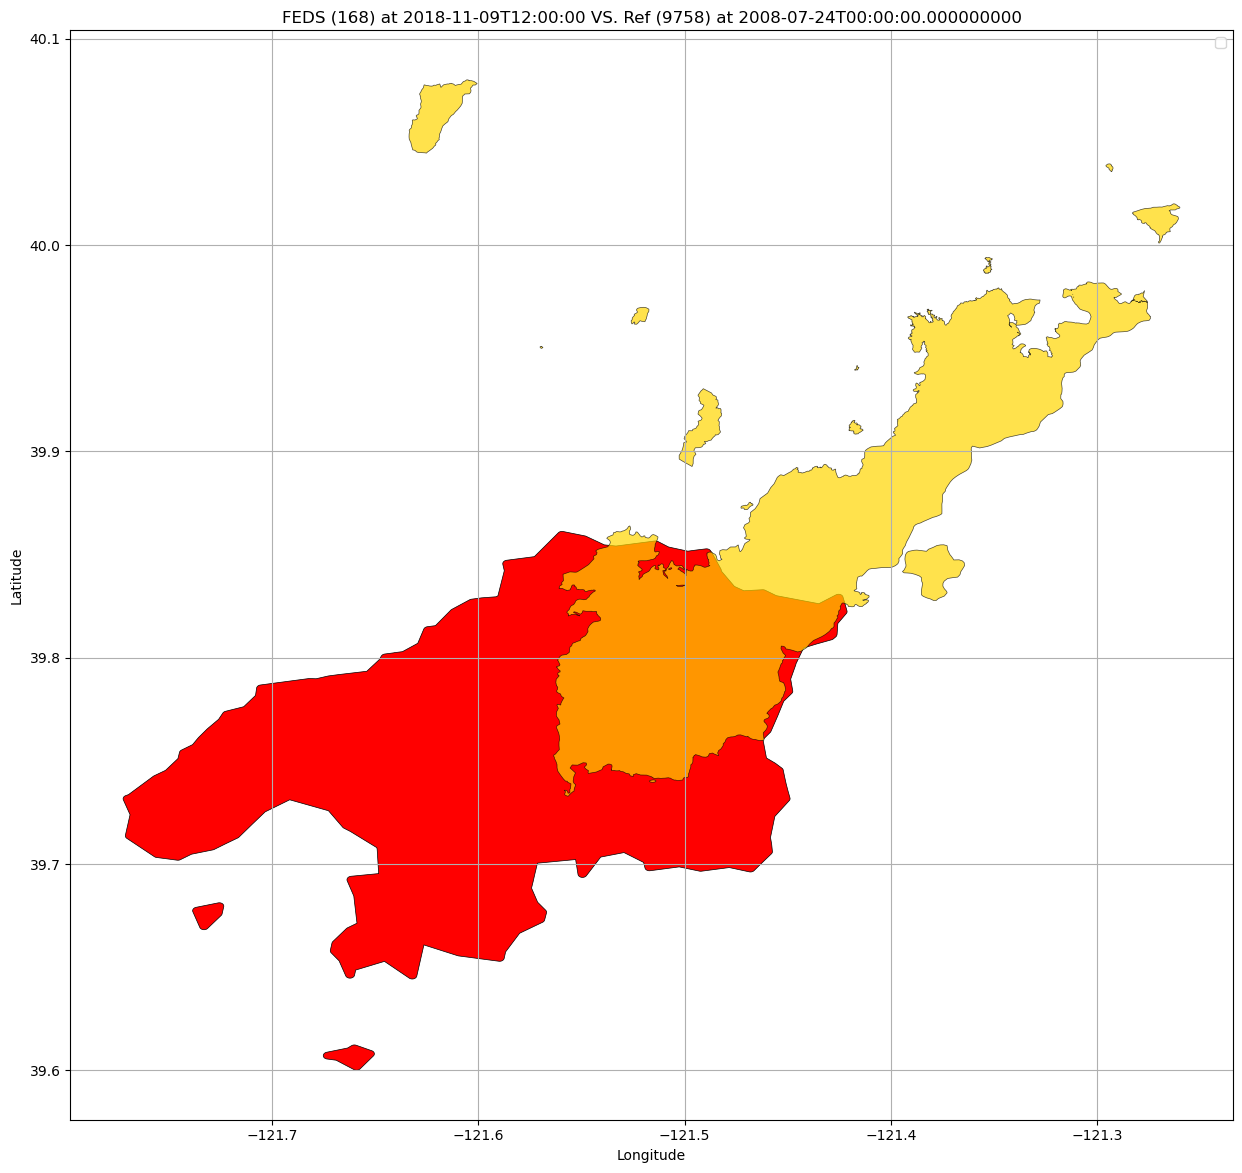

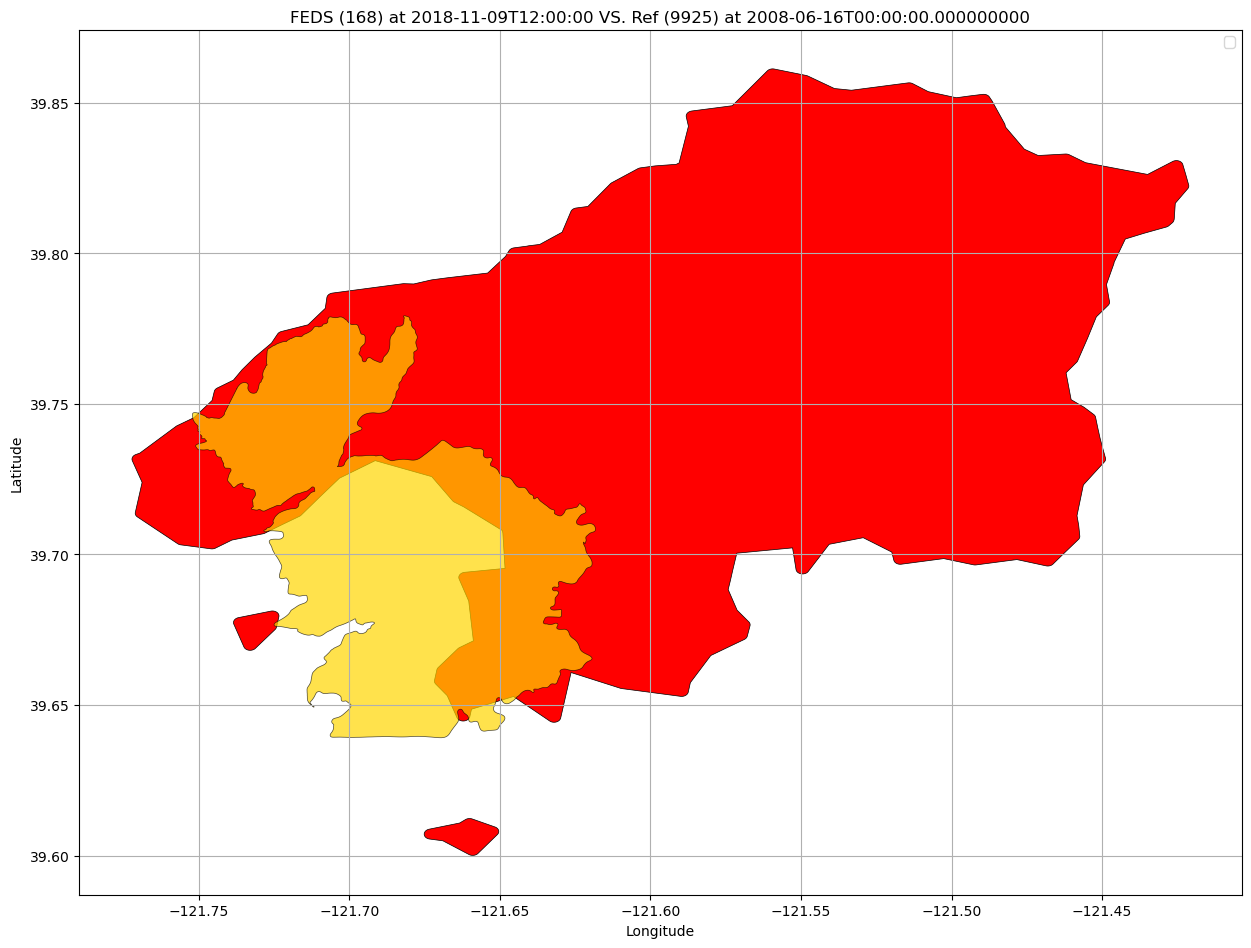

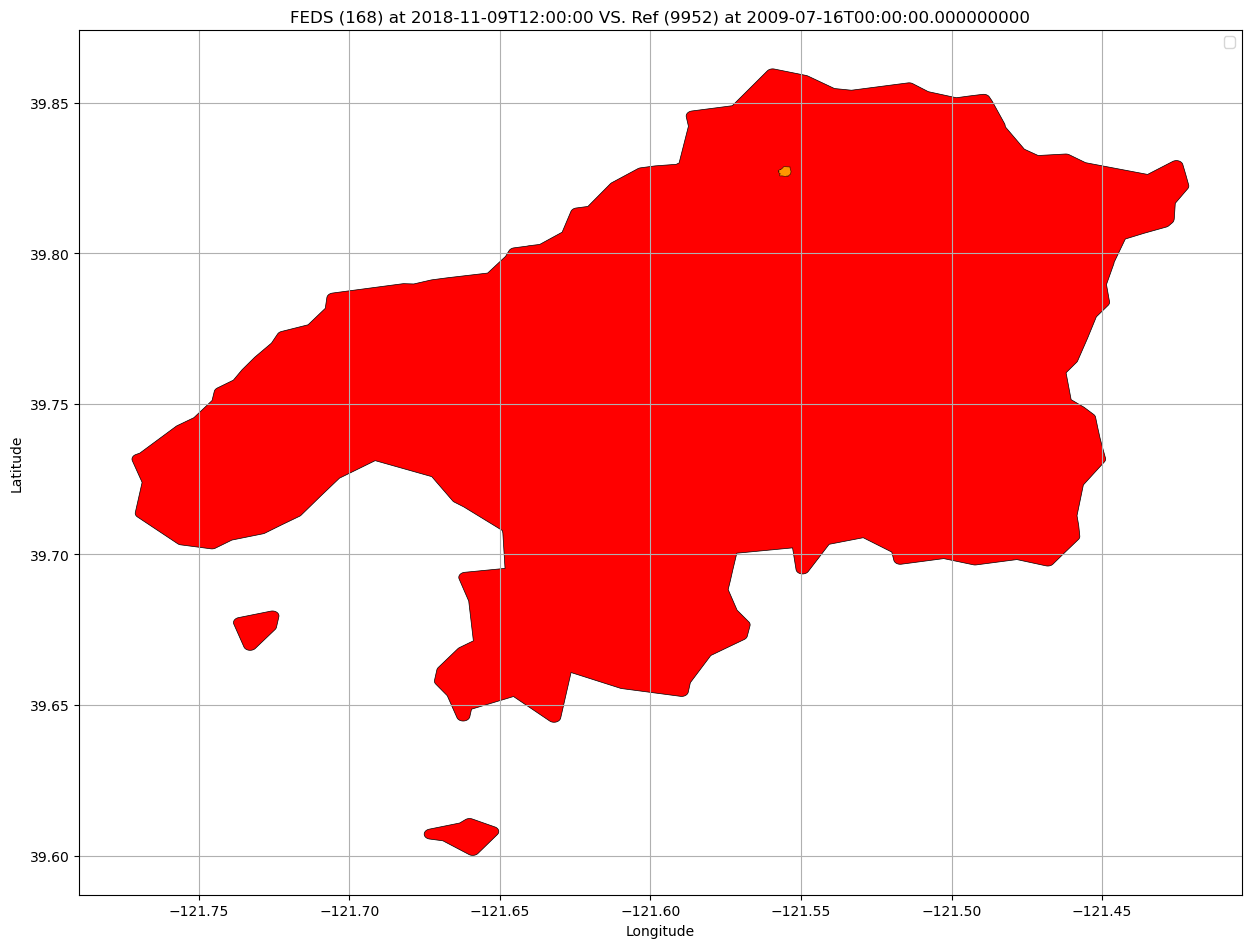

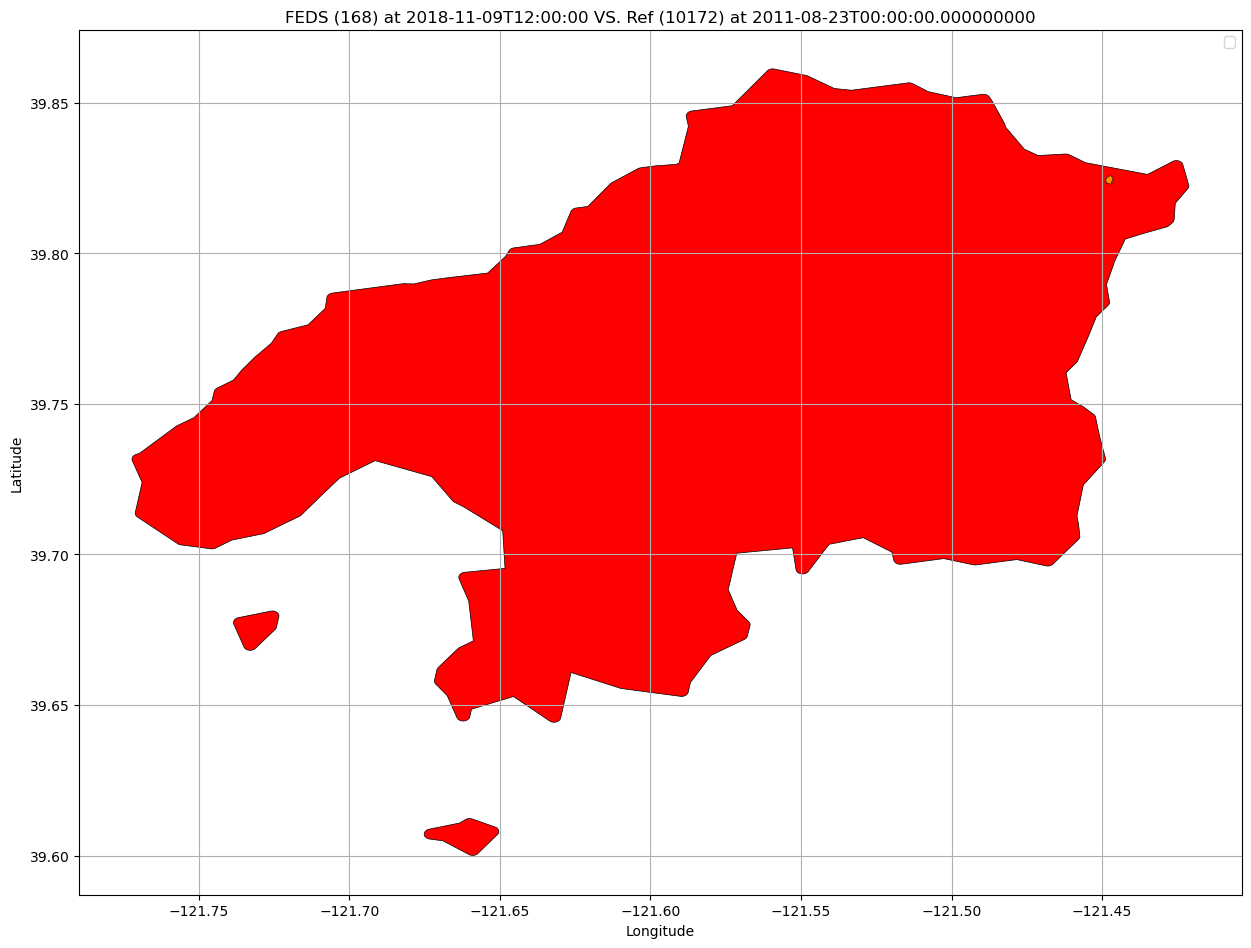

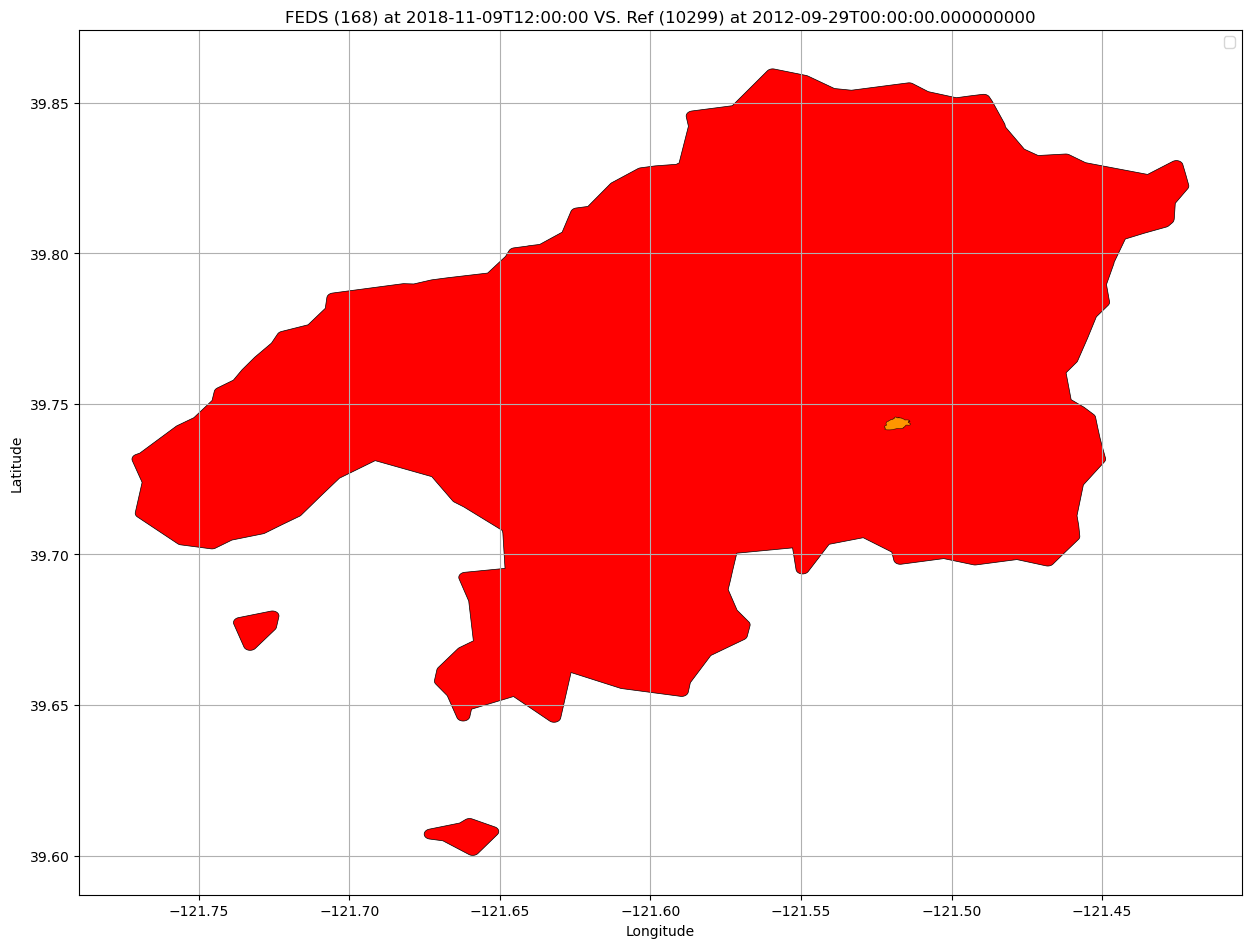

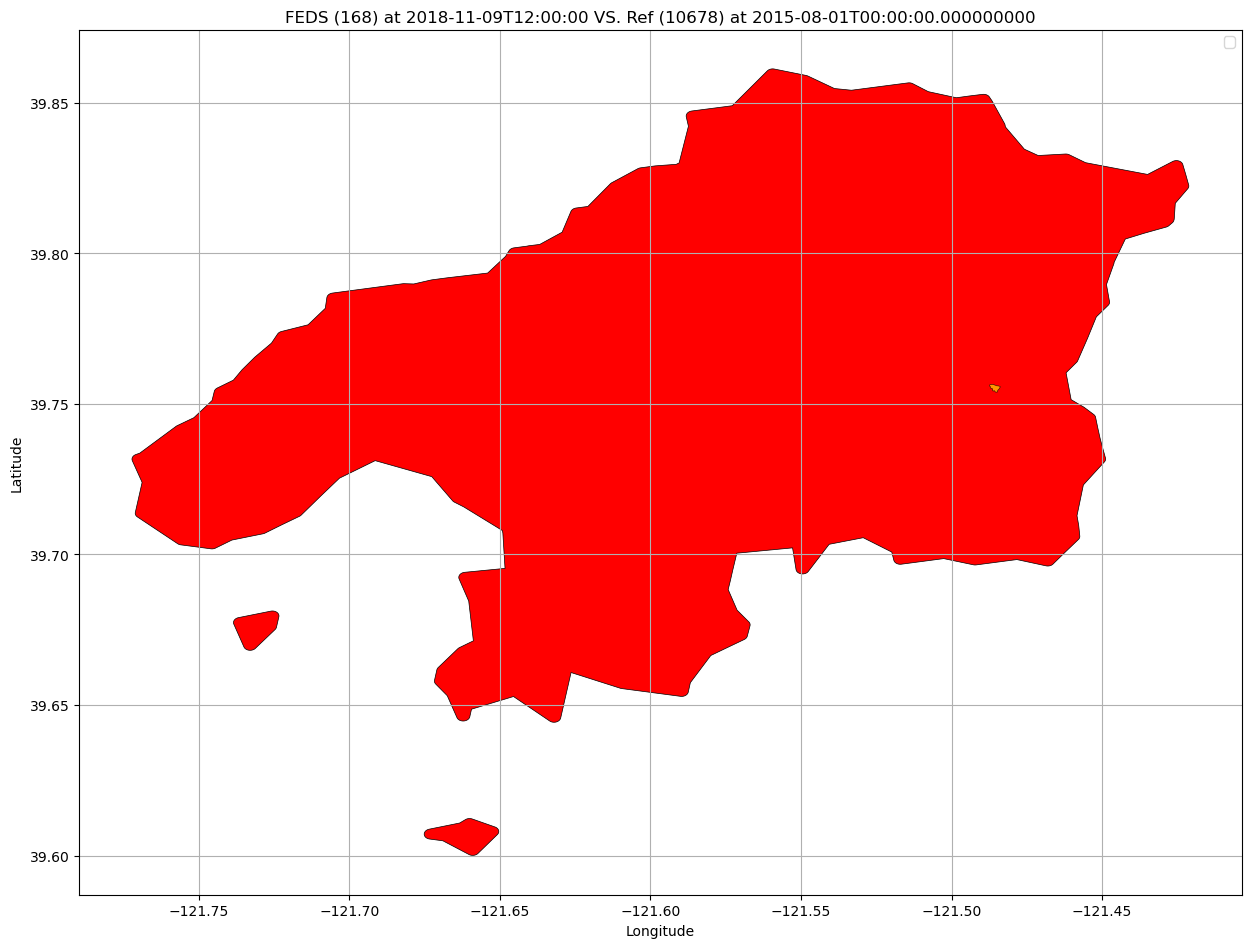

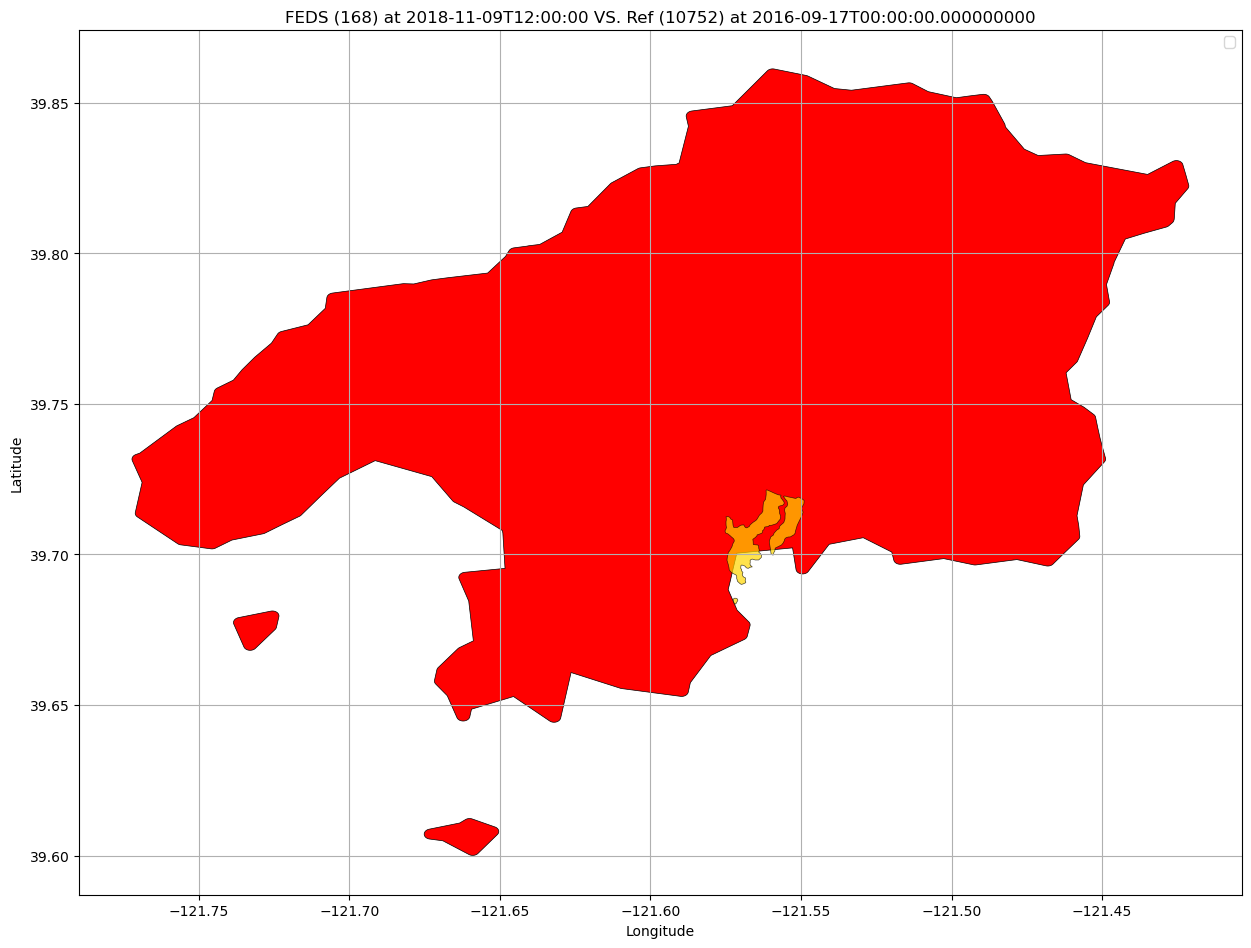

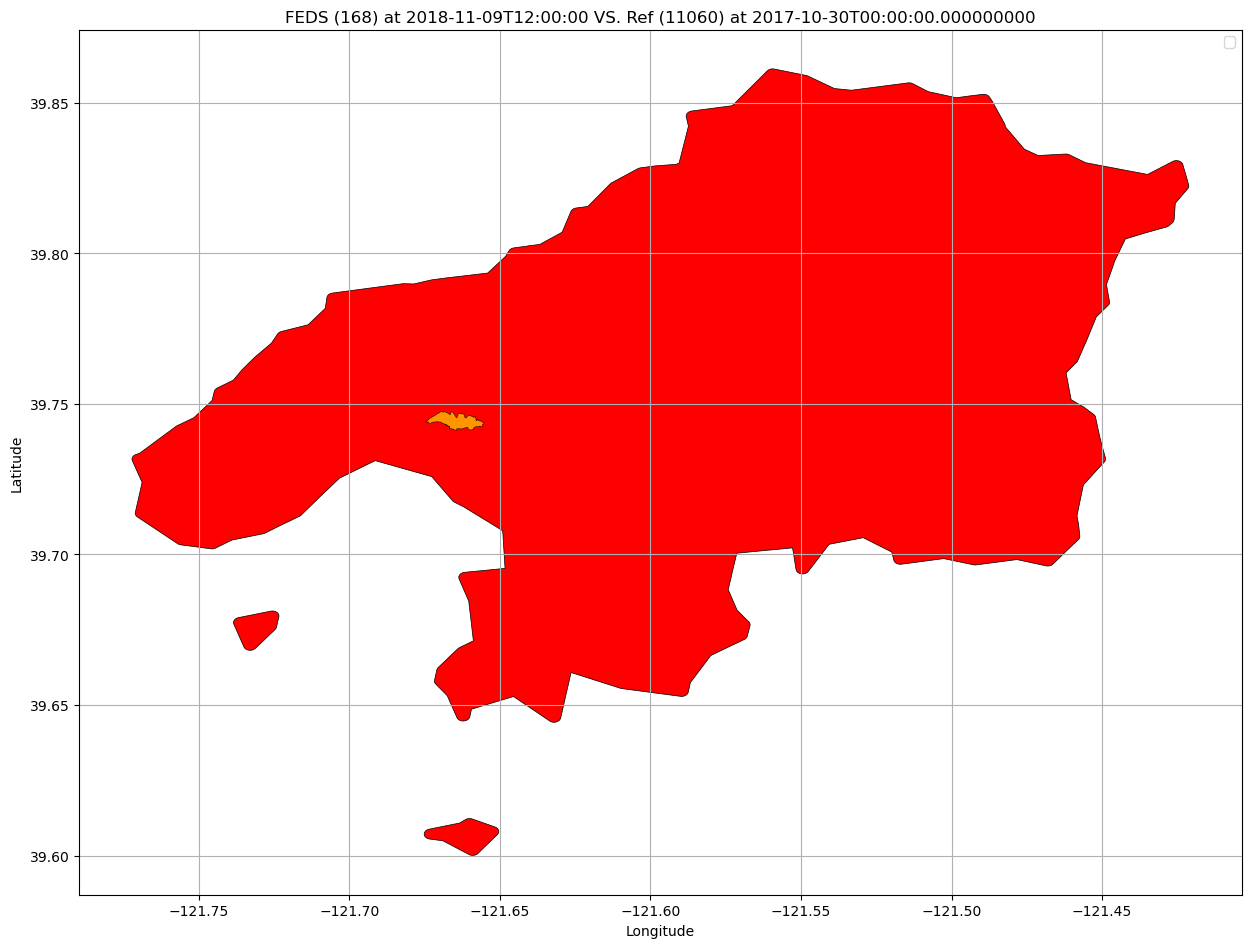

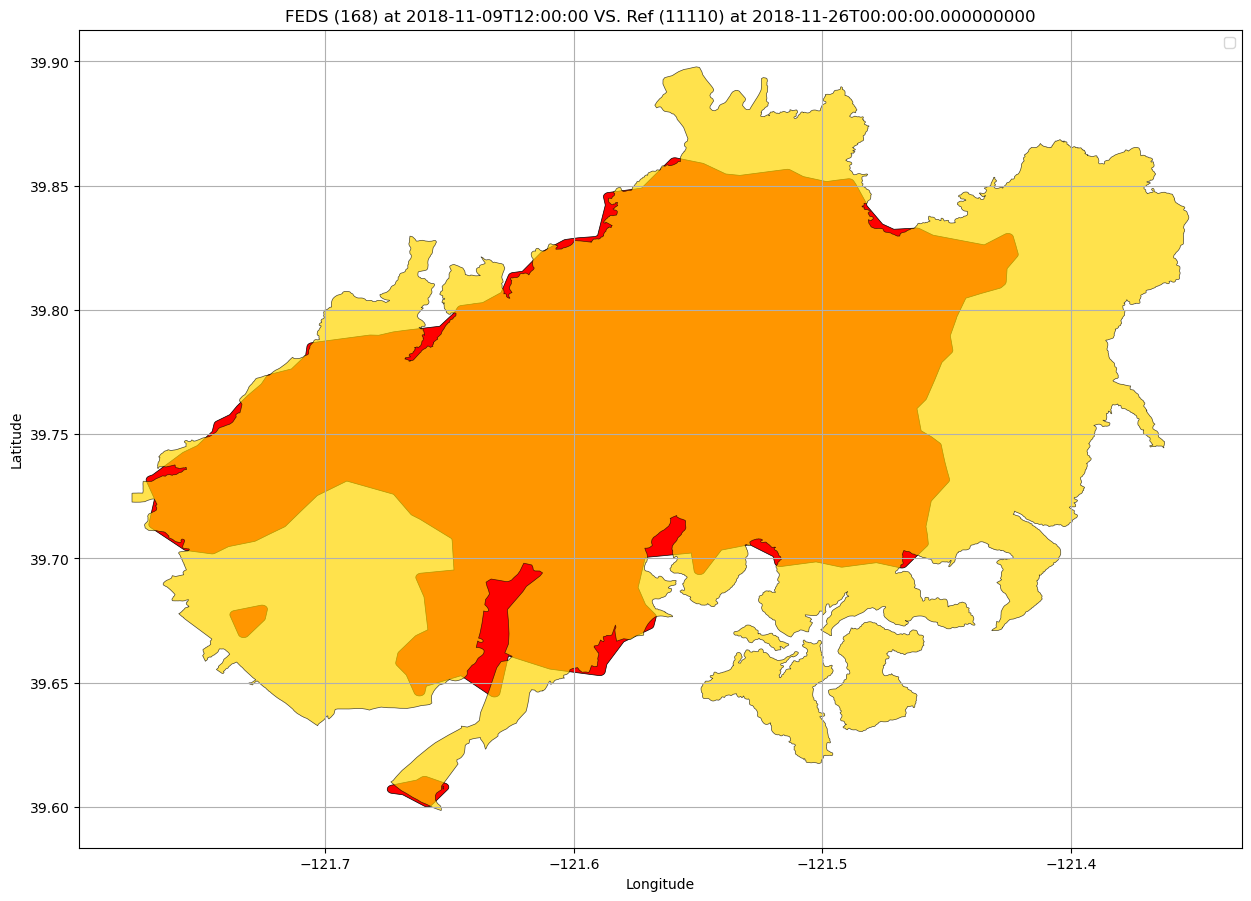

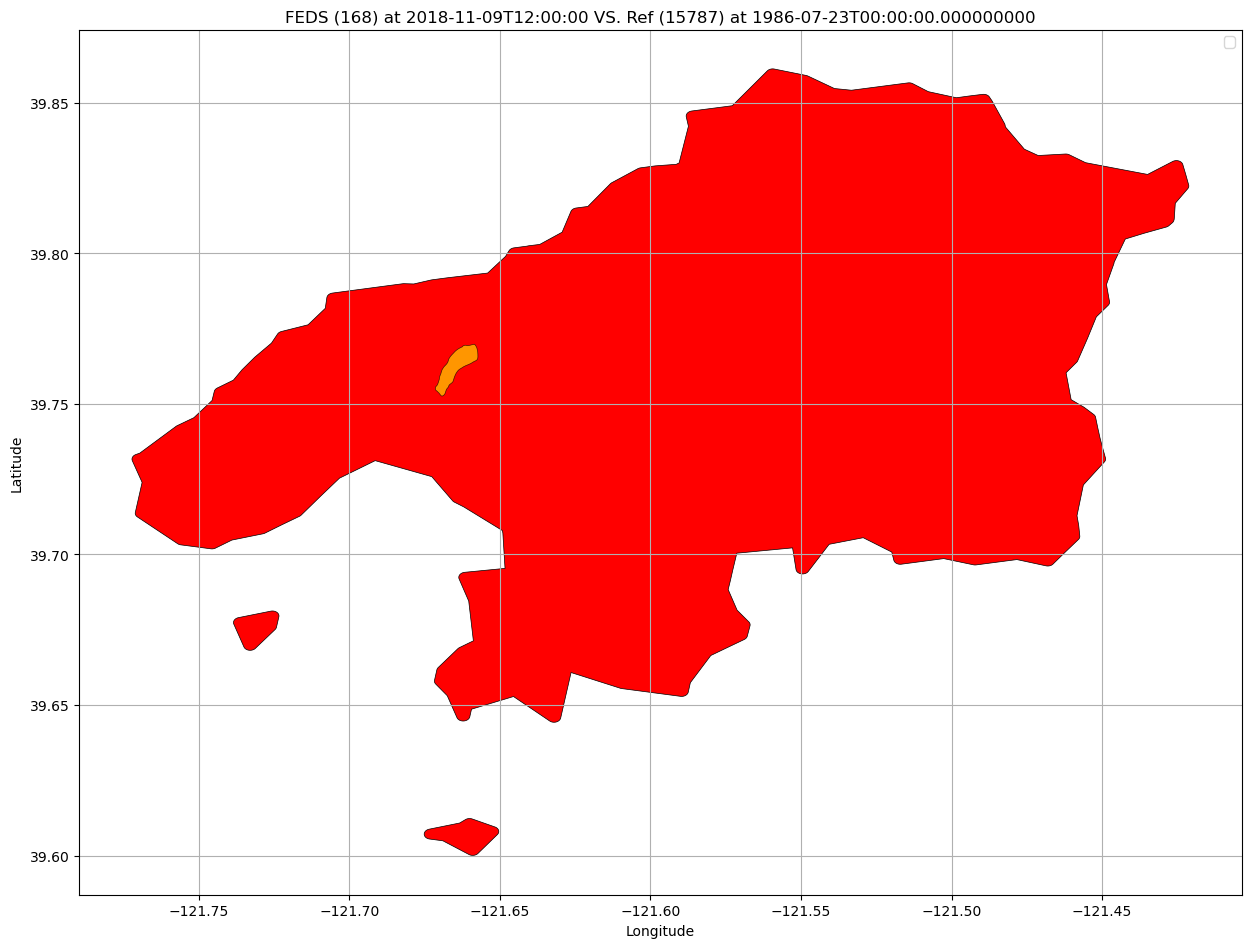

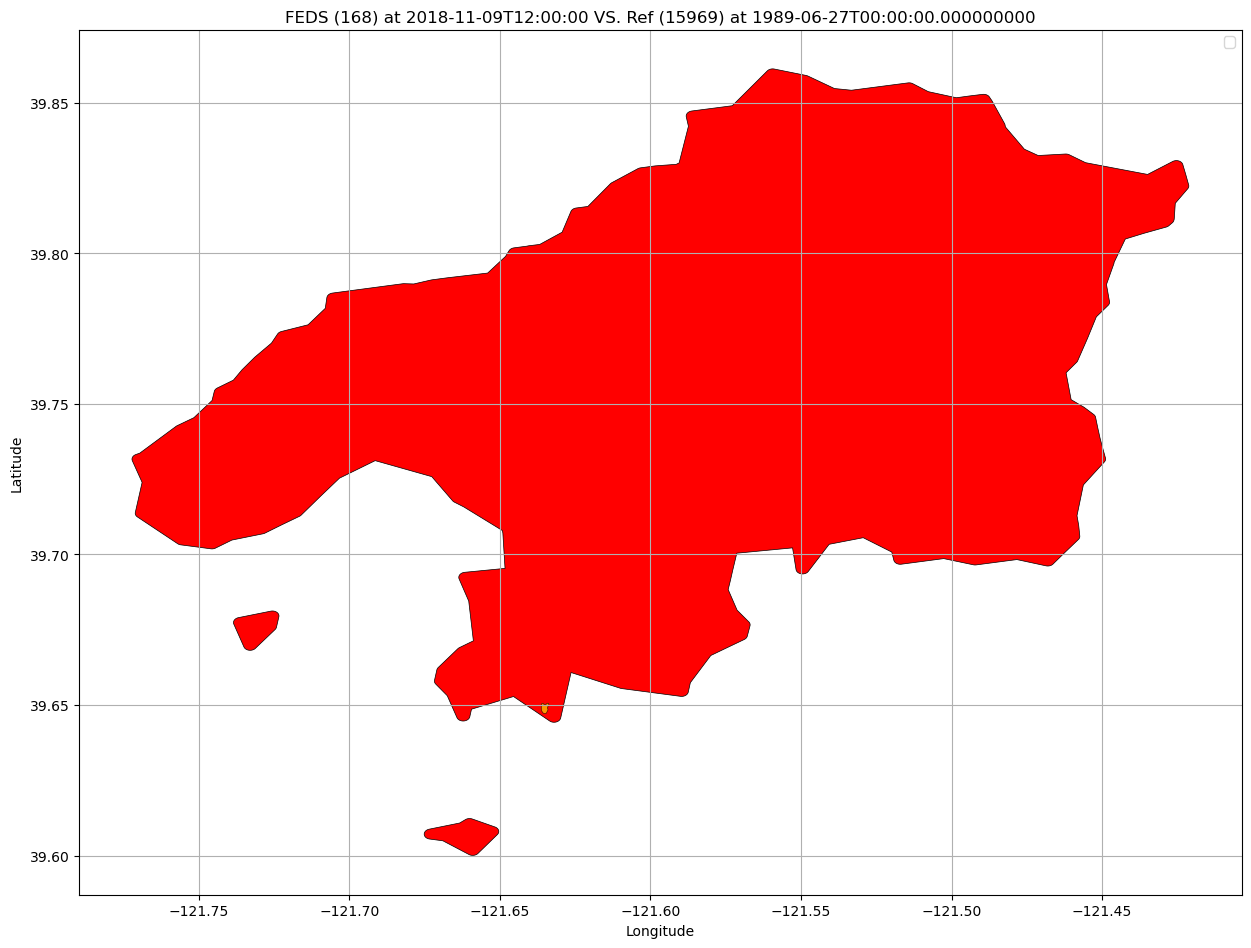

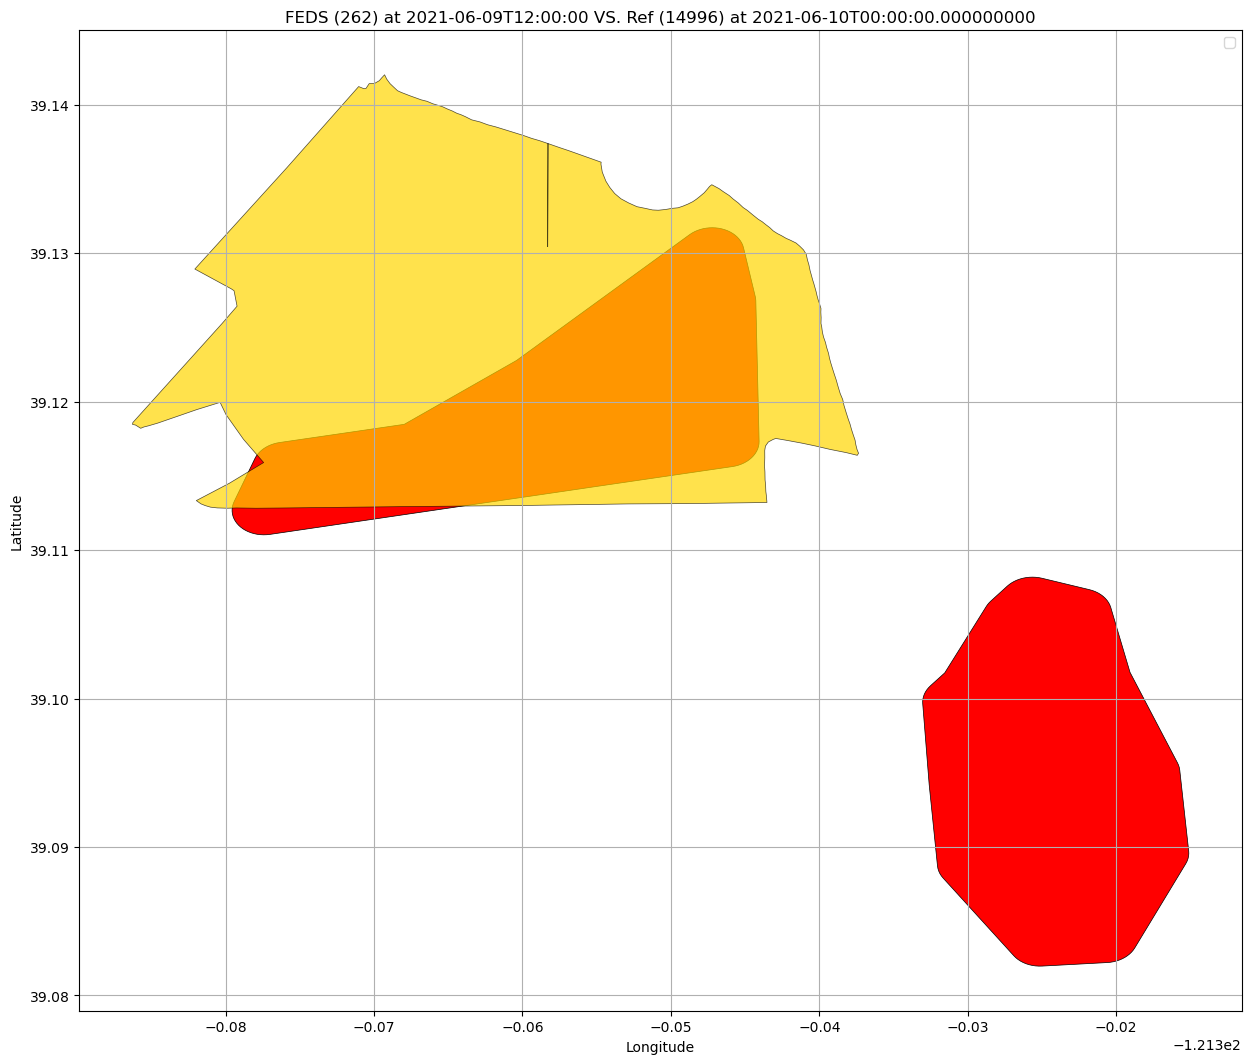

PLOTTING COMPLETE


CSV output complete! Check file /projects/my-public-bucket/VEDA-PEC/results/2020_0301_to_0430_analysis.csv for results. NOTE: None result rows were excluded.


In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

### Export Polygons

Provide a path along with polygons, and then call on the `export_polygons` method for your OutputCalculation object

In [5]:
# test simplify

# written to be on indiv poly basis; need to iterate on matches like plots
# result_thresh, simple_history, performance_history, tolerace_history 

from Output_Calculation import *

collection_tresh = init_best_simplify(sat_fire, aircraft_fire, symmDiffRatioCalculation, False, 0, 2)
# print(f"Best threshold value: {result_thresh}")

NameError: name 'init_best_simplify' is not defined

In [ ]:
# name your file
shp_file_name = "nifc_fixed"
# resuses the same dir as the csv export 
output_shp_path = f"{user_path}/{shp_file_name}.shp"

my_output.export_polygons(nifc_search.polygons, output_shp_path)

In [ ]:
print(nifc_search.polygons)

column_to_drop = 'DATE_CUR_STAMP'
nifc_search.polygons.drop(column_to_drop, axis=1, inplace=True)

In [11]:
print(feds_firenrt.polygons)

                                              geometry  duration        farea  \
252  POLYGON ((-120.995 39.104, -120.995 39.107, -1...       0.0    11.083337   
912  MULTIPOLYGON (((-120.166 39.676, -120.166 39.6...       1.0    79.414894   
102  POLYGON ((-120.851 39.929, -120.851 39.929, -1...      52.5  1400.560920   
399  POLYGON ((-120.558 38.644, -120.558 38.644, -1...       6.0   397.591762   
818  POLYGON ((-120.661 39.276, -120.661 39.276, -1...       4.5     9.108080   
591  POLYGON ((-120.392 38.997, -120.392 38.997, -1...       9.0    14.229837   
209  POLYGON ((-121.352 39.374, -121.352 39.374, -1...       0.0     7.053834   
764  MULTIPOLYGON (((-120.569 38.846, -120.569 38.8...      21.5    26.376048   
168  MULTIPOLYGON (((-121.426 39.811, -121.426 39.8...       1.0   375.871677   
707  POLYGON ((-120.545 38.878, -120.544 38.878, -1...       3.0     7.744742   
483  POLYGON ((-120.351 38.710, -120.351 38.710, -1...       6.5     7.486484   
527  POLYGON ((-120.315 38.8